## Imports

In [485]:
# Importing the necessary modules
import numpy as np
import mne
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pickle
import plotly.express as px
from plotly.subplots import make_subplots
from scipy.signal import detrend, lombscargle, welch, find_peaks
import scipy.fft as fft
import scipy.stats as stats
import biosppy.signals.ecg as ecgde
from scipy.stats import pearsonr
import seaborn as sns
from sklearn.model_selection import KFold
from scipy.fft import rfft, rfftfreq
from sklearn.linear_model import Lasso
import statsmodels.api as sm
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import PowerTransformer
from sklearn.linear_model import LogisticRegression
from astropy.timeseries import LombScargle
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif
from scipy import stats
import matplotlib.lines as mlines
import scipy
from scipy.special import expit
import matplotlib.patches as mpatches

%matplotlib qt

In [3]:
class LassoRegression() :
      
    def __init__( self, learning_rate, iterations, l1_penalty ) : 
        self.learning_rate = learning_rate
        self.iterations = iterations 
        self.l1_penalty = l1_penalty
          
    # Function for model training        
    def fit( self, X, Y ) :  
        # no_of_training_examples, no_of_features
        self.m, self.n = X.shape
          
        # weight initialization   
        self.W = np.zeros( self.n ) 
        self.b = 0
        self.X = X 
        self.Y = Y
          
        # gradient descent learning       
        for i in range( self.iterations ) :     
            self.update_weights()   
            
        return self
      
    # Helper function to update weights in gradient descent 
    def update_weights( self ) :     
        Y_pred = self.predict( self.X )
          
        # calculate gradients    
        dW = np.zeros( self.n )  
        for j in range( self.n ) :     
            if self.W[j] > 0 :       
                dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) ) + self.l1_penalty ) / self.m
          
            else :
                dW[j] = ( - ( 2 * ( self.X[:, j] ).dot( self.Y - Y_pred ) ) - self.l1_penalty ) / self.m
        db = - 2 * np.sum( self.Y - Y_pred ) / self.m 
          
        # update weights
        self.W = self.W - self.learning_rate * dW
        self.b = self.b - self.learning_rate * db
        return self
      
    # Hypothetical function  h( x )    
    def predict( self, X ) : 
        return X.dot( self.W ) + self.b
    
    def score(self, y_test, prediction):
        return pearsonr(y_test, prediction)
    
    def get_weights(self):
        return self.W

## Defining the functions

In [383]:
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler


STANDARD_PERFORMANCE_METRICS = [
    'speed_sub',
    'velocity_x_sub',
    'velocity_y_sub',
    'isj_sub',
    'isj_x_sub',
    'isj_y_sub',
    'acceleration_sub',
    'acceleration_x_sub',
    'acceleration_y_sub',
  ]
EXTENDED_PERFORMANCE_METRICS = [
    'speed_sub',
    'velocity_x_sub',
    'velocity_y_sub',
    'isj_sub',
    'isj_x_sub',
    'isj_y_sub',
    'acceleration_sub',
    'acceleration_x_sub',
    'acceleration_y_sub',
    'dt',
    'dt_l',
    'dt_norm',
    'pathlen',
    'len',
  ]


def projection_performance_metrics(scores, block_labels=None, detrend=False,
                                   t_stamps=None,
                                   reject_outliers=False):
    """
    trains LDA (if stim labels are available) or PCA (if labels not available)
    and projects the copyDraw trace features onto the generated subspace

    Parameters
    ----------
    scores : np.array NxD
        array containing the copyDraw behavioral features
    block_labels : np.array Nx1
        stim condition for each of the observations in scores
    detrend : bool, optional
        detrend the features in scores across the session. The default is False
    t_stamps : np.array Nx1, optional
        time stamps of the execution time of each of the observations in
        scores. The default is None.
    reject_outliers : bool, optional
        Perform outlier rejection using DBSCAN. After clustering, observations
        not belonging to a cluster are marked as outliers.
        The default is False.
    return_performance : bool, optional
        return decoding performance of the LDA model (AUC).
        The default is False.
    return_proj_model : TYPE, optional
        trained LDA model. The default is False.

    Returns
    -------
    ret : tuple
        [labels,
         onehot_accepted (outliers),
         (decoding_auc,pval)
         trained LDA model
         ].

    """
    if block_labels is not None:
        assert scores.shape[0] == block_labels.shape[0]
        projector = LDA(solver='eigen', shrinkage='auto')
    else:
        projector = PCA(n_components=1)
    # detect outliers

    scores_normalized = StandardScaler().fit_transform(scores)
    if reject_outliers:
        clustering = DBSCAN(eps=4).fit(scores_normalized)
        onehot_accepted = clustering.labels_ != -1
        ix_accepted = np.where(onehot_accepted)[0]
    else:
        onehot_accepted = np.ones((len(scores_normalized)), dtype=int)
        ix_accepted = np.where(onehot_accepted)[0]

    l_block_labels = block_labels[onehot_accepted]
    l_scores = scores_normalized[ix_accepted]

    if detrend:
        if t_stamps is None:
            t_stamps = np.arange(scores.shape[0])
        scores_detrended = scores_normalized
        for ix_feat, c_feat in enumerate(l_scores.T):
            c_model_detrend = LinearRegression().fit(
                t_stamps[ix_accepted].reshape(-1, 1), c_feat)
            scores_detrended[:, ix_feat] -= (
                c_model_detrend.predict(t_stamps.reshape(-1, 1)))
    else:
        scores_detrended = scores_normalized

    projector.fit(l_scores, l_block_labels)

    labels = projector.transform(
        StandardScaler().fit_transform(scores_detrended))
    labels = np.squeeze(labels)

    return labels, onehot_accepted, projector

In [670]:
def load_data(session, picks=None):
    
    signal = mne.io.Raw(r"C:\Users\jesse\Documents\AI_ThirdYear\Thesis" + "\\" + session + "\\" + "full_raw.fif", preload=True)
    
    if picks != None:
        signal.pick_channels(picks)
    
    score_data = pickle.load(open(session + '/scores_raw.p', 'rb'))
    
    labels, onehot_accepted, projector = projection_performance_metrics(
            score_data[STANDARD_PERFORMANCE_METRICS].values,
            block_labels=score_data['stim'],
            detrend=True,
            reject_outliers=True)
    score_data['final_label'] = labels
    score_data['accepted'] = onehot_accepted
    
    if session == "s5_3":
        score_data = score_data[score_data.ix_block != 1]
    
    stim = score_data['stim'].to_list()
    
    return signal, score_data, stim


In [6]:
def scores_overview(scores, session):
    #Plotting the motor scores
    fig = px.scatter(scores[scores['accepted']], x='startTStamp', y='final_label', color='stim_str',
                    title="Motor scores for " + session)
    fig.show()
    
    #Plotting a histogram
    plt.hist(scores['final_label'], bins=30)
    plt.title('Histogram of motor scores for ' + session)
    plt.xlabel('Motor Score')
    plt.ylabel('Count')
    plt.show()

In [487]:
def filtering(signal, scaling, name, session, lfreq=None, hfreq=None, tb=None):
    #Plotting the time-series of the signal
    signal.plot(title='Time-series of ' + session + ' ' + name + ' ' + ' before filtering', scalings=scaling)
    
    #Plotting the frequency spectrum of the signal
    signal.plot_psd(estimate='power')
    
    #Apply Notch filter for emg
    if 'emg' in name:
        if tb != None:
            signal.notch_filter(freqs=np.arange(50, 100, 50), trans_bandwidth=tb)
        else:
            signal.notch_filter(freqs=np.arange(50, 100, 50))
    
    #Applying a bandpass filter:
    signal = signal.filter(l_freq=lfreq, h_freq=hfreq, method='iir')
    signal.plot_psd(estimate='power')
    
    signal.plot(title='Time-series of ' + session + ' ' + name + ' ' + ' after filtering', scalings=scaling)
    
    return signal

In [488]:
def epoching(signal, picks, scaling, session, name):
    ev, evid = mne.events_from_annotations(signal)
    
    evid_rel = [evid['Stimulus/S 11'], evid['Stimulus/S 12'], evid['Stimulus/S 13'], evid['Stimulus/S 14'], evid['Stimulus/S 15'], evid['Stimulus/S 16']]

    epo = mne.Epochs(signal, events=ev, event_id=evid_rel, tmin=0, tmax=6, picks=picks, baseline=None, preload=True, detrend=1, reject_by_annotation=False, flat=None, reject=None)
    
    #Plotting the epoched signal
    epo.plot(picks=picks, scalings=scaling, title= session + ', ' + name + ': Epoched data')
    
    return epo

In [491]:
def features_emg(epo):
    #Time-Domain features
    MAV = np.zeros(len(epo))
    STD = np.zeros(len(epo))
    WL = np.zeros(len(epo))
    MPV = np.zeros(len(epo))
    DAMV = np.zeros(len(epo))
    MFL = np.zeros(len(epo))
    IAV = np.zeros(len(epo))
    DASDV = np.zeros(len(epo))
    ZC = np.zeros(len(epo))
    SSC = np.zeros(len(epo))
    for i, epoch in enumerate(epo):
        
        if i == 4:
            plt.plot(epoch[0,:])
            plt.show()
        
        
        MAV[i] = np.sum(np.abs(epoch[0,:]))/(len(epoch[0,:]))
        STD[i] = np.std(epoch[0,:])
        WL[i] = np.sum(np.abs(np.diff(epoch[0,:])))
        
        RMS = np.sqrt(np.sum(epoch[0,:]**2))/len(epoch[0,:])
        peak_values = []
        for j in range(0, len(epoch[0,:])):
            if epoch[0,j] > RMS:
                peak_values.append(epoch[0,j])
        
        MPV[i] = np.mean(peak_values)

        DAMV[i] = np.mean(np.abs(np.diff(epoch[0,:])))

        MFL[i] = np.log10(np.sqrt(np.sum(((np.diff(epoch[0,:]))**2))))

        IAV[i] = np.sum(np.abs(epoch[0,:]))

        DASDV[i] = np.sqrt((1 / (len(epoch[0,:]) - 1)) * np.sum((np.diff(epoch[0,:])) ** 2))
        
        ZC[i] = 0
        for j in range(1, len(epoch[0,:])):
            if (-epoch[0,j] * epoch[0,j-1]) < 0:
                ZC[i] += 1
              
        SSC[i] = 0
        for j in range(1, len(epoch[0,:])-1):
            f = (epoch[0,j] - epoch[0,j-1]) * (epoch[0,j] - epoch[0,j+1])
            if f > 0.00000000002:
                SSC[i] += 1

    #Frequency-Domain features
    MNF = np.zeros(len(epo))
    MDF = np.zeros(len(epo))
    PKF = np.zeros(len(epo))
    PR = np.zeros(len(epo))
    TP = np.zeros(len(epo))
    SEF = np.zeros(len(epo))
    for i, epoch in enumerate(epo):  
        N = len(epoch[0,:])
        freqs = rfftfreq(N,1/200)
        psd = np.abs(rfft(epoch[0,:]))**2

        MNF[i] = np.sum(freqs * psd) / np.sum(psd)

        sorted_indices = np.argsort(psd)
        sorted_psd = psd[sorted_indices]
        sorted_freqs = freqs[sorted_indices]
        cumsum = np.cumsum(sorted_psd)
        idx = np.argmax(cumsum >= np.sum(psd) / 2)
        MDF[i] = sorted_freqs[idx]

        PKF[i] = freqs[np.argmax(psd)] 
        
        if i == 9:
            plt.plot(freqs, psd, label= "High motor score")
            plt.vlines(PKF[9], ymin=np.min(psd), ymax=np.max(psd), linestyles='dashed')
        if i == 117:
            plt.plot(freqs, psd, label= "Low motor score")
            plt.vlines(PKF[117], ymin=np.min(psd), ymax=np.max(psd), linestyles='dashed')
            plt.show()

        low_pow = psd[(freqs >= 10) & (freqs <= 55)]
        high_pow = psd[(freqs > 55) & (freqs <= 100)]
        low_fband = np.sum(low_pow)
        high_fband = np.sum(high_pow)
        PR[i] = low_fband/high_fband

        TP[i] = np.sum(psd)
        
        SEF[i] = freqs[np.sum(np.cumsum(psd) < 0.9*np.sum(psd))-1]
    
    X_time = [MAV, STD, WL, MPV, DAMV, MFL, IAV, DASDV, ZC, SSC]
    X_freq = [MNF, MDF, PKF, PR, TP, SEF]
    
    time_names = ["MAV", "STD", "WL", "MPV", "DAMV", "MFL", "IAV", "DASDV", "ZC", "SSC"]
    freq_names = ["MNF", "MDF", "PKF", "PR", "TP", "SEF"]
    
    return X_time, X_freq, time_names, freq_names

In [10]:
def features_pulse(epo):
    #Time-domain features
    MIBI = np.zeros(len(epo))
    SDNN = np.zeros(len(epo))
    RMSSD = np.zeros(len(epo))
    PNN20 = np.zeros(len(epo))
    AV = np.zeros(len(epo))
    
    #Frequency-domain features
    TP = np.zeros(len(epo))
    VLF = np.zeros(len(epo))
    LF = np.zeros(len(epo))
    HF = np.zeros(len(epo))
    Ratio_LF_HF = np.zeros(len(epo))

    for i, epoch in enumerate(epo):    
        #Obtaining the peaks of the heart-rate
        pulse_peaks_or, _ = find_peaks(epoch[0,:], prominence = 0.01)  
        pulse_peaks = np.array(pulse_peaks_or) / 200
        
        pulse_peaks = np.array(pulse_peaks) * 1000        
        
        #Computing the inter-beat interval, which is the time in between two beats (in seconds).
        rr_int = np.diff(pulse_peaks)
        
        MIBI[i] = np.mean(rr_int)
        SDNN[i] = np.std(rr_int)
        RMSSD[i] = np.sqrt(np.sum(np.square(np.diff(rr_int)))/(len(rr_int)-1))

        nn20_count = np.sum(np.abs(np.diff(rr_int)) > 20)
        PNN20[i] = (nn20_count/len(rr_int)) * 100

        amplitudes = epoch[0,pulse_peaks_or]
        AV[i] = np.var(amplitudes)
        
        #----------------------------------------------------------------------------------------
        
        time_indices = np.arange(len(rr_int))
        # Create an instance of the LombScargle class
        ls = LombScargle(time_indices, rr_int)

        # Define the frequency range for periodogram calculation
        frequency_range = np.linspace(0.0, 0.49, num=100)

        # Compute the Lomb-Scargle periodogram
        periodogram = ls.power(frequency_range)[1:]
        
        vlf_indices = np.where((frequency_range >= 0) & (frequency_range < 0.04))
        lf_indices = np.where((frequency_range >= 0.04) & (frequency_range < 0.15))
        hf_indices = np.where((frequency_range >= 0.15) & (frequency_range < 0.4))

        TP[i] = np.sum(periodogram)
        VLF[i] = np.sum(periodogram[vlf_indices])
        LF[i] = np.sum(periodogram[lf_indices])
        HF[i] = np.sum(periodogram[hf_indices])
        Ratio_LF_HF[i] = LF[i]/HF[i]

     
    X_time = [MIBI, SDNN, RMSSD, PNN20, AV]
    X_freq = [TP, VLF, LF, HF, Ratio_LF_HF]
    
    time_names = ["MIBI", "SDNN", "RMSSD", "PNN20", "AV"]
    freq_names = ["TP", "VLF", "LF", "HF", "Ratio_LF_HF"]
    
    return X_time, X_freq, time_names, freq_names

In [11]:
def features_accel(epo):

    #Time-domain features
    #Intensity
    MA = np.zeros(len(epo))
    IQR = np.zeros(len(epo))
    MIN = np.zeros(len(epo))
    MAX = np.zeros(len(epo))
    RMS = np.zeros(len(epo))

    #Smoothness
    STD = np.zeros(len(epo))
    
    AV = np.zeros(len(epo))
    ML = np.zeros(len(epo))

    for i, epoch in enumerate(epo):    
        #Obtaining the peaks of the heart-rate
        pulse_peaks, _ =  find_peaks(epoch[0,:], prominence = 0.03)
        pulse_peaks_neg, _ = find_peaks(-epoch[0,:], prominence = 0.03)

        MA[i] = np.mean(epoch[0,:])
        IQR[i] = stats.iqr(epoch[0,:])
        MIN[i] = np.min(epoch[0,:])
        MAX[i] = np.max(epoch[0,:])
        RMS[i] = np.sqrt(np.sum(np.abs(epoch[0,:])**2)/len(epoch[0,:]))

        STD[i] = np.std(epoch[0,:])

        amplitudes = epoch[0,pulse_peaks]
        AV[i] = np.var(amplitudes)
        
        if len(pulse_peaks) > len(pulse_peaks_neg):
            lengths = abs(epoch[0,pulse_peaks_neg]-epoch[0,pulse_peaks[0:len(pulse_peaks_neg)]])
        else:
            lengths = abs(epoch[0,pulse_peaks_neg[0:len(pulse_peaks)]]-epoch[0,pulse_peaks])
        ML[i] = np.max(lengths)

    #Periodicity
    PKF = np.zeros(len(epo))
    TP = np.zeros(len(epo))
    PTR = np.zeros(len(epo))

    for i, epoch in enumerate(epo):
        freqs, psd = welch(epoch[0,:], fs=200)

        PKF[i] = freqs[np.argmax(psd)]

        TP[i] = np.sum(psd)
        PTR[i] = PKF[i]/TP[i] 
    
    X_time = [MA, IQR, MIN, MAX, RMS, STD, AV, ML]
    X_freq = [PKF, TP, PTR]
    
    time_names = ["MA", "IQR", "MIN", "MAX", "RMS", "STD", "AV", "ML"]
    freq_names = ["PKF", "TP", "PTR"]
    
    return X_time, X_freq, time_names, freq_names

In [12]:
def plot_features(f_time, f_freq, time_names, freq_names, scores, stim):
    #For every feature, make a:
    #- Scatterplot against the score
    #- Distribution plot
    
    stim_mask_off = [value == 0 for value in stim]
    stim_mask_on = [value == 1 for value in stim]
    
    for i in range(len(f_time)):
        #Create the main figure and grid layout
        fig = plt.figure(figsize=(10, 6))
        gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2])
        
        # Add plots to the grid layout
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[1, 0])
        ax3 = plt.subplot(gs[0, 1])
        ax4 = plt.subplot(gs[1, 1])
    
        # Plot on the first subplot (left column)
        ax1.scatter(f_time[i], scores)
        ax1.set_title(time_names[i] + ' vs ' + 'Motor Score')
        ax1.set_xlabel(time_names[i])
        ax1.set_ylabel('Motor score')
        
        feature_ON = np.array(f_time[i])[stim_mask_on]
        feature_OFF = np.array(f_time[i])[stim_mask_off]
        
        sns.histplot(feature_OFF, label='Stimulation Off', color='red', ax=ax3, bins=30)
        sns.histplot(feature_ON, label='Stimulation On', color='blue', ax=ax3, bins=30)
        ax3.set_ylabel('Density')
        ax3.set_title('Distribution of ' + time_names[i])
        
        ax4.scatter(feature_ON, np.array(stim)[stim_mask_on], color='blue')
        ax4.scatter(feature_OFF, np.array(stim)[stim_mask_off], color='red')
        ax4.set_ylabel('DBS condition')
        ax4.set_xlabel(time_names[i])
        
        stats.probplot(f_time[i], plot=ax2)
        ax2.set_title("QQ Plot")
        ax2.set_xlabel("Theoretical Quantiles")
        ax2.set_ylabel("Sample Quantiles")
        
        fig.legend()
        
        plt.subplots_adjust(wspace=0.4)
        plt.show()
        
    for i in range(len(f_freq)):
        #Create the main figure and grid layout
        fig = plt.figure(figsize=(10, 6))
        gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2])
        
        # Add plots to the grid layout
        ax1 = plt.subplot(gs[0, 0])
        ax2 = plt.subplot(gs[1, 0])
        ax3 = plt.subplot(gs[0, 1])
        ax4 = plt.subplot(gs[1, 1])
        
        # Plot on the first subplot (left column)
        ax1.scatter(f_freq[i], scores)
        ax1.set_title(freq_names[i] + ' vs ' + 'Motor Score')
        ax1.set_xlabel(freq_names[i])
        ax1.set_ylabel('Motor score')
        
        feature_ON = f_freq[i][stim_mask_on]
        feature_OFF = f_freq[i][stim_mask_off]
        
        sns.histplot(feature_OFF, label='Stimulation Off', color='red', ax=ax3, bins=30)
        sns.histplot(feature_ON, label='Stimulation On', color='blue', ax=ax3, bins=30)
        ax3.set_ylabel('Density')
        ax3.set_title('Distribution of ' + freq_names[i])
        
        ax4.scatter(feature_ON, np.array(stim)[stim_mask_on], color='blue')
        ax4.scatter(feature_OFF, np.array(stim)[stim_mask_off], color='red')
        ax4.set_ylabel('DBS condition')
        ax4.set_xlabel(freq_names[i])
        
        stats.probplot(f_freq[i], plot=ax2)
        ax2.set_title("QQ Plot")
        ax2.set_xlabel("Theoretical Quantiles")
        ax2.set_ylabel("Sample Quantiles")
        
        fig.legend()
        
        plt.subplots_adjust(wspace=0.4)
        plt.show()
        

In [13]:
def outlier_rejection(X_time, X_freq, time_names, freq_names, normal_features):
    
    masks = []
    for i in range (len(X_time)):
        X_time_int = X_time[i].copy()
        if time_names[i] not in normal_features:
            transformer = PowerTransformer(method='yeo-johnson')
            X_time_int = transformer.fit_transform(X_time[i].reshape(-1, 1)).flatten()
            
        mean = np.mean(X_time_int)
        std = np.std(X_time_int)
        lower_bound = mean - (3*std)
        upper_bound = mean + (3*std)
        mask = (X_time_int >= lower_bound) & (X_time_int <= upper_bound)
        masks.append(mask)
        
    for i in range (len(X_freq)):
        X_freq_int = X_freq[i].copy()
        if freq_names[i] not in normal_features:      
            transformer = PowerTransformer(method='yeo-johnson')
            X_freq_int = transformer.fit_transform(X_freq[i].reshape(-1, 1)).flatten()            
            
        mean = np.mean(X_freq_int)
        std = np.std(X_freq_int)
        lower_bound = mean - (3*std)
        upper_bound = mean + (3*std)
        mask = (X_freq_int >= lower_bound) & (X_freq_int <= upper_bound)
        masks.append(mask)

    final_mask = [all(sublist) for sublist in zip(*masks)]
    indices = [index for index, element in enumerate(final_mask) if element == False]
    
    if len(indices) == 0:
        return None
    
    return indices

In [748]:
def feature_relations(feat, fea_names, scores, stim):
    #Make a parallel coordinates and cross-correlation plot
    
    data = {"motor_score": scores, "DBS": stim}
    for i in range(len(fea_names)):
        data[fea_names[i]] = feat[i]

    # create your parallel coordinates plot
    fig1 = px.parallel_coordinates(data, color="motor_score", dimensions=fea_names, title="Parallel Coordinates plot showing motor score")
    fig1.update_layout(font=dict(size=15))
    fig1.show()

    fig2 = px.parallel_coordinates(data, color="DBS", dimensions=fea_names, title="Parallel Coordinates plot showing DBS condition")
    fig2.update_layout(font=dict(size=15))
    fig2.show()

    #Calculating the covariance matrix of the time-domain features
    corrmatrix = np.corrcoef(feat)
    sns.heatmap(corrmatrix, annot=True, cmap='coolwarm', square=True, xticklabels=fea_names, yticklabels=fea_names, robust=True, vmin=-1, vmax=1, annot_kws={"fontsize": 15})
    plt.title("Correlation matrix of the different features", fontsize=20)
    plt.tick_params(axis='both', labelsize=20)
    plt.show()

In [16]:
def chance_level_classification(X, y, n_folds, block_sizes, MRMR=False):
    n_bootstraps = 1000
    acc_bootstraps = []
    for i in range(n_bootstraps):
        indices = np.random.choice(X.shape[0], X.shape[0], replace=False)
        y_new = np.array(y)[indices]
        
        if MRMR:
            selected_features = mrmr(X, y_new)
            X_feat = X[:, selected_features]
            acc_score = DBS_classification(X_feat, y_new, n_folds, block_sizes)[0]
            acc_bootstraps.append(acc_score)
        else:
            acc_score = DBS_classification(X, y_new, n_folds, block_sizes)[0]
            acc_bootstraps.append(acc_score)
        
        
        if i%100 == 0:
            progress = i/10
            print("Progress: " + str(progress) + "%")

    chance_level = np.mean(acc_bootstraps)
    
    return chance_level, acc_bootstraps

In [17]:
def chance_level_regression(X, y, n_folds, block_sizes, Lasso=False, l1_penalty=None, MRMR=False):
    
    n_bootstraps = 1000
    corr_coef_bootstraps = []
    for i in range(n_bootstraps):
        indices = np.random.choice(X.shape[0], X.shape[0], replace=False)
        y_new = y[indices]
        
        if MRMR:
            selected_features = mrmr(X, y_new)
            X_feat = X[:, selected_features]
            avg_corr, weights = motor_regression(X_feat, y_new, n_folds, block_sizes, Lasso=Lasso, l1_penalty=l1_penalty)
            corr_coef_bootstraps.append(avg_corr)
        else:
            avg_corr, weights = motor_regression(X, y_new, n_folds, block_sizes, Lasso=Lasso, l1_penalty=l1_penalty)
            corr_coef_bootstraps.append(avg_corr)
               
        
        
        if i%100 == 0:
            progress = i/10
            print("Progress: " + str(progress) + "%")

    chance_level = np.mean(corr_coef_bootstraps)
    
    return chance_level, corr_coef_bootstraps

In [18]:
def DBS_classification(X, y, n_folds, block_sizes):
    
    block_indices = list(range(sum(block_sizes)))
    block_starts = [sum(block_sizes[:i]) for i in range(len(block_sizes))]
    blocks = [block_indices[start:start+block_size] for start, block_size in zip(block_starts, block_sizes)]
    
    # Create a KFold object
    kf = KFold(n_splits=n_folds, shuffle=False)

    acc_scores_logreg = []
    
    weights = []
    predictions = []
    
    # Loop over each fold
    for train_indices, val_indices in kf.split(blocks):
        # Split the data into training and testing sets for this fold
        train_blocks = [block for i, block in enumerate(blocks) if i in train_indices]
        val_blocks = [block for i, block in enumerate(blocks) if i in val_indices]
        
        train_data = [data_point for block in train_blocks for data_point in block]
        val_data = [data_point for block in val_blocks for data_point in block]

        X_train = np.array([X[i] for i in train_data])
        y_train = np.array([y[i] for i in train_data])
        X_test = np.array([X[i] for i in val_data])
        y_test = np.array([y[i] for i in val_data])
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        logreg = LogisticRegression()
        logreg.fit(X_train_scaled, y_train)
        X_test_scaled = scaler.transform(X_test)
        logreg_accuracy = logreg.score(X_test_scaled, y_test)
        acc_scores_logreg.append(logreg_accuracy)
        weights.append(logreg.coef_[0])

    CV_logreg = np.mean(acc_scores_logreg)
    
    return CV_logreg, weights

In [19]:
def motor_regression(X, y, n_folds, block_sizes, Lasso=False, l1_penalty=None):
    
    block_indices = list(range(sum(block_sizes)))
    block_starts = [sum(block_sizes[:i]) for i in range(len(block_sizes))]
    blocks = [block_indices[start:start+block_size] for start, block_size in zip(block_starts, block_sizes)]

    # Create a KFold object
    kf = KFold(n_splits=n_folds, shuffle=False)

    corr_scores = []

    X_bias = np.column_stack((np.ones(X.shape[0]), X))

    weights = []
    predictions = []

    # Loop over each fold
    for train_indices, val_indices in kf.split(blocks):
        # Split the data into training and testing sets for this fold
        train_blocks = [block for i, block in enumerate(blocks) if i in train_indices]
        val_blocks = [block for i, block in enumerate(blocks) if i in val_indices]
        
        train_data = [data_point for block in train_blocks for data_point in block]
        val_data = [data_point for block in val_blocks for data_point in block]

        X_train = np.array([X_bias[i] for i in train_data])
        y_train = np.array([y.tolist()[i] for i in train_data])
        X_test = np.array([X_bias[i] for i in val_data])
        y_test = np.array([y.tolist()[i] for i in val_data])
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        if Lasso == True:   
            lr = LassoRegression(iterations = 1000, learning_rate = 0.01, l1_penalty = l1_penalty)
            lr.fit(X_train_scaled, y_train)
            weights.append(lr.get_weights())

            X_test_scaled = scaler.transform(X_test)
            predi = lr.predict(X_test_scaled)

        else:
            # Fit the linear regression model on the training set
            beta_hat = np.dot(np.linalg.pinv(np.dot(X_train_scaled.T, X_train_scaled)), np.dot(X_train_scaled.T, y_train))
            weights.append(beta_hat)

            # Evaluate the model on the testing set
            X_test_scaled = scaler.transform(X_test)
            predi = np.dot(X_test_scaled,beta_hat).tolist()
            
            predictions += predi

        correlation_reg, p_val = pearsonr(y_test, predi)
        corr_scores.append(correlation_reg)

    correlation_CV = np.mean(corr_scores)
    
    #m, c = np.polyfit(y, predictions, 1)
    #line_fit = m * y + c
    
    #fig, ax = plt.subplots()
    #ax.scatter(y, predictions)
    #ax.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4, label='Perfect Correlation')
    #ax.plot(y, line_fit, color='r', label='Fitted Line')
    #plt.ylabel('Predicted Motor Score')
    #plt.xlabel('True Motor Score')
    #plt.title('Predicted Motor Scores vs. True Motor Scores')
    #plt.legend()
    #plt.show()

    return correlation_CV, weights

In [20]:
def plotCI_class(bootstraps1, bootstraps2, measure1, measure2, session, signal):
    ci_higher1 = np.percentile(bootstraps1, [95])
    
    fig, ax = plt.subplots(2)
    ax[0].hist(bootstraps1, label='Bootstraps', bins=50)
    ax[0].axvline(x=ci_higher1, linestyle='--', color='r', label='upper bound')
    ax[0].axvline(x=measure1, linestyle='--', color='g', label="Accuracy")
    ax[0].set_title('95% Confidence Interval plot of MFS + Logistic Regression: ' + session + ', ' + signal)
    ax[0].set_ylabel('Count')
    ax[0].set_xlabel('Accuracy')
    ax[0].legend()
    
    ci_higher2 = np.percentile(bootstraps2, [95])
    
    ax[1].hist(bootstraps2, label='Bootstraps', bins=50)
    ax[1].axvline(x=ci_higher2, linestyle='--', color='r', label='upper bound')
    ax[1].axvline(x=measure2, linestyle='--', color='g', label="Accuracy")
    ax[1].set_title('95% Confidence Interval plot of MRMR + Logistic Regression: ' + session + ', ' + signal)
    ax[1].set_ylabel('Count')
    ax[1].set_xlabel('Accuracy')
    ax[1].legend()
    
    plt.show()

In [21]:
def plotCI_reg(bootstraps1, bootstraps2, bootstraps3, measure1, measure2, measure3,
               session, signal):
    
    ci_lower1 = np.percentile(bootstraps1, [2.5])
    ci_higher1 = np.percentile(bootstraps1, [97.5])
    
    fig, ax = plt.subplots(3)
    ax[0].hist(bootstraps1, label='Bootstraps', bins=50)
    ax[0].axvline(x=ci_lower1, linestyle='--', color='r', label='Lower bound')
    ax[0].axvline(x=ci_higher1, linestyle='--', color='r', label='upper bound')
    ax[0].axvline(x=measure1, linestyle='--', color='g', label="Correlation")
    ax[0].set_title('95% Confidence Interval plot of MFS + Linear Regression: ' + session + ', ' + signal)
    ax[0].set_ylabel('Count')
    ax[0].set_xlabel('Correlation')
    ax[0].legend()
    
    ci_lower2 = np.percentile(bootstraps2, [2.5])
    ci_higher2 = np.percentile(bootstraps2, [97.5])
    
    ax[1].hist(bootstraps2, label='Bootstraps', bins=50)
    ax[1].axvline(x=ci_lower2, linestyle='--', color='r', label='Lower bound')
    ax[1].axvline(x=ci_higher2, linestyle='--', color='r', label='upper bound')
    ax[1].axvline(x=measure2, linestyle='--', color='g', label="Correlation")
    ax[1].set_title('95% Confidence Interval plot of MRMR + Linear Regression: ' + session + ', ' + signal)
    ax[1].set_ylabel('Count')
    ax[1].set_xlabel('Correlation')
    ax[1].legend()
    
    ci_lower3 = np.percentile(bootstraps3, [2.5])
    ci_higher3 = np.percentile(bootstraps3, [97.5])
    
    ax[2].hist(bootstraps3, label='Bootstraps', bins=50)
    ax[2].axvline(x=ci_lower3, linestyle='--', color='r', label='Lower bound')
    ax[2].axvline(x=ci_higher3, linestyle='--', color='r', label='upper bound')
    ax[2].axvline(x=measure3, linestyle='--', color='g', label="Correlation")
    ax[2].set_title('95% Confidence Interval plot of MFS + Lasso Regression. ' + session + ', ' + signal)
    ax[2].set_ylabel('Count')
    ax[2].set_xlabel('Correlation')
    ax[2].legend()
    
    plt.show()

In [22]:
def plot_weights_class(feat, logreg_weights, mrmr_weights, names, FSnames, selected_features, session, signal):
    
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2])
        
    # Add plots to the grid layout
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    
    logreg_names = names
    ax1.bar(logreg_names, logreg_weights, color='steelblue')
    ax1.set_title(session + ', ' + signal + ': MFS + LogReg Absolute Weights', fontsize=20)
    ax1.set_xlabel("Feature", fontsize=20)
    ax1.set_ylabel("Weight", fontsize=20)
    ax1.tick_params(axis='both', labelsize=20)
    
    mrmr_names = FSnames[selected_features]
    ax2.bar(mrmr_names, mrmr_weights, color='darkred')
    ax2.set_title(session + ', ' + signal + ': MRMR + LogReg Absolute Weights', fontsize=20)
    ax2.set_xlabel("Feature", fontsize=20)
    ax2.set_ylabel("Weight", fontsize=20)
    ax2.tick_params(axis='both', labelsize=20)
    
    plt.show()   

In [23]:
def plot_weights_reg(feat, lr_weights, mrmr_weights, lasso_weights, names, FSnames, selected_features, session, signal):
    
    fig = plt.figure(figsize=(10, 6))
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2])
        
    # Add plots to the grid layout
    ax1 = plt.subplot(gs[0, 0])
    ax2 = plt.subplot(gs[0, 1])
    ax3 = plt.subplot(gs[1, :])
    
    lr_names = names
    ax1.bar(lr_names, lr_weights, color='steelblue')
    ax1.set_title(session + ', ' + signal + ': MFS + LR Absolute Weights', fontsize=20)
    ax1.set_xlabel("Feature", fontsize=20)
    ax1.set_ylabel("Weight", fontsize=20)
    ax1.tick_params(axis='both', labelsize=20)
    
    mrmr_names = FSnames[selected_features]
    ax2.bar(mrmr_names, mrmr_weights, color='darkred')
    ax2.set_title(session + ', ' + signal + ': MRMR + LR Absolute Weights', fontsize=20)
    ax2.set_xlabel("Feature", fontsize=20)
    ax2.set_ylabel("Weight", fontsize=20)
    ax2.tick_params(axis='both', labelsize=20)
    
    lasso_names = names
    ax3.bar(lasso_names, lasso_weights, color='yellowgreen')
    ax3.set_title(session + ', ' + signal + ': MFS + Lasso Absolute Weights', fontsize=20)
    ax3.set_xlabel("Feature", fontsize=20)
    ax3.set_ylabel("Weight", fontsize=20)
    ax3.tick_params(axis='both', labelsize=20)
    
    plt.show()   

In [24]:
def plot_weights_reg2(lr_weights, mrmr_weights, lasso_weights, names, names_total, selected_features, session, signal):
    
    weights_mrmr = np.zeros(len(names_total))
    weights_lr = np.zeros(len(names_total))
    weights_lasso = np.zeros(len(names_total))
    
    idx_mrmr = 0
    idx_mfs = 0
    for i in range(len(names_total)-1):
        if i in selected_features:
            weights_mrmr[i] = mrmr_weights[idx_mrmr]
            idx_mrmr += 1
        else:
            weights_mrmr[i] = 0
            
        if names_total[i] in names:
            weights_lr[i] = lr_weights[idx_mfs]
            weights_lasso[i] = lasso_weights[idx_mfs]
            idx_mfs += 1
        else:
            weights_lr[i] = 0
            weights_lasso[i] = 0
            
    model_weights = [weights_lr, weights_mrmr, weights_lasso]
    
    print(model_weights)
    
    # Labels for the models and features
    model_labels = ['MFS + LR', 'MRMR + LR', 'MFS + Lasso']
    feature_labels = names_total

    # Creating the barplot
    plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
    x = np.arange(len(feature_labels))
    width = 0.2  # Width of each bar

    for i, model in enumerate(model_weights):
        plt.bar(x + (i * width), model, width=width, label=model_labels[i])

    plt.xlabel('Features')
    plt.ylabel('Weights')
    plt.title('Weights of Features for Linear Regression Models')
    plt.xticks(x, feature_labels)
    plt.legend()
    plt.show()

    
    plt.show()  

In [443]:
import numpy as np
import matplotlib.pyplot as plt

# Sample weights for three models and four features
model_weights = np.array([[0.5, 0.8, 1.2, 0.6],
                          [0.7, 1.0, 1.5, 0.9],
                          [0.9, 1.2, 1.8, 1.1]])

# Labels for the models and features
model_labels = ['Model 1', 'Model 2', 'Model 3']
feature_labels = ['Feature 1', 'Feature 2', 'Feature 3', 'Feature 4']

# Creating the barplot
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
x = np.arange(len(feature_labels))
width = 0.2  # Width of each bar

for i, model in enumerate(model_weights):
    plt.bar(x + (i * width), model, width=width, label=model_labels[i])

plt.xlabel('Features')
plt.ylabel('Weights')
plt.title('Weights of Features for Linear Regression Models')
plt.xticks(x, feature_labels)
plt.legend()
plt.show()


In [27]:
def delete_point(index, scores, block_sizes, size, stim, X_time = None, X_freq = None):
    
    if index is not None:
        scores = np.delete(scores, index)
        stim = np.delete(stim, index)

        for i in index:
            block_index = i // size
            block_sizes[block_index] -= 1

        if X_time is not None and X_freq is not None:
            X_time = np.delete(X_time, index, axis=1)
            X_freq = np.delete(X_freq, index, axis=1)

            return X_time, X_freq, block_sizes, stim, scores

        return block_sizes, stim, scores
    
    
    return X_time, X_freq, block_sizes, stim, scores


In [28]:
def mrmr(X,y):
    
    def relevance(x, y):
        mi = mutual_info_regression(x.reshape(-1, 1), y)[0]         
        
        return mi
    
    def redundancy(x, y):        
        mi = mutual_info_regression(x.reshape(-1, 1), y)[0]         
        
        return mi
        

    m = X.shape[1]  # Number of features
    selected_features = []
    remaining_features = list(range(m))
    max_mrmr = -np.inf  # Previous maximum mRMR score
    counter = 0

    while len(remaining_features) > 0:
        counter += 1
        
        best_feature = None
        max_score = -np.inf  # Current maximum mRMR score

        for feature in remaining_features:
            mrmr = relevance(X[:, feature], y)
            if len(selected_features) > 0:
                redun = 0
                for s in selected_features:
                    redun += redundancy(X[:, feature], X[:, s])
                redun = np.mean(redun)
                mrmr = mrmr - redun
            if mrmr > max_score:
                max_score = mrmr
                best_feature = feature

        if max_score <= max_mrmr:
            break  # Stop if no further improvement
        elif counter == 1:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
        else:
            max_mrmr = max_score
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            

    return selected_features


In [29]:
def nested_CV(X, y, n_folds, block_sizes):
    block_indices = list(range(sum(block_sizes)))
    block_starts = [sum(block_sizes[:i]) for i in range(len(block_sizes))]
    blocks = [block_indices[start:start+block_size] for start, block_size in zip(block_starts, block_sizes)]

    # Create a KFold object
    kf = KFold(n_splits=n_folds, shuffle=False)
    X_bias = np.column_stack((np.ones(X.shape[0]), X))
    
    collected = []
    counter = 0

    # Loop over each fold
    for train_indices, val_indices in kf.split(blocks):
        # Split the data into training and testing sets for this fold
        train_blocks = [block for i, block in enumerate(blocks) if i in train_indices]
        val_blocks = [block for i, block in enumerate(blocks) if i in val_indices]
        
        train_data = [data_point for block in train_blocks for data_point in block]
        val_data = [data_point for block in val_blocks for data_point in block]
            
        X_train = np.array([X_bias[i] for i in train_data])
        y_train = np.array([y[i] for i in train_data])
        X_test = np.array([X_bias[i] for i in val_data])
        y_test = np.array([y[i] for i in val_data])

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)

        correlations = []
        alphas = np.arange(0,100,1)
        for alpha in alphas:
            lasso = LassoRegression(learning_rate = 0.01, iterations=1000, l1_penalty=alpha)
            lasso.fit(X_train_scaled, y_train)
            X_test_scaled = scaler.transform(X_test)
            predi = lasso.predict(X_test_scaled)
            result = lasso.score(y_test, predi)[0]
            correlations.append(result)
        collected.append(correlations)

        counter += 1
        plt.plot(alphas, correlations, label = "Fold: " + str(counter))
        plt.xlabel("l1_penalty")
        plt.ylabel("Correlation")
        plt.title("Correlation for different l1-penalties for different folds")
        plt.show()

            
    errors = np.array(collected)
    mean_errors = errors.mean(axis=0)
    
    a = np.arange(0,100,1)
    plt.figure()
    plt.plot(a, mean_errors)
    plt.xlabel("l1-penalty")
    plt.ylabel("Correlation")
    plt.title("Correlation for different l1-penalties")
    plt.show()

In [30]:
def p_value(score, bootstraps, method):
    
    if method == 'regression':
        C = 2 * (np.sum(bootstraps > np.abs(score))+1)
        p_val = C / (len(bootstraps) + 1)
        
        return p_val
    else:
        C = np.sum(bootstraps > score) + 1
        p_val = C / (len(bootstraps) + 1)
    
        return p_val

In [31]:
def bonferroni_holm(p_values):
    corrected_p_values = multipletests(p_values, method='holm', alpha=0.05)[1]

    return corrected_p_values

In [456]:
def line_figure(results, chance_level, models, sign_idx, metric, ax):
    ax.plot(models, results, marker='D', label= metric + " per model")
    ax.plot(models, chance_level, marker='o', linestyle='dashed', label='Chance Level')
    ax.set_ylim([0, 1])

    for i in range(0,len(sign_idx)):
        if sign_idx[i] == True:
            y_position = results[i]
            ax.text(i + 0.03, y_position+0.03, '*', color='black', fontsize=20, ha='center', va='center', label='Significance')

In [825]:
plt.style.use('ggplot')

In [33]:
def bar_results(results, models, signals, chance_levels, significance, session, metric):

    # Define color palette
    color_palette = plt.cm.Set1(range(len(signals)))

    # Plotting
    fig, ax = plt.subplots()

    bar_width = 0.15  # Width of each bar
    space_width = 0.02  # Width of space between each group of bars

    x = np.arange(len(models))  # X-axis values for each model

    # Create legend handles
    handles = [mpatches.Patch(color=color_palette[j], label=signal) for j, signal in enumerate(signals)]
    line_handle = mlines.Line2D([], [], color='black', linestyle='dashed', label='Chance Level')
    sign_handle = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=10, label='Significant')
    handles.append(line_handle)
    handles.append(sign_handle)

    # Loop over signals
    for j, signal in enumerate(signals):
        offset = (bar_width + space_width) * j

        # Plotting bars for each model
        for i, model in enumerate(models):
            bar = ax.bar(x[i] + offset, results[i,j], bar_width, alpha=0.7, color=color_palette[j])

            # Plotting dashed horizontal line for each chance level
            ax.plot([x[i] + offset - bar_width / 2, x[i] + offset + bar_width / 2],
                    [chance_levels[i, j], chance_levels[i, j]], linestyle='dashed', color='black', alpha=0.5)

            # Add asterisk for significant bars
            if significance[i, j]:
                bar_height = bar[0].get_height()
                if bar_height < 0:
                    ax.text(x[i] + offset, bar_height - 0.04, '*', ha='center', va='bottom', fontsize=20)
                else:
                    ax.text(x[i] + offset, bar_height + 0.005, '*', ha='center', va='bottom', fontsize=20)

    # Set labels and ticks
    ax.set_xlabel('Model')
    ax.set_ylabel(metric)
    ax.set_title(metric + " for " + session)
    ax.set_xticks(x + (bar_width + space_width) * (len(signals) - 1) / 2)
    ax.set_xticklabels(models)

    # Add legend
    ax.legend(handles=handles, loc='upper right')

    plt.show()


## Session 4.2

In [393]:
#Loading the data
s4_2_raw, scores_4_2, stim_s4_2 = load_data("s4_2")
stim_s4_2 = {"emg1": stim_s4_2.copy(), "emg2": stim_s4_2.copy(), "emg3": stim_s4_2.copy(), "emg4": stim_s4_2.copy(), "pulse": stim_s4_2.copy()}

Opening raw data file C:\Users\jesse\Documents\AI_ThirdYear\Thesis\s4_2\full_raw.fif...
Isotrak not found
    Range : 0 ... 573335 =      0.000 ...  2866.675 secs
Ready.
Reading 0 ... 573335  =      0.000 ...  2866.675 secs...


In [31]:
scores_overview(scores_4_2, 's4_2')

In [394]:
scores_4_2 = scores_4_2['final_label'].to_numpy()
scores_4_2 = {"emg1": scores_4_2.copy(), "emg2": scores_4_2.copy(), "emg3": scores_4_2.copy(), "emg4": scores_4_2.copy(), "pulse": scores_4_2.copy()}

In [395]:
s4_2_emg1_raw = s4_2_raw.copy().pick_channels(['x_EMG_1'])
s4_2_emg2_raw = s4_2_raw.copy().pick_channels(['x_EMG_2'])
s4_2_emg3_raw = s4_2_raw.copy().pick_channels(['x_EMG_3'])
s4_2_emg4_raw = s4_2_raw.copy().pick_channels(['x_EMG_4'])
s4_2_pulse_raw = s4_2_raw.copy().pick_channels(['x_Pulse'])

In [396]:
#Preprocessing the data
scaling_emg = dict(eeg=20e-5)
scaling_pulse = dict(eeg=20e-2)

s4_2_emg1 = filtering(s4_2_emg1_raw, scaling_emg, 'emg', 's4_2', lfreq = 10)
s4_2_emg2 = filtering(s4_2_emg2_raw, scaling_emg, 'emg', 's4_2', lfreq = 10)
s4_2_emg3 = filtering(s4_2_emg3_raw, scaling_emg, 'emg', 's4_2', lfreq = 10)
s4_2_emg4 = filtering(s4_2_emg4_raw, scaling_emg, 'emg', 's4_2', lfreq = 10)

s4_2_pulse = filtering(s4_2_pulse_raw, scaling_pulse, 'pulse', 's4_2', lfreq = 0.5, hfreq = 12)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 14 contiguous segments


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 14 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Filtering raw data in 14 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Filtering raw data in 14 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Filtering raw data in 14 contiguous segments
Setting up band-pass filter from 0.5 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 12.00 Hz: -6.02, -6.02 dB



In [397]:
#Epoching the signal
s4_2_emg1_e = epoching(s4_2_emg1, ['x_EMG_1'], scaling_emg, 's4_2', 'emg1')
s4_2_emg2_e = epoching(s4_2_emg2, ['x_EMG_2'], scaling_emg, 's4_2', 'emg2')
s4_2_emg3_e = epoching(s4_2_emg3, ['x_EMG_3'], scaling_emg, 's4_2', 'emg3')
s4_2_emg4_e = epoching(s4_2_emg4, ['x_EMG_4'], scaling_emg, 's4_2', 'emg4')

s4_2_pulse_e = epoching(s4_2_pulse, ['x_Pulse'], scaling_pulse, 's4_2', 'pulse')

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S100', 'Stimulus/S105', 'Stimulus/S110', 'Stimulus/S115', 'Stimulus/S120', 'Stimulus/S125', 'Stimulus/S130', 'Stimulus/S135', 'Stimulus/S140', 'Stimulus/S145', 'Stimulus/S150', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 'Stimulus/S204', 'Stimulus/S205', 'Stimulus/S206', 'Stimulus/S210', 'Stimulus/S214', 'Stimulus/S251', 'Stimulus/S255']
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 1201 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S100', 'Stimulus/S105', 'Stimulus/S110', 'Stimulus/S115', 'Stimulus/S120', 'Stimulus/S125', 

In [398]:
s4_2_data_points = len(s4_2_emg1_e)
s4_2_num_blocks= s4_2_data_points/12
s4_2_block_sizes = [12 for _ in range(int(s4_2_num_blocks))]
s4_2_block_sizes = {"emg1": s4_2_block_sizes.copy(), "emg2": s4_2_block_sizes.copy(), "emg3": s4_2_block_sizes.copy(), "emg4": s4_2_block_sizes.copy(), "pulse": s4_2_block_sizes.copy()}

In [399]:
#For Pulse, signal is dead from 97th epoch (index 96), so remove everything from that point
s4_2_pulse_del = np.arange(96,len(s4_2_pulse_e),1)

s4_2_block_sizes["pulse"], stim_s4_2["pulse"], scores_4_2['pulse'] = delete_point(s4_2_pulse_del, scores_4_2["pulse"], s4_2_block_sizes["pulse"], 12, stim_s4_2["pulse"])
    
s4_2_pulse_e.drop(s4_2_pulse_del)

Dropped 72 epochs: 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167


<Epochs |  96 events (all good), 0 - 6 sec, baseline off, ~908 kB, data loaded,
 '2': 16
 '3': 16
 '4': 16
 '5': 16
 '6': 16
 '7': 16>

In [400]:
#Extracting features of the signals
s4_2_emg1_time, s4_2_emg1_freq, s4_2_emg1_timenames, s4_2_emg1_freqnames = features_emg(s4_2_emg1_e)
s4_2_emg2_time, s4_2_emg2_freq, s4_2_emg2_timenames, s4_2_emg2_freqnames = features_emg(s4_2_emg2_e)
s4_2_emg3_time, s4_2_emg3_freq, s4_2_emg3_timenames, s4_2_emg3_freqnames = features_emg(s4_2_emg3_e)
s4_2_emg4_time, s4_2_emg4_freq, s4_2_emg4_timenames, s4_2_emg4_freqnames = features_emg(s4_2_emg4_e)

s4_2_pulse_time, s4_2_pulse_freq, s4_2_pulse_timenames, s4_2_pulse_freqnames = features_pulse(s4_2_pulse_e)

s4_2_timenames= {"emg1": np.array(s4_2_emg1_timenames), "emg2": np.array(s4_2_emg2_timenames), "emg3": np.array(s4_2_emg3_timenames), "emg4": s4_2_emg4_timenames, "pulse": np.array(s4_2_pulse_timenames)}
s4_2_freqnames= {"emg1": np.array(s4_2_emg1_freqnames), "emg2": np.array(s4_2_emg2_freqnames), "emg3": np.array(s4_2_emg3_freqnames), "emg4": s4_2_emg4_freqnames, "pulse": np.array(s4_2_pulse_freqnames)}

In [142]:
#Visualizing all the features
plot_features(s4_2_emg1_time, s4_2_emg1_freq, s4_2_timenames["emg1"], s4_2_freqnames["emg1"], scores_4_2["emg1"], stim_s4_2["emg1"])

In [401]:
s4_2_emg1_normal = ["MAV", "STD", "WL", "MPV", "DAMV", "MFL" "IAV", "DASDV", "ZC", "SSC", "MNF", "PKF", "PR", "TP", "SEF"]
s4_2_emg1_remove = outlier_rejection(s4_2_emg1_time, s4_2_emg1_freq, s4_2_timenames["emg1"], s4_2_freqnames["emg1"], s4_2_emg1_normal)
s4_2_emg1_time, s4_2_emg1_freq, s4_2_block_sizes["emg1"], stim_s4_2["emg1"], scores_4_2["emg1"]  = delete_point(s4_2_emg1_remove, scores_4_2["emg1"], s4_2_block_sizes["emg1"], 12, stim_s4_2["emg1"], s4_2_emg1_time, s4_2_emg1_freq)

In [52]:
#Visualizing all the features
plot_features(s4_2_emg2_time, s4_2_emg2_freq, s4_2_timenames["emg2"], s4_2_freqnames["emg2"], scores_4_2["emg2"], stim_s4_2["emg2"])

In [402]:
s4_2_emg2_normal = ["MAV","STD", "WL","MPV", "DAMV", "MFL", "IAV", "DASDV", "ZC", "SSC", "MNF", "PR", "TP", "SEF"]
s4_2_emg2_remove = outlier_rejection(s4_2_emg2_time, s4_2_emg2_freq, s4_2_timenames["emg2"], s4_2_freqnames["emg2"], s4_2_emg2_normal)

s4_2_emg2_time, s4_2_emg2_freq, s4_2_block_sizes["emg2"], stim_s4_2["emg2"], scores_4_2["emg2"]  = delete_point(s4_2_emg2_remove, scores_4_2["emg2"], s4_2_block_sizes["emg2"], 12, stim_s4_2["emg2"], s4_2_emg2_time, s4_2_emg2_freq)

In [57]:
#Visualizing all the features
plot_features(s4_2_emg3_time, s4_2_emg3_freq, s4_2_timenames["emg3"], s4_2_freqnames["emg3"], scores_4_2["emg3"], stim_s4_2["emg3"])

In [403]:
s4_2_emg3_normal = []
s4_2_emg3_remove = outlier_rejection(s4_2_emg3_time, s4_2_emg3_freq, s4_2_timenames["emg3"], s4_2_freqnames["emg3"], s4_2_emg3_normal)
s4_2_emg3_time, s4_2_emg3_freq, s4_2_block_sizes["emg3"], stim_s4_2["emg3"], scores_4_2["emg3"]  = delete_point(s4_2_emg3_remove, scores_4_2["emg3"], s4_2_block_sizes["emg3"], 12, stim_s4_2["emg3"], s4_2_emg3_time, s4_2_emg3_freq)

In [58]:
#Visualizing all the features
plot_features(s4_2_emg4_time, s4_2_emg4_freq, s4_2_timenames["emg4"], s4_2_freqnames["emg4"], scores_4_2["emg4"], stim_s4_2["emg4"])

In [404]:
s4_2_emg4_normal = ["MAV","STD", "WL","MPV", "DAMV", "MFL", "IAV", "DASDV", "ZC", "SSC", "MNF", "PR", "TP", "SEF"]
s4_2_emg4_remove = outlier_rejection(s4_2_emg4_time, s4_2_emg4_freq, s4_2_timenames["emg4"], s4_2_freqnames["emg4"], s4_2_emg4_normal)

s4_2_emg4_time, s4_2_emg4_freq, s4_2_block_sizes["emg4"], stim_s4_2["emg4"], scores_4_2["emg4"]  = delete_point(s4_2_emg4_remove, scores_4_2["emg4"], s4_2_block_sizes["emg4"], 12, stim_s4_2["emg4"], s4_2_emg4_time, s4_2_emg4_freq)

In [60]:
#Visualizing all the features
plot_features(s4_2_pulse_time, s4_2_pulse_freq, s4_2_timenames["pulse"], s4_2_freqnames["pulse"], scores_4_2["pulse"], stim_s4_2["pulse"])

In [405]:
s4_2_pulse_normal = ["HF"]
s4_2_pulse_remove = outlier_rejection(s4_2_pulse_time, s4_2_pulse_freq, s4_2_timenames["pulse"], s4_2_freqnames["pulse"], s4_2_pulse_normal)

s4_2_pulse_time, s4_2_pulse_freq, s4_2_block_sizes["pulse"], stim_s4_2["pulse"], scores_4_2["pulse"]  = delete_point(s4_2_pulse_remove, scores_4_2["pulse"], s4_2_block_sizes["pulse"], 12, stim_s4_2["pulse"], s4_2_pulse_time, s4_2_pulse_freq)

In [406]:
s4_2_feat_time = {"emg1": s4_2_emg1_time.copy(), "emg2": s4_2_emg2_time.copy(), "emg3": s4_2_emg3_time.copy(), "emg4": s4_2_emg4_time.copy(), "pulse": s4_2_pulse_time.copy()}
s4_2_feat_freq = {"emg1": s4_2_emg1_freq.copy(), "emg2": s4_2_emg2_freq.copy(), "emg3": s4_2_emg3_freq.copy(), "emg4": s4_2_emg4_freq.copy(), "pulse": s4_2_pulse_freq.copy()}
s4_2_feat = {"emg1": np.concatenate((s4_2_feat_time['emg1'], s4_2_feat_freq['emg1'])),
             "emg2": np.concatenate((s4_2_feat_time['emg2'], s4_2_feat_freq['emg2'])),
             "emg3": np.concatenate((s4_2_feat_time['emg3'], s4_2_feat_freq['emg3'])),
             "emg4": np.concatenate((s4_2_feat_time['emg4'], s4_2_feat_freq['emg4'])),
             "pulse": np.concatenate((s4_2_feat_time["pulse"], s4_2_feat_freq["pulse"]))
            }

s4_2_names = {"emg1": np.concatenate((s4_2_timenames['emg1'], s4_2_freqnames['emg1'])),
              "emg2": np.concatenate((s4_2_timenames['emg2'], s4_2_freqnames['emg2'])),
             "emg3": np.concatenate((s4_2_timenames['emg3'], s4_2_freqnames['emg3'])),
             "emg4": np.concatenate((s4_2_timenames['emg4'], s4_2_freqnames['emg4'])),
             "pulse": np.concatenate((s4_2_timenames["pulse"], s4_2_freqnames["pulse"]))
            }

In [407]:
s4_2_featFS_time = {"emg1": s4_2_emg1_time.copy(), "emg2": s4_2_emg2_time.copy(), "emg3": s4_2_emg3_time.copy(), "emg4": s4_2_emg4_time.copy(), "pulse": s4_2_pulse_time.copy()}
s4_2_featFS_freq = {"emg1": s4_2_emg1_freq.copy(), "emg2": s4_2_emg2_freq.copy(), "emg3": s4_2_emg3_freq.copy(), "emg4": s4_2_emg4_freq.copy(), "pulse": s4_2_pulse_freq.copy()}
s4_2_featFS = {"emg1": np.concatenate((s4_2_featFS_time['emg1'], s4_2_featFS_freq['emg1'])),
               "emg2": np.concatenate((s4_2_featFS_time['emg2'], s4_2_featFS_freq['emg2'])),
             "emg3": np.concatenate((s4_2_featFS_time['emg3'], s4_2_featFS_freq['emg3'])),
             "emg4": np.concatenate((s4_2_featFS_time['emg4'], s4_2_featFS_freq['emg4'])),
             "pulse": np.concatenate((s4_2_featFS_time["pulse"], s4_2_featFS_freq["pulse"]))
            }
s4_2_FSnames = {"emg1": np.concatenate((s4_2_timenames['emg1'], s4_2_freqnames['emg1'])), 
                "emg2": np.concatenate((s4_2_timenames['emg2'], s4_2_freqnames['emg2'])), 
             "emg3": np.concatenate((s4_2_timenames['emg3'], s4_2_freqnames['emg3'])),
             "emg4": np.concatenate((s4_2_timenames['emg4'], s4_2_freqnames['emg4'])),
             "pulse": np.concatenate((s4_2_timenames["pulse"], s4_2_freqnames["pulse"]))
            }

In [786]:
#Plotting the relations between the time-domain features
feature_relations(s4_2_feat["emg2"], s4_2_names["emg2"], scores_4_2["emg2"], stim_s4_2["emg2"])

In [150]:
#For EMG1:
s4_2_feat["emg1"] = np.delete(s4_2_feat["emg1"], (1,2,3,4,5,6,7,10,14), 0)
s4_2_names["emg1"] = np.delete(s4_2_names["emg1"], (1,2,3,4,5,6,7,10,14))

#For EMG2:
s4_2_feat["emg2"] = np.delete(s4_2_feat["emg2"], (1,2,3,4,5,6,7,14), 0)
s4_2_names["emg2"] = np.delete(s4_2_names["emg2"], (1,2,3,4,5,6,7,14))

#For EMG3:
s4_2_feat["emg3"] = np.delete(s4_2_feat["emg3"], (1,2,3,4,5,6,7,10,13,14), 0)
s4_2_names["emg3"] = np.delete(s4_2_names["emg3"], (1,2,3,4,5,6,7,10,13,14))

#For EMG4:
s4_2_feat["emg4"] = np.delete(s4_2_feat["emg4"], (1,4,5,6,7,14), 0)
s4_2_names["emg4"] = np.delete(s4_2_names["emg4"], (1,4,5,6,7,14))

#For Pulse nothing
s4_2_feat["pulse"] = np.delete(s4_2_feat["pulse"], 6, 0)
s4_2_names["pulse"] = np.delete(s4_2_names["pulse"], 6)

In [151]:
s4_2_block_sizes["emg1"] = np.array(s4_2_block_sizes["emg1"])
s4_2_block_sizes["emg1"] = s4_2_block_sizes["emg1"][s4_2_block_sizes["emg1"]  > 0]

s4_2_block_sizes["emg2"] = np.array(s4_2_block_sizes["emg2"])
s4_2_block_sizes["emg2"] = s4_2_block_sizes["emg2"][s4_2_block_sizes["emg2"]  > 0]

s4_2_block_sizes["emg3"] = np.array(s4_2_block_sizes["emg3"])
s4_2_block_sizes["emg3"] = s4_2_block_sizes["emg3"][s4_2_block_sizes["emg3"]  > 0]

s4_2_block_sizes["emg4"] = np.array(s4_2_block_sizes["emg4"])
s4_2_block_sizes["emg4"] = s4_2_block_sizes["emg4"][s4_2_block_sizes["emg4"]  > 0]

s4_2_block_sizes["pulse"] = np.array(s4_2_block_sizes["pulse"])
s4_2_block_sizes["pulse"] = s4_2_block_sizes["pulse"][s4_2_block_sizes["pulse"]  > 0]

In [152]:
s4_2_nr_fold = {"emg1": len(s4_2_block_sizes["emg1"])//2, "emg2": len(s4_2_block_sizes["emg2"])//2, "emg3": len(s4_2_block_sizes["emg3"])//2, "emg4": len(s4_2_block_sizes["emg4"])//2, "pulse": len(s4_2_block_sizes["pulse"])//2}

In [293]:
#Classification
s4_2_pvals_class = {"emg1": np.zeros(2), "emg2": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
s4_2_bootstraps_class = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s4_2_accuracies = {"emg1": np.zeros(2), "emg2": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
s4_2_weights_class = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s4_2_features_class = {}

for X in s4_2_feat:
    print("Patient 4 - Session 2, " + X + ":")
    logreg_acc1, weights1 = DBS_classification(s4_2_feat[X].T, stim_s4_2[X], s4_2_nr_fold[X], s4_2_block_sizes[X])
    print("Average accuracy of the MFS + Logistic Regression: " + str(round(logreg_acc1,4)))
    s4_2_weights_class[X].append(np.abs(np.mean(weights1, axis=0)))
    s4_2_accuracies[X][0] = logreg_acc1
    
    chance_level_class1, bootstraps_class1 = chance_level_classification(s4_2_feat[X].T, stim_s4_2[X], s4_2_nr_fold[X], s4_2_block_sizes[X])
    print("The chance level of the accuracy of the MFS + Logistic Regression: " + str(round(chance_level_class1,4)))
    s4_2_bootstraps_class[X].append(bootstraps_class1)
    
    s4_2_pvals_class[X][0] = p_value(logreg_acc1, bootstraps_class1, 'classification')
    
    
    X_fea = s4_2_featFS[X].copy().T
    selected_features = mrmr(X_fea, stim_s4_2[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s4_2_features_class[X] = selected_features
    
    logreg_acc2, weights2 = DBS_classification(X_fea, stim_s4_2[X], s4_2_nr_fold[X], s4_2_block_sizes[X])
    print("Average accuracy of the Logistic Regression with MRMR: " + str(round(logreg_acc2,4)))
    s4_2_weights_class[X].append(np.abs(np.mean(weights2, axis=0)))
    s4_2_accuracies[X][1] = logreg_acc2

    #Estimating the chance level of the classification
    chance_level_class2, bootstraps_class2 = chance_level_classification(s4_2_featFS[X].T, stim_s4_2[X], s4_2_nr_fold[X], s4_2_block_sizes[X], MRMR=True)
    print("The chance level of the accuracy of the Logistic Regression with MRMR: " + str(round(chance_level_class2,4)))
    s4_2_bootstraps_class[X].append(bootstraps_class2)
    
    s4_2_pvals_class[X][1] = p_value(logreg_acc2, bootstraps_class2, 'classification')
    
    print("--------------------------")

Patient 4 - Session 2, emg1:
Average accuracy of the MFS + Logistic Regression: 0.5537
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression: 0.4873
Indices of the selected features: [13, 11]
Average accuracy of the Logistic Regression with MRMR: 0.5878
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the Logistic Regression with MRMR: 0.4779
--------------------------
Patient 4 - Session 2, emg2:
Average accuracy of the MFS + Logistic Regression: 0.6328
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression

In [748]:
for sig in s4_2_bootstraps_class:
    plotCI_class(s4_2_bootstraps_class[sig][0], s4_2_bootstraps_class[sig][1],
                 s4_2_accuracies[sig][0], s4_2_accuracies[sig][1], "s4_2", sig)

In [358]:
s4_2_sign_class = {"emg1": np.zeros(2), "emg2": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)} 
for sig in s4_2_pvals_class:
    print("P-value, MFS + Logistic Regression " + sig + ": " + str(s4_2_pvals_class[sig][0]))
    print("P-value, MRMR + Logistic Regression " + sig + ": " + str(s4_2_pvals_class[sig][1]))
    print()
    corrected_pvals = bonferroni_holm(s4_2_pvals_class[sig])
    print("Corrected P-value, MFS + Logistic Regression  " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + Logistic Regression  " + sig + ": " + str(corrected_pvals[1]))
    print()
    if (corrected_pvals[0] < 0.05):
        s4_2_sign_class[sig][0] = True
        print("For " + sig + ", MFS + Logistic Regression  is significant")
    else:
        s4_2_sign_class[sig][0] = False
        print("For " + sig + ", MFS + Logistic Regression  is not significant")

    if (corrected_pvals[1] < 0.05):
        s4_2_sign_class[sig][1] = True
        print("For " + sig + ", MRMR + Logistic Regression  is significant")
    else:
        s4_2_sign_class[sig][1] = False
        print("For " + sig + ", MRMR + Logistic Regression  is not significant")
    print("-----------------------------------------")

P-value, MFS + Logistic Regression emg1: 0.1048951048951049
P-value, MRMR + Logistic Regression emg1: 0.01998001998001998

Corrected P-value, MFS + Logistic Regression  emg1: 0.1048951048951049
Corrected P-value, MRMR + Logistic Regression  emg1: 0.03996003996003996

For emg1, MFS + Logistic Regression  is not significant
For emg1, MRMR + Logistic Regression  is significant
-----------------------------------------
P-value, MFS + Logistic Regression emg2: 0.001998001998001998
P-value, MRMR + Logistic Regression emg2: 0.000999000999000999

Corrected P-value, MFS + Logistic Regression  emg2: 0.001998001998001998
Corrected P-value, MRMR + Logistic Regression  emg2: 0.001998001998001998

For emg2, MFS + Logistic Regression  is significant
For emg2, MRMR + Logistic Regression  is significant
-----------------------------------------
P-value, MFS + Logistic Regression emg3: 0.000999000999000999
P-value, MRMR + Logistic Regression emg3: 0.000999000999000999

Corrected P-value, MFS + Logistic 

In [983]:
#Show weights and show cross-correlations
for sig in s4_2_feat: 
    plot_weights_class(s4_2_feat[sig], s4_2_weights_class[sig][0], s4_2_weights_class[sig][1],
                       s4_2_names[sig], s4_2_FSnames[sig],
                         s4_2_features_class[sig], "s4_2", sig)

['MAV' 'ZC' 'SSC' 'MDF' 'PKF' 'PR' 'SEF']
[0.32879707 0.09848219 0.14257554 0.01833699 0.40472766 0.39766717
 0.32957466]
['MAV' 'ZC' 'SSC' 'MNF' 'MDF' 'PKF' 'PR' 'SEF']
[1.12822115 0.22138319 0.05060063 0.14380499 0.0199128  0.21327777
 0.38248191 0.08851878]
['MAV' 'ZC' 'SSC' 'MDF' 'PKF' 'SEF']
[0.0888879  1.38323402 0.77161313 0.02927804 0.06889451 0.76992813]
['MAV' 'WL' 'MPV' 'ZC' 'SSC' 'MNF' 'MDF' 'PKF' 'PR' 'SEF']
[0.64431234 0.77759696 0.16626894 0.1222274  0.03035472 0.61798241
 0.18286014 0.15062777 0.39948299 0.5552165 ]
['MIBI' 'SDNN' 'RMSSD' 'PNN20' 'AV' 'TP' 'LF' 'HF' 'Ratio_LF_HF']
[3.86699624e-04 1.60738263e-01 1.65069498e-01 2.02143770e-01
 3.02714768e-01 3.08188262e-02 4.75821926e-01 3.53624949e-01
 7.29127354e-01]


In [76]:
nested_CV(s4_2_feat["emg4"].T, scores_4_2["emg4"], s4_2_nr_fold["emg4"], s4_2_block_sizes["emg4"])

In [294]:
#Regression
s4_2_alpha = {"emg1": 15, "emg2": 25, "emg3": 19, "emg4": 8, "pulse": 7}
s4_2_pvals_reg = {"emg1": np.zeros(3), "emg2": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
s4_2_weights = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s4_2_bootstraps_reg = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s4_2_corrs = {"emg1": np.zeros(3), "emg2": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
s4_2_features = {}

for X in s4_2_feat:
    print("Patient 4 - Session 2, " + X + ":")
    corr_CV1, weights1 = motor_regression(s4_2_feat[X].T, scores_4_2[X], s4_2_nr_fold[X], s4_2_block_sizes[X])
    print("The average correlation of MFS + LR is: " + str(round(corr_CV1, 4)))
    s4_2_weights[X].append(np.abs(np.mean(weights1, axis=0)[1:]))
    s4_2_corrs[X][0] = corr_CV1
    
    chance_level_reg1, bootstraps_reg1 = chance_level_regression(s4_2_feat[X].T, scores_4_2[X], s4_2_nr_fold[X], s4_2_block_sizes[X])
    print("The chance level of the correlation of MFS + LR: " + str(round(chance_level_reg1,4)))
    s4_2_pvals_reg[X][0] = p_value(corr_CV1, bootstraps_reg1, 'regression')
    s4_2_bootstraps_reg[X].append(bootstraps_reg1)
    
    
    X_fea = s4_2_featFS[X].copy().T
    selected_features = mrmr(X_fea, scores_4_2[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s4_2_features[X] = selected_features
    
    corr_CV2, weights2 = motor_regression(X_fea, scores_4_2[X], s4_2_nr_fold[X], s4_2_block_sizes[X])
    print("The average correlation of MRMR + LR is: " + str(round(corr_CV2, 4)))
    s4_2_weights[X].append(np.abs(np.mean(weights2, axis=0)[1:]))
    s4_2_corrs[X][1] = corr_CV2

    chance_level_reg2, bootstraps_reg2 = chance_level_regression(s4_2_featFS[X].T, scores_4_2[X], s4_2_nr_fold[X], s4_2_block_sizes[X], MRMR=True)
    print("The chance level of the correlation of MRMR + LR: " + str(round(chance_level_reg2,4)))
    s4_2_pvals_reg[X][1] = p_value(corr_CV2, bootstraps_reg2, 'regression')
    s4_2_bootstraps_reg[X].append(bootstraps_reg2)
    
    
    corr_CV3, weights3 = motor_regression(s4_2_feat[X].T, scores_4_2[X], s4_2_nr_fold[X], s4_2_block_sizes[X], Lasso=True, l1_penalty=s4_2_alpha[X])
    print("The average correlation of MFS + Lasso Regression is: " + str(round(corr_CV3, 4)))
    s4_2_weights[X].append(np.abs(np.mean(weights3, axis=0)[1:]))
    s4_2_corrs[X][2] = corr_CV3

    chance_level_reg3, bootstraps_reg3 = chance_level_regression(s4_2_feat[X].T, scores_4_2[X], s4_2_nr_fold[X], s4_2_block_sizes[X], Lasso=True, l1_penalty=s4_2_alpha[X])
    print("The chance level of the correlation of MFS + Lasso Regression: " + str(round(chance_level_reg3,4)))
    s4_2_pvals_reg[X][2] = p_value(corr_CV3, bootstraps_reg3, 'regression')
    s4_2_bootstraps_reg[X].append(bootstraps_reg3)
    
    print("--------------------------")

Patient 4 - Session 2, emg1:
The average correlation of MFS + LR is: -0.1165
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + LR: -0.0018
Indices of the selected features: [0, 11]
The average correlation of MRMR + LR is: -0.2108
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MRMR + LR: 0.0079
The average correlation of MFS + Lasso Regression is: -0.0258
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + Lasso Regression: 0.0026
--------------------------
Patient 4 - Session 2, emg2:
The average correlation of MFS + LR is: 0.1506
Progre

In [451]:
for sig in s4_2_bootstraps_reg:
    plotCI_reg(s4_2_bootstraps_reg[sig][0], s4_2_bootstraps_reg[sig][1], s4_2_bootstraps_reg[sig][2],
               s4_2_corrs[sig][0], s4_2_corrs[sig][1], s4_2_corrs[sig][2], "s4_2", sig)

In [496]:
s4_2_sign_reg = {"emg1": np.zeros(3), "emg2": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)} 
for sig in s4_2_pvals_reg:
    print("P-value, MFS + LR " + sig + ": " + str(s4_2_pvals_reg[sig][0]))
    print("P-value, MRMR + LR " + sig + ": " + str(s4_2_pvals_reg[sig][1]))
    print("P-value, MFS + Lasso Regression " + sig + ": " + str(s4_2_pvals_reg[sig][2]))
    print()
    corrected_pvals = bonferroni_holm(s4_2_pvals_reg[sig])
    print("Corrected P-value, MFS + LR " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + LR " + sig + ": " + str(corrected_pvals[1]))
    print("Corrected P-value, MFS + Lasso Regression " + sig + ": " + str(corrected_pvals[2]))
    print()
    
    if (corrected_pvals[0] < 0.05):
        s4_2_sign_reg[sig][0] = True
        print("For " + sig + ", MFS + LR is significant")
    else:
        s4_2_sign_reg[sig][0] = False
        print("For " + sig + ", MFS + LR is not significant")

    if (corrected_pvals[1] < 0.05):
        s4_2_sign_reg[sig][1] = True
        print("For " + sig + ", MRMR + LR is significant")
    else:
        s4_2_sign_reg[sig][1] = False
        print("For " + sig + ", MRMR + LR is not significant")
        
    if (corrected_pvals[2] < 0.05):
        s4_2_sign_reg[sig][2] = True
        print("For " + sig + ", MFS + Lasso Regression is significant")
    else:
        s4_2_sign_reg[sig][2] = False
        print("For " + sig + ", MFS + Lasso Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + LR emg1: 0.30569430569430567
P-value, MRMR + LR emg1: 0.05194805194805195
P-value, MFS + Lasso Regression emg1: 0.8271728271728271

Corrected P-value, MFS + LR emg1: 0.6113886113886113
Corrected P-value, MRMR + LR emg1: 0.15584415584415584
Corrected P-value, MFS + Lasso Regression emg1: 0.8271728271728271

For emg1, MFS + LR is not significant
For emg1, MRMR + LR is not significant
For emg1, MFS + Lasso Regression is not significant
-----------------------------------------
P-value, MFS + LR emg2: 0.18181818181818182
P-value, MRMR + LR emg2: 0.005994005994005994
P-value, MFS + Lasso Regression emg2: 0.003996003996003996

Corrected P-value, MFS + LR emg2: 0.18181818181818182
Corrected P-value, MRMR + LR emg2: 0.011988011988011988
Corrected P-value, MFS + Lasso Regression emg2: 0.011988011988011988

For emg2, MFS + LR is not significant
For emg2, MRMR + LR is significant
For emg2, MFS + Lasso Regression is significant
-----------------------------------------
P-value, MFS 

In [841]:
models =  ['MFS + LR', 'MRMR + LR', 'MFS + Lasso']
signals = ['emg1', 'emg2', 'emg3', 'emg4', 'pulse']
chance_levels = np.zeros((len(models), len(signals)))
results = np.zeros((len(models), len(signals)))
significance = np.zeros((len(models), len(signals)))

for i in range (0, len(models)):
    for j, sig in enumerate(signals):
        bootstraps = s4_2_bootstraps_reg[sig][i]
        chance_levels[i,j] = np.array(bootstraps).mean()
        
        results[i,j] = s4_2_corrs[sig][i]
        
        significance[i,j] = s4_2_sign_reg[sig][i]

bar_results(results, models, signals, chance_levels, significance, 's4_2', 'Correlations')

In [855]:
models =  ['MFS + LogReg', 'MRMR + LogReg']
signals = ['emg1', 'emg2', 'emg3', 'emg4', 'pulse']
chance_levels = np.zeros((len(models), len(signals)))
results = np.zeros((len(models), len(signals)))
significance = np.zeros((len(models), len(signals)))

for i in range (0, len(models)):
    for j, sig in enumerate(signals):
        bootstraps = s4_2_bootstraps_class[sig][i]
        chance_levels[i,j] = np.array(bootstraps).mean()
        
        results[i,j] = s4_2_accuracies[sig][i]
        
        significance[i,j] = s4_2_sign_class[sig][i]

bar_results(results, models, signals, chance_levels, significance, 's4_2', 'Accuracies')

In [738]:
#Show weights and show cross-correlations
for sig in s4_2_feat:  
    plot_weights_reg(s4_2_feat[sig], s4_2_weights[sig][0], s4_2_weights[sig][1],
                 s4_2_weights[sig][2], s4_2_names[sig], s4_2_FSnames[sig],
                 s4_2_features[sig], "s4_2", sig)

## Session 4.3

In [153]:
#Loading the data
s4_3_raw, scores_4_3, stim_s4_3 = load_data("s4_3")
stim_s4_3 = {"emg1": stim_s4_3.copy(), "emg2": stim_s4_3.copy(), "emg3": stim_s4_3.copy(), "emg4": stim_s4_3.copy(), "pulse": stim_s4_3.copy()}

Opening raw data file C:\Users\jesse\Documents\AI_ThirdYear\Thesis\s4_3\full_raw.fif...
Isotrak not found
    Range : 0 ... 539159 =      0.000 ...  2695.795 secs
Ready.
Reading 0 ... 539159  =      0.000 ...  2695.795 secs...


In [1093]:
scores_overview(scores_4_3, "s4_3")

In [154]:
scores_4_3 = scores_4_3['final_label'].to_numpy()
scores_4_3 = {"emg1": scores_4_3.copy(), "emg2": scores_4_3.copy(), "emg3": scores_4_3.copy(), "emg4": scores_4_3.copy(), "pulse": scores_4_3.copy()}

In [1209]:
scores_4_3['emg2'][92]

-2.9140853735825267

In [1208]:
scores_4_3['emg2'][5]

2.58264370880223

In [1211]:
print(s4_3_feat["emg2"][15][92])
print(s4_3_feat["emg2"][15][5])

83.26394671107411
87.09408825978352


In [155]:
s4_3_emg1_raw = s4_3_raw.copy().pick_channels(['x_EMG_1'])
s4_3_emg2_raw = s4_3_raw.copy().pick_channels(['x_EMG_2'])
s4_3_emg3_raw = s4_3_raw.copy().pick_channels(['x_EMG_3'])
s4_3_emg4_raw = s4_3_raw.copy().pick_channels(['x_EMG_4'])
s4_3_pulse_raw = s4_3_raw.copy().pick_channels(['x_Pulse'])

In [156]:
#Preprocessing the data
scaling_emg = dict(eeg=20e-5)
scaling_pulse = dict(eeg=20e-2)

s4_3_emg1 = filtering(s4_3_emg1_raw, scaling_emg, 'emg', 's4_3', lfreq = 10)
s4_3_emg2 = filtering(s4_3_emg2_raw, scaling_emg, 'emg', 's4_3', lfreq = 10)
s4_3_emg3 = filtering(s4_3_emg3_raw, scaling_emg, 'emg', 's4_3', lfreq = 10)
s4_3_emg4 = filtering(s4_3_emg4_raw, scaling_emg, 'emg', 's4_3', lfreq = 10)

s4_3_pulse = filtering(s4_3_pulse_raw, scaling_pulse, 'pulse', 's4_3', lfreq = 0.5, hfreq = 12)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 14 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Filtering raw data in 14 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 14 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and re

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Filtering raw data in 14 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Filtering raw data in 14 contiguous segments
Setting up band-pass filter from 0.5 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 12.00 Hz: -6.02, -6.02 dB



In [1098]:
plt.style.use('default')

In [157]:
#Epoching the signal
s4_3_emg1_e = epoching(s4_3_emg1, ['x_EMG_1'], scaling_emg, 's4_3', 'emg1')
s4_3_emg2_e = epoching(s4_3_emg2, ['x_EMG_2'], scaling_emg, 's4_3', 'emg2')
s4_3_emg3_e = epoching(s4_3_emg3, ['x_EMG_3'], scaling_emg, 's4_3', 'emg3')
s4_3_emg4_e = epoching(s4_3_emg4, ['x_EMG_4'], scaling_emg, 's4_3', 'emg4')

s4_3_pulse_e = epoching(s4_3_pulse, ['x_Pulse'], scaling_pulse, 's4_3', 'pulse')

Used Annotations descriptions: ['DC Correction/', 'New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S100', 'Stimulus/S105', 'Stimulus/S110', 'Stimulus/S115', 'Stimulus/S120', 'Stimulus/S125', 'Stimulus/S130', 'Stimulus/S135', 'Stimulus/S140', 'Stimulus/S145', 'Stimulus/S150', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 'Stimulus/S204', 'Stimulus/S205', 'Stimulus/S206', 'Stimulus/S251', 'Stimulus/S255']
Not setting metadata
168 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 168 events and 1201 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['DC Correction/', 'New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S100', 'Stimulus/S105', 'Stimulus/S110', 'Stimulus/S115', 'Stimulus/S120', 'Stimulus/S125'

In [158]:
s4_3_data_points = len(s4_3_emg1_e)
s4_3_num_blocks= s4_3_data_points/12
s4_3_block_sizes = [12 for _ in range(int(s4_3_num_blocks))]
s4_3_block_sizes = {"emg1": s4_3_block_sizes.copy(), "emg2": s4_3_block_sizes.copy(), "emg3": s4_3_block_sizes.copy(), "emg4": s4_3_block_sizes.copy(), "pulse": s4_3_block_sizes.copy()}

In [159]:
#Extracting features of the signals
s4_3_emg1_time, s4_3_emg1_freq, s4_3_emg1_timenames, s4_3_emg1_freqnames = features_emg(s4_3_emg1_e)
s4_3_emg2_time, s4_3_emg2_freq, s4_3_emg2_timenames, s4_3_emg2_freqnames = features_emg(s4_3_emg2_e)
s4_3_emg3_time, s4_3_emg3_freq, s4_3_emg3_timenames, s4_3_emg3_freqnames = features_emg(s4_3_emg3_e)
s4_3_emg4_time, s4_3_emg4_freq, s4_3_emg4_timenames, s4_3_emg4_freqnames = features_emg(s4_3_emg4_e)

s4_3_pulse_time, s4_3_pulse_freq, s4_3_pulse_timenames, s4_3_pulse_freqnames = features_pulse(s4_3_pulse_e)

s4_3_timenames= {"emg1": np.array(s4_3_emg1_timenames), "emg2": np.array(s4_3_emg2_timenames), "emg3": np.array(s4_3_emg3_timenames), "emg4": s4_3_emg4_timenames, "pulse": np.array(s4_3_pulse_timenames)}
s4_3_freqnames= {"emg1": np.array(s4_3_emg1_freqnames), "emg2": np.array(s4_3_emg2_freqnames), "emg3": np.array(s4_3_emg3_freqnames), "emg4": s4_3_emg4_freqnames, "pulse": np.array(s4_3_pulse_freqnames)}

In [85]:
#Visualizing all the features
plot_features(s4_3_emg1_time, s4_3_emg1_freq, s4_3_timenames["emg1"], s4_3_freqnames["emg1"], scores_4_3["emg1"], stim_s4_3["emg1"])

In [160]:
s4_3_emg1_normal = ["MAV", "STD", "WL", "MPV", "DAMV", "MFL" "IAV", "DASDV", "ZC", "SSC", "MNF", "PR", "TP", "SEF"]
s4_3_emg1_remove = outlier_rejection(s4_3_emg1_time, s4_3_emg1_freq, s4_3_timenames["emg1"], s4_3_freqnames["emg1"], s4_3_emg1_normal)
s4_3_emg1_time, s4_3_emg1_freq, s4_3_block_sizes["emg1"], stim_s4_3["emg1"], scores_4_3["emg1"]  = delete_point(s4_3_emg1_remove, scores_4_3["emg1"], s4_3_block_sizes["emg1"], 12, stim_s4_3["emg1"], s4_3_emg1_time, s4_3_emg1_freq)

In [87]:
#Visualizing all the features
plot_features(s4_3_emg2_time, s4_3_emg2_freq, s4_3_timenames["emg2"], s4_3_freqnames["emg2"], scores_4_3["emg2"], stim_s4_3["emg2"])

In [161]:
s4_3_emg2_normal = ["SSC"]
s4_3_emg2_remove = outlier_rejection(s4_3_emg2_time, s4_3_emg2_freq, s4_3_timenames["emg2"], s4_3_freqnames["emg2"], s4_3_emg2_normal)

s4_3_emg2_time, s4_3_emg2_freq, s4_3_block_sizes["emg2"], stim_s4_3["emg2"], scores_4_3["emg2"]  = delete_point(s4_3_emg2_remove, scores_4_3["emg2"], s4_3_block_sizes["emg2"], 12, stim_s4_3["emg2"], s4_3_emg2_time, s4_3_emg2_freq)

In [89]:
#Visualizing all the features
plot_features(s4_3_emg3_time, s4_3_emg3_freq, s4_3_timenames["emg3"], s4_3_freqnames["emg3"], scores_4_3["emg3"], stim_s4_3["emg3"])

In [162]:
s4_3_emg3_normal = ["ZC", "MNF"]
s4_3_emg3_remove = outlier_rejection(s4_3_emg3_time, s4_3_emg3_freq, s4_3_timenames["emg3"], s4_3_freqnames["emg3"], s4_3_emg3_normal)

s4_3_emg3_time, s4_3_emg3_freq, s4_3_block_sizes["emg3"], stim_s4_3["emg3"], scores_4_3["emg3"]  = delete_point(s4_3_emg3_remove, scores_4_3["emg3"], s4_3_block_sizes["emg3"], 12, stim_s4_3["emg3"], s4_3_emg3_time, s4_3_emg3_freq)

In [92]:
#Visualizing all the features
plot_features(s4_3_emg4_time, s4_3_emg4_freq, s4_3_timenames["emg4"], s4_3_freqnames["emg4"], scores_4_3["emg4"], stim_s4_3["emg4"])

In [163]:
s4_3_emg4_normal = ["MAV","STD", "WL","MPV", "DAMV", "MFL", "IAV", "DASDV", "ZC", "MNF", "PR", "TP"]
s4_3_emg4_remove = outlier_rejection(s4_3_emg4_time, s4_3_emg4_freq, s4_3_timenames["emg4"], s4_3_freqnames["emg4"], s4_3_emg4_normal)

s4_3_emg4_time, s4_3_emg4_freq, s4_3_block_sizes["emg4"], stim_s4_3["emg4"], scores_4_3["emg4"]  = delete_point(s4_3_emg4_remove, scores_4_3["emg4"], s4_3_block_sizes["emg4"], 12, stim_s4_3["emg4"], s4_3_emg4_time, s4_3_emg4_freq)

In [94]:
#Visualizing all the features
plot_features(s4_3_pulse_time, s4_3_pulse_freq, s4_3_timenames["pulse"], s4_3_freqnames["pulse"], scores_4_3["pulse"], stim_s4_3["pulse"])

In [164]:
s4_3_pulse_normal = ["MIBI"]
s4_3_pulse_remove = outlier_rejection(s4_3_pulse_time, s4_3_pulse_freq, s4_3_timenames["pulse"], s4_3_freqnames["pulse"], s4_3_pulse_normal)

s4_3_pulse_time, s4_3_pulse_freq, s4_3_block_sizes["pulse"], stim_s4_3["pulse"], scores_4_3["pulse"]  = delete_point(s4_3_pulse_remove, scores_4_3["pulse"], s4_3_block_sizes["pulse"], 12, stim_s4_3["pulse"], s4_3_pulse_time, s4_3_pulse_freq)

In [165]:
s4_3_feat_time = {"emg1": s4_3_emg1_time.copy(), "emg2": s4_3_emg2_time.copy(), "emg3": s4_3_emg3_time.copy(), "emg4": s4_3_emg4_time.copy(), "pulse": s4_3_pulse_time.copy()}
s4_3_feat_freq = {"emg1": s4_3_emg1_freq.copy(), "emg2": s4_3_emg2_freq.copy(), "emg3": s4_3_emg3_freq.copy(), "emg4": s4_3_emg4_freq.copy(), "pulse": s4_3_pulse_freq.copy()}
s4_3_feat = {"emg1": np.concatenate((s4_3_feat_time['emg1'], s4_3_feat_freq['emg1'])),
             "emg2": np.concatenate((s4_3_feat_time['emg2'], s4_3_feat_freq['emg2'])),
             "emg3": np.concatenate((s4_3_feat_time['emg3'], s4_3_feat_freq['emg3'])),
             "emg4": np.concatenate((s4_3_feat_time['emg4'], s4_3_feat_freq['emg4'])),
             "pulse": np.concatenate((s4_3_feat_time["pulse"], s4_3_feat_freq["pulse"]))
            }

s4_3_names = {"emg1": np.concatenate((s4_3_timenames['emg1'], s4_3_freqnames['emg1'])),
              "emg2": np.concatenate((s4_3_timenames['emg2'], s4_3_freqnames['emg2'])),
             "emg3": np.concatenate((s4_3_timenames['emg3'], s4_3_freqnames['emg3'])),
             "emg4": np.concatenate((s4_3_timenames['emg4'], s4_3_freqnames['emg4'])),
             "pulse": np.concatenate((s4_3_timenames["pulse"], s4_3_freqnames["pulse"]))
            }

In [166]:
s4_3_featFS_time = {"emg1": s4_3_emg1_time.copy(), "emg2": s4_3_emg2_time.copy(), "emg3": s4_3_emg3_time.copy(), "emg4": s4_3_emg4_time.copy(), "pulse": s4_3_pulse_time.copy()}
s4_3_featFS_freq = {"emg1": s4_3_emg1_freq.copy(), "emg2": s4_3_emg2_freq.copy(), "emg3": s4_3_emg3_freq.copy(), "emg4": s4_3_emg4_freq.copy(), "pulse": s4_3_pulse_freq.copy()}
s4_3_featFS = {"emg1": np.concatenate((s4_3_featFS_time['emg1'], s4_3_featFS_freq['emg1'])),
               "emg2": np.concatenate((s4_3_featFS_time['emg2'], s4_3_featFS_freq['emg2'])),
             "emg3": np.concatenate((s4_3_featFS_time['emg3'], s4_3_featFS_freq['emg3'])),
             "emg4": np.concatenate((s4_3_featFS_time['emg4'], s4_3_featFS_freq['emg4'])),
             "pulse": np.concatenate((s4_3_featFS_time["pulse"], s4_3_featFS_freq["pulse"]))
            }
s4_3_FSnames = {"emg1": np.concatenate((s4_3_timenames['emg1'], s4_3_freqnames['emg1'])), 
                "emg2": np.concatenate((s4_3_timenames['emg2'], s4_3_freqnames['emg2'])), 
             "emg3": np.concatenate((s4_3_timenames['emg3'], s4_3_freqnames['emg3'])),
             "emg4": np.concatenate((s4_3_timenames['emg4'], s4_3_freqnames['emg4'])),
             "pulse": np.concatenate((s4_3_timenames["pulse"], s4_3_freqnames["pulse"]))
            }

In [802]:
#Plotting the relations between the time-domain features
feature_relations(s4_3_featFS["emg1"], s4_3_FSnames["emg1"], scores_4_3["emg1"], stim_s4_3["emg1"])

In [167]:
#For EMG1:
s4_3_feat["emg1"] = np.delete(s4_3_feat["emg1"], (1,2,3,4,5,6,7,14), 0)
s4_3_names["emg1"] = np.delete(s4_3_names["emg1"], (1,2,3,4,5,6,7,14))

#For EMG2:
s4_3_feat["emg2"] = np.delete(s4_3_feat["emg2"], (1,2,3,4,5,6,7,10,13,14), 0)
s4_3_names["emg2"] = np.delete(s4_3_names["emg2"], (1,2,3,4,5,6,7,10,13,14))

#For EMG3:
s4_3_feat["emg3"] = np.delete(s4_3_feat["emg3"], (1,2,3,4,5,6,7,10,14), 0)
s4_3_names["emg3"] = np.delete(s4_3_names["emg3"], (1,2,3,4,5,6,7,10,14))

#For EMG4:
s4_3_feat["emg4"] = np.delete(s4_3_feat["emg4"], (1,3,4,5,6,7,14), 0)
s4_3_names["emg4"] = np.delete(s4_3_names["emg4"], (1,3,4,5,6,7,14))

#For Pulse nothing
s4_3_feat["pulse"] = np.delete(s4_3_feat["pulse"], (2,6), 0)
s4_3_names["pulse"] = np.delete(s4_3_names["pulse"], (2,6))

In [168]:
s4_3_block_sizes["emg1"] = np.array(s4_3_block_sizes["emg1"])
s4_3_block_sizes["emg1"] = s4_3_block_sizes["emg1"][s4_3_block_sizes["emg1"]  > 0]

s4_3_block_sizes["emg2"] = np.array(s4_3_block_sizes["emg2"])
s4_3_block_sizes["emg2"] = s4_3_block_sizes["emg2"][s4_3_block_sizes["emg2"]  > 0]

s4_3_block_sizes["emg3"] = np.array(s4_3_block_sizes["emg3"])
s4_3_block_sizes["emg3"] = s4_3_block_sizes["emg3"][s4_3_block_sizes["emg3"]  > 0]

s4_3_block_sizes["emg4"] = np.array(s4_3_block_sizes["emg4"])
s4_3_block_sizes["emg4"] = s4_3_block_sizes["emg4"][s4_3_block_sizes["emg4"]  > 0]

s4_3_block_sizes["pulse"] = np.array(s4_3_block_sizes["pulse"])
s4_3_block_sizes["pulse"] = s4_3_block_sizes["pulse"][s4_3_block_sizes["pulse"]  > 0]

In [169]:
s4_3_nr_fold = {"emg1": len(s4_3_block_sizes["emg1"])//2, "emg2": len(s4_3_block_sizes["emg2"])//2, "emg3": len(s4_3_block_sizes["emg3"])//2, "emg4": len(s4_3_block_sizes["emg4"])//2, "pulse": len(s4_3_block_sizes["pulse"])//2}

In [295]:
#Classification
s4_3_pvals_class = {"emg1": np.zeros(2), "emg2": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
s4_3_bootstraps_class = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s4_3_accuracies = {"emg1": np.zeros(2), "emg2": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
s4_3_weights_class = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s4_3_features_class = {}

for X in s4_3_feat:
    print("Patient 4 - Session 3, " + X + ":")
    logreg_acc1, weights1 = DBS_classification(s4_3_feat[X].T, stim_s4_3[X], s4_3_nr_fold[X], s4_3_block_sizes[X])
    print("Average accuracy of the MFS + Logistic Regression: " + str(round(logreg_acc1,4)))
    s4_3_weights_class[X].append(np.abs(np.mean(weights1, axis=0)))
    s4_3_accuracies[X][0] = logreg_acc1
    
    chance_level_class1, bootstraps_class1 = chance_level_classification(s4_3_feat[X].T, stim_s4_3[X], s4_3_nr_fold[X], s4_3_block_sizes[X])
    print("The chance level of the accuracy of the MFS + Logistic Regression: " + str(round(chance_level_class1,4)))
    s4_3_bootstraps_class[X].append(bootstraps_class1)
    
    s4_3_pvals_class[X][0] = p_value(logreg_acc1, bootstraps_class1, 'classification')
    
    
    X_fea = s4_3_featFS[X].copy().T
    selected_features = mrmr(X_fea, stim_s4_3[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s4_3_features_class[X] = selected_features
    
    logreg_acc2, weights2 = DBS_classification(X_fea, stim_s4_3[X], s4_3_nr_fold[X], s4_3_block_sizes[X])
    print("Average accuracy of the Logistic Regression with MRMR: " + str(round(logreg_acc2,4)))
    s4_3_weights_class[X].append(np.abs(np.mean(weights2, axis=0)))
    s4_3_accuracies[X][1] = logreg_acc2
    
    #Estimating the chance level of the classification
    chance_level_class2, bootstraps_class2 = chance_level_classification(s4_3_featFS[X].T, stim_s4_3[X], s4_3_nr_fold[X], s4_3_block_sizes[X], MRMR=True)
    print("The chance level of the accuracy of the Logistic Regression with MRMR: " + str(round(chance_level_class2,4)))
    s4_3_bootstraps_class[X].append(bootstraps_class2)
    
    s4_3_pvals_class[X][1] = p_value(logreg_acc2, bootstraps_class2, 'classification')
    
    print("--------------------------")

Patient 4 - Session 3, emg1:
Average accuracy of the MFS + Logistic Regression: 0.506
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression: 0.4903
Indices of the selected features: [3, 8]
Average accuracy of the Logistic Regression with MRMR: 0.5057
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the Logistic Regression with MRMR: 0.4787
--------------------------
Patient 4 - Session 3, emg2:
Average accuracy of the MFS + Logistic Regression: 0.4881
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression: 0

In [1089]:
#Show weights and show cross-correlations
for sig in s4_3_feat: 
    plot_weights_class(s4_3_feat[sig], s4_3_weights_class[sig][0], s4_3_weights_class[sig][1],
                       s4_3_names[sig], s4_3_FSnames[sig],
                         s4_3_features_class[sig], "s4_3", sig)

In [1065]:
for sig in s4_3_bootstraps_class:
    plotCI_class(s4_3_bootstraps_class[sig][0], s4_3_bootstraps_class[sig][1],
                 s4_3_accuracies[sig][0], s4_3_accuracies[sig][1], "s4_3", sig)

In [350]:
s4_3_sign_class = {"emg1": np.zeros(2), "emg2": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
for sig in s4_3_pvals_class:
    print("P-value, MFS + Logistic Regression " + sig + ": " + str(s4_3_pvals_class[sig][0]))
    print("P-value, MRMR + Logistic Regression " + sig + ": " + str(s4_3_pvals_class[sig][1]))
    print()
    corrected_pvals = bonferroni_holm(s4_3_pvals_class[sig])
    print("Corrected P-value, MFS + Logistic Regression " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + Logistic Regression " + sig + ": " + str(corrected_pvals[1]))
    print()
    if (corrected_pvals[0] < 0.05):
        s4_3_sign_class[sig][0] = True
        print("For " + sig + ", MFS + Logistic Regression is significant")
    else:
        s4_3_sign_class[sig][0] = False
        print("For " + sig + ", MFS + Logistic Regression is not significant")

    if (corrected_pvals[1] < 0.05):
        s4_3_sign_class[sig][1] = True
        print("For " + sig + ", MRMR + Logistic Regression is significant")
    else:
        s4_3_sign_class[sig][1] = False
        print("For " + sig + ", MRMR + Logistic Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + Logistic Regression emg1: 0.3836163836163836
P-value, MRMR + Logistic Regression emg1: 0.36163836163836166

Corrected P-value, MFS + Logistic Regression emg1: 0.7232767232767233
Corrected P-value, MRMR + Logistic Regression emg1: 0.7232767232767233

For emg1, MFS + Logistic Regression is not significant
For emg1, MRMR + Logistic Regression is not significant
-----------------------------------------
P-value, MFS + Logistic Regression emg2: 0.5284715284715285
P-value, MRMR + Logistic Regression emg2: 0.9070929070929071

Corrected P-value, MFS + Logistic Regression emg2: 1.0
Corrected P-value, MRMR + Logistic Regression emg2: 1.0

For emg2, MFS + Logistic Regression is not significant
For emg2, MRMR + Logistic Regression is not significant
-----------------------------------------
P-value, MFS + Logistic Regression emg3: 1.0
P-value, MRMR + Logistic Regression emg3: 0.989010989010989

Corrected P-value, MFS + Logistic Regression emg3: 1.0
Corrected P-value, MRMR + Logistic

In [1034]:
result, weights = motor_regression(s4_3_feat['emg2'].T, scores_4_3['emg2'], s4_3_nr_fold['emg2'], s4_3_block_sizes['emg2'])
print(result)

0.002430055884500832


In [110]:
nested_CV(s4_3_feat["emg4"].T, scores_4_3["emg4"], s4_3_nr_fold["emg4"], s4_3_block_sizes["emg4"])

In [296]:
#Regression
s4_3_alpha = {"emg1": 6, "emg2": 13, "emg3": 2, "emg4": 11, "pulse": 11}
s4_3_pvals_reg = {"emg1": np.zeros(3), "emg2": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
s4_3_weights = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s4_3_bootstraps_reg = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s4_3_corrs = {"emg1": np.zeros(3), "emg2": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
s4_3_features = {}

for X in s4_3_feat:
    print("Patient 4 - Session 3, " + X + ":")
    corr_CV1, weights1 = motor_regression(s4_3_feat[X].T, scores_4_3[X], s4_3_nr_fold[X], s4_3_block_sizes[X])
    print("The average correlation of MFS + LR is: " + str(round(corr_CV1, 4)))
    s4_3_weights[X].append(np.abs(np.mean(weights1, axis=0)[1:]))
    s4_3_corrs[X][0] = corr_CV1
    
    chance_level_reg1, bootstraps_reg1 = chance_level_regression(s4_3_feat[X].T, scores_4_3[X], s4_3_nr_fold[X], s4_3_block_sizes[X])
    print("The chance level of the correlation of MFS + LR: " + str(round(chance_level_reg1,4)))
    s4_3_pvals_reg[X][0] = p_value(corr_CV1, bootstraps_reg1, 'regression')
    s4_3_bootstraps_reg[X].append(bootstraps_reg1)
    
    
    X_fea = s4_3_featFS[X].copy().T
    selected_features = mrmr(X_fea, scores_4_3[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s4_3_features[X] = selected_features
    
    corr_CV2, weights2 = motor_regression(X_fea, scores_4_3[X], s4_3_nr_fold[X], s4_3_block_sizes[X])
    print("The average correlation of MRMR + LR is: " + str(round(corr_CV2, 4)))
    s4_3_weights[X].append(np.abs(np.mean(weights2, axis=0)[1:]))
    s4_3_corrs[X][1] = corr_CV2

    chance_level_reg2, bootstraps_reg2 = chance_level_regression(s4_3_featFS[X].T, scores_4_3[X], s4_3_nr_fold[X], s4_3_block_sizes[X], MRMR=True)
    print("The chance level of the correlation of MRMR + LR: " + str(round(chance_level_reg2,4)))
    s4_3_pvals_reg[X][1] = p_value(corr_CV2, bootstraps_reg2, 'regression')
    s4_3_bootstraps_reg[X].append(bootstraps_reg2)
    
    
    corr_CV3, weights3 = motor_regression(s4_3_feat[X].T, scores_4_3[X], s4_3_nr_fold[X], s4_3_block_sizes[X], Lasso=True, l1_penalty=s4_3_alpha[X])
    print("The average correlation of MFS + Lasso Regression is: " + str(round(corr_CV3, 4)))
    s4_3_weights[X].append(np.abs(np.mean(weights3, axis=0)[1:]))
    s4_3_corrs[X][2] = corr_CV3

    chance_level_reg3, bootstraps_reg3 = chance_level_regression(s4_3_feat[X].T, scores_4_3[X], s4_3_nr_fold[X], s4_3_block_sizes[X], Lasso=True, l1_penalty=s4_3_alpha[X])
    print("The chance level of the correlation of MFS + Lasso Regression: " + str(round(chance_level_reg3,4)))
    s4_3_pvals_reg[X][2] = p_value(corr_CV3, bootstraps_reg3, 'regression')
    s4_3_bootstraps_reg[X].append(bootstraps_reg3)
    
    print("--------------------------")

Patient 4 - Session 3, emg1:
The average correlation of MFS + LR is: 0.1352
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + LR: 0.005
Indices of the selected features: [3, 10]
The average correlation of MRMR + LR is: 0.2167
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MRMR + LR: 0.0098
The average correlation of MFS + Lasso Regression is: 0.1419
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + Lasso Regression: 0.0008
--------------------------
Patient 4 - Session 3, emg2:
The average correlation of MFS + LR is: 0.0024
Progress: 0

In [ ]:
for sig in s4_3_bootstraps_reg:
    plotCI_reg(s4_3_bootstraps_reg[sig][0], s4_3_bootstraps_reg[sig][1], s4_3_bootstraps_reg[sig][2],
               s4_3_corrs[sig][0], s4_3_corrs[sig][1], s4_3_corrs[sig][2], "s4_3", sig)

In [558]:
s4_3_sign_reg = {"emg1": np.zeros(3), "emg2": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
for sig in s4_3_pvals_reg:
    print("P-value, MFS + LR " + sig + ": " + str(s4_3_pvals_reg[sig][0]))
    print("P-value, MRMR + LR " + sig + ": " + str(s4_3_pvals_reg[sig][1]))
    print("P-value, MFS + Lasso Regression " + sig + ": " + str(s4_3_pvals_reg[sig][2]))
    print()
    corrected_pvals = bonferroni_holm(s4_3_pvals_reg[sig])
    print("Corrected P-value, MFS + LR " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + LR " + sig + ": " + str(corrected_pvals[1]))
    print("Corrected P-value, MFS + Lasso Regression " + sig + ": " + str(corrected_pvals[2]))
    print()
    
    if (corrected_pvals[0] < 0.05):
        s4_3_sign_reg[sig][0] = True
        print("For " + sig + ", MFS + LR is significant")
    else:
        s4_3_sign_reg[sig][0] = False
        print("For " + sig + ", MFS + LR is not significant")

    if (corrected_pvals[1] < 0.05):
        s4_3_sign_reg[sig][1] = True
        print("For " + sig + ", MRMR + LR is significant")
    else:
        s4_3_sign_reg[sig][1] = False
        print("For " + sig + ", MRMR + LR is not significant")
        
    if (corrected_pvals[2] < 0.05):
        s4_3_sign_reg[sig][2] = True
        print("For " + sig + ", MFS + Lasso Regression is significant")
    else:
        s4_3_sign_reg[sig][2] = False
        print("For " + sig + ", MFS + Lasso Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + LR emg1: 0.1938061938061938
P-value, MRMR + LR emg1: 0.027972027972027972
P-value, MFS + Lasso Regression emg1: 0.1978021978021978

Corrected P-value, MFS + LR emg1: 0.3876123876123876
Corrected P-value, MRMR + LR emg1: 0.08391608391608392
Corrected P-value, MFS + Lasso Regression emg1: 0.3876123876123876

For emg1, MFS + LR is not significant
For emg1, MRMR + LR is not significant
For emg1, MFS + Lasso Regression is not significant
-----------------------------------------
P-value, MFS + LR emg2: 1.004995004995005
P-value, MRMR + LR emg2: 1.004995004995005
P-value, MFS + Lasso Regression emg2: 0.6513486513486514

Corrected P-value, MFS + LR emg2: 1.0
Corrected P-value, MRMR + LR emg2: 1.0
Corrected P-value, MFS + Lasso Regression emg2: 1.0

For emg2, MFS + LR is not significant
For emg2, MRMR + LR is not significant
For emg2, MFS + Lasso Regression is not significant
-----------------------------------------
P-value, MFS + LR emg3: 0.977022977022977
P-value, MRMR + LR e

In [835]:
models =  ['MFS + LR', 'MRMR + LR', 'MFS + Lasso']
signals = ['emg1', 'emg2', 'emg3', 'emg4', 'pulse']
chance_levels = np.zeros((len(models), len(signals)))
results = np.zeros((len(models), len(signals)))
significance = np.zeros((len(models), len(signals)))

for i in range (0, len(models)):
    for j, sig in enumerate(signals):
        bootstraps = s4_3_bootstraps_reg[sig][i]
        chance_levels[i,j] = np.array(bootstraps).mean()
        
        results[i,j] = s4_3_corrs[sig][i]
        
        significance[i,j] = s4_3_sign_reg[sig][i]

bar_results(results, models, signals, chance_levels, significance, 's4_3', 'Correlations')

In [356]:
models =  ['MFS + LogReg', 'MRMR + LogReg']
signals = ['emg1', 'emg2', 'emg3', 'emg4', 'pulse']
chance_levels = np.zeros((len(models), len(signals)))
results = np.zeros((len(models), len(signals)))
significance = np.zeros((len(models), len(signals)))

for i in range (0, len(models)):
    for j, sig in enumerate(signals):
        bootstraps = s4_3_bootstraps_class[sig][i]
        chance_levels[i,j] = np.array(bootstraps).mean()
        
        results[i,j] = s4_3_accuracies[sig][i]
        
        significance[i,j] = s4_3_sign_class[sig][i]

bar_results(results, models, signals, chance_levels, significance, 's4_3', 'Accuracies')

In [1091]:
#Show weights and show cross-correlations
for sig in s4_3_feat:  
    plot_weights_reg(s4_3_feat[sig], s4_3_weights[sig][0], s4_3_weights[sig][1],
                 s4_3_weights[sig][2], s4_3_names[sig], s4_3_FSnames[sig],
                 s4_3_features[sig], "s4_3", sig)

## Session 4.C

In [751]:
#Loading the data
s4_c_raw, scores_4_c, stim_s4_c = load_data("s4_c")
stim_s4_c = {"emg1": stim_s4_c.copy(), "emg2": stim_s4_c.copy(), "emg3": stim_s4_c.copy(), "emg4": stim_s4_c.copy(), "pulse": stim_s4_c.copy()}

Opening raw data file C:\Users\jesse\Documents\AI_ThirdYear\Thesis\s4_c\full_raw.fif...
Isotrak not found
    Range : 0 ... 407999 =      0.000 ...  2039.995 secs
Ready.
Reading 0 ... 407999  =      0.000 ...  2039.995 secs...


In [752]:
scores_overview(scores_4_c, 's4_c')

In [753]:
scores_4_c = scores_4_c['final_label'].to_numpy()
scores_4_c = {"emg1": scores_4_c.copy(), "emg2": scores_4_c.copy(), "emg3": scores_4_c.copy(), "emg4": scores_4_c.copy(), "pulse": scores_4_c.copy()}

In [754]:
s4_c_emg1_raw = s4_c_raw.copy().pick_channels(['x_EMG1'])
s4_c_emg2_raw = s4_c_raw.copy().pick_channels(['x_EMG2'])
s4_c_emg3_raw = s4_c_raw.copy().pick_channels(['x_EMG3'])
s4_c_emg4_raw = s4_c_raw.copy().pick_channels(['x_EMG4'])
s4_c_pulse_raw = s4_c_raw.copy().pick_channels(['x_pulse'])

In [755]:
#Preprocessing the data
scaling_emg = dict(eeg=20e-5)
scaling_pulse = dict(eeg=20e-2)

s4_c_emg1 = filtering(s4_c_emg1_raw, scaling_emg, 'emg1', 's4_c', lfreq = 10)
s4_c_emg2 = filtering(s4_c_emg2_raw, scaling_emg, 'emg2', 's4_c', lfreq = 10)
s4_c_emg3 = filtering(s4_c_emg3_raw, scaling_emg, 'emg3', 's4_c', lfreq = 10)
s4_c_emg4 = filtering(s4_c_emg4_raw, scaling_emg, 'emg4', 's4_c', lfreq = 10)

s4_c_pulse = filtering(s4_c_pulse_raw, scaling_pulse, 'pulse', 's4_c', lfreq = 0.5, hfreq = 12)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 13 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 13 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 13 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 13 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Filtering raw data in 13 contiguous segments
Setting up band-pass filter from 0.5 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 12.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [756]:
#Epoching the signal
s4_c_emg1_e = epoching(s4_c_emg1, ['x_EMG1'], scaling_emg, 's4_c', 'emg1')
s4_c_emg2_e = epoching(s4_c_emg2, ['x_EMG2'], scaling_emg, 's4_c', 'emg2')
s4_c_emg3_e = epoching(s4_c_emg3, ['x_EMG3'], scaling_emg, 's4_c', 'emg3')
s4_c_emg4_e = epoching(s4_c_emg4, ['x_EMG4'], scaling_emg, 's4_c', 'emg4')

s4_c_pulse_e = epoching(s4_c_pulse, ['x_pulse'], scaling_pulse, 's4_c', 'pulse')

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 'Stimulus/S204', 'Stimulus/S205', 'Stimulus/S206', 'Stimulus/S210', 'Stimulus/S214', 'Stimulus/S251', 'Stimulus/S255']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 156 events and 1201 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 'Stimulus/S204', 'Stimulus/S205', 'Stimulus/S206', 'Stimulus/S210', 'Stimulus/S214', 'Stimulus/S251', 'Stimulus/S255']
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
Using data f

In [757]:
s4_c_data_points = len(s4_c_emg1_e)
s4_c_num_blocks= s4_c_data_points/12
s4_c_block_sizes = [12 for _ in range(int(s4_c_num_blocks))]
s4_c_block_sizes = {"emg1": s4_c_block_sizes.copy(), "emg2": s4_c_block_sizes.copy(), "emg3": s4_c_block_sizes.copy(), "emg4": s4_c_block_sizes.copy(), "pulse": s4_c_block_sizes.copy()}

In [758]:
#For emg2, signal is saturated from 97th epoch (index 96), so remove everything from that point
s4_c_emg2_del = np.arange(96,len(s4_c_emg2_e),1)

s4_c_block_sizes["emg2"], stim_s4_c["emg2"], scores_4_c['emg2'] = delete_point(s4_c_emg2_del, scores_4_c["emg2"], s4_c_block_sizes["emg2"], 12, stim_s4_c["emg2"])
    
s4_c_emg2_e.drop(s4_c_emg2_del)

Dropped 60 epochs: 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155


<Epochs |  96 events (all good), 0 - 6 sec, baseline off, ~908 kB, data loaded,
 '2': 16
 '3': 16
 '4': 16
 '5': 16
 '6': 16
 '7': 16>

In [759]:
#Extracting features of the signals
s4_c_emg1_time, s4_c_emg1_freq, s4_c_emg1_timenames, s4_c_emg1_freqnames = features_emg(s4_c_emg1_e)
s4_c_emg2_time, s4_c_emg2_freq, s4_c_emg2_timenames, s4_c_emg2_freqnames = features_emg(s4_c_emg2_e)
s4_c_emg3_time, s4_c_emg3_freq, s4_c_emg3_timenames, s4_c_emg3_freqnames = features_emg(s4_c_emg3_e)
s4_c_emg4_time, s4_c_emg4_freq, s4_c_emg4_timenames, s4_c_emg4_freqnames = features_emg(s4_c_emg4_e)

s4_c_pulse_time, s4_c_pulse_freq, s4_c_pulse_timenames, s4_c_pulse_freqnames = features_pulse(s4_c_pulse_e)

s4_c_timenames= {"emg1": np.array(s4_c_emg1_timenames), "emg2": np.array(s4_c_emg2_timenames), "emg3": np.array(s4_c_emg3_timenames), "emg4": s4_c_emg4_timenames, "pulse": np.array(s4_c_pulse_timenames)}
s4_c_freqnames= {"emg1": np.array(s4_c_emg1_freqnames), "emg2": np.array(s4_c_emg2_freqnames), "emg3": np.array(s4_c_emg3_freqnames), "emg4": s4_c_emg4_freqnames, "pulse": np.array(s4_c_pulse_freqnames)}

In [131]:
#Visualizing all the features
plot_features(s4_c_emg1_time, s4_c_emg1_freq, s4_c_timenames["emg1"], s4_c_freqnames["emg1"], scores_4_c["emg1"], stim_s4_c["emg1"])

In [760]:
s4_c_emg1_normal = ["MAV", "STD", "WL", "DAMV", "MPV", "MFL", "IAV", "DASDV", "ZC","SSC", "MNF", "PKF", "PR", "TP", "SEF"]
s4_c_emg1_remove = outlier_rejection(s4_c_emg1_time, s4_c_emg1_freq, s4_c_timenames["emg1"], s4_c_freqnames["emg1"], s4_c_emg1_normal)
s4_c_emg1_time, s4_c_emg1_freq, s4_c_block_sizes["emg1"], stim_s4_c["emg1"], scores_4_c["emg1"]  = delete_point(s4_c_emg1_remove, scores_4_c["emg1"], s4_c_block_sizes["emg1"], 12, stim_s4_c["emg1"], s4_c_emg1_time, s4_c_emg1_freq)

In [43]:
#Visualizing all the features
plot_features(s4_c_emg2_time, s4_c_emg2_freq, s4_c_timenames["emg2"], s4_c_freqnames["emg2"], scores_4_c["emg2"], stim_s4_c["emg2"])

In [761]:
s4_c_emg2_normal = ["MAV", "STD", "WL", "DAMV", "MPV", "MFL", "IAV", "DASDV", "TP"]
s4_c_emg2_remove = outlier_rejection(s4_c_emg2_time, s4_c_emg2_freq, s4_c_timenames["emg2"], s4_c_freqnames["emg2"], s4_c_emg2_normal)
s4_c_emg2_time, s4_c_emg2_freq, s4_c_block_sizes["emg2"], stim_s4_c["emg2"], scores_4_c["emg2"]  = delete_point(s4_c_emg2_remove, scores_4_c["emg2"], s4_c_block_sizes["emg2"], 12, stim_s4_c["emg2"], s4_c_emg2_time, s4_c_emg2_freq)

In [125]:
#Visualizing all the features
plot_features(s4_c_emg3_time, s4_c_emg3_freq, s4_c_timenames["emg3"], s4_c_freqnames["emg3"], scores_4_c["emg3"], stim_s4_c["emg3"])

In [762]:
s4_c_emg3_normal = ["SSC", "MNF"]
s4_c_emg3_remove = outlier_rejection(s4_c_emg3_time, s4_c_emg3_freq, s4_c_timenames["emg3"], s4_c_freqnames["emg3"], s4_c_emg3_normal)
s4_c_emg3_time, s4_c_emg3_freq, s4_c_block_sizes["emg3"], stim_s4_c["emg3"], scores_4_c["emg3"]  = delete_point(s4_c_emg3_remove, scores_4_c["emg3"], s4_c_block_sizes["emg3"], 12, stim_s4_c["emg3"], s4_c_emg3_time, s4_c_emg3_freq)

In [130]:
#Visualizing all the features
plot_features(s4_c_emg4_time, s4_c_emg4_freq, s4_c_timenames["emg4"], s4_c_freqnames["emg4"], scores_4_c["emg4"], stim_s4_c["emg4"])

In [763]:
s4_c_emg4_normal = ["MAV", "STD", "WL","MPV","DAMV", "MFL", "IAV", "DASDV", "ZC","SSC", "MNF", "PR", "TP", "SEF"]
s4_c_emg4_remove = outlier_rejection(s4_c_emg4_time, s4_c_emg4_freq, s4_c_timenames["emg4"], s4_c_freqnames["emg4"], s4_c_emg4_normal)
s4_c_emg4_time, s4_c_emg4_freq, s4_c_block_sizes["emg4"], stim_s4_c["emg4"], scores_4_c["emg4"]  = delete_point(s4_c_emg4_remove, scores_4_c["emg4"], s4_c_block_sizes["emg4"], 12, stim_s4_c["emg4"], s4_c_emg4_time, s4_c_emg4_freq)

In [132]:
#Visualizing all the features
plot_features(s4_c_pulse_time, s4_c_pulse_freq, s4_c_timenames["pulse"], s4_c_freqnames["pulse"], scores_4_c["pulse"], stim_s4_c["pulse"])

In [764]:
s4_c_pulse_normal = ["MIBI", "TP", "HF"]
s4_c_pulse_remove = outlier_rejection(s4_c_pulse_time, s4_c_pulse_freq, s4_c_timenames["pulse"], s4_c_freqnames["pulse"], s4_c_pulse_normal)
s4_c_pulse_time, s4_c_pulse_freq, s4_c_block_sizes["pulse"], stim_s4_c["pulse"], scores_4_c["pulse"]  = delete_point(s4_c_pulse_remove, scores_4_c["pulse"], s4_c_block_sizes["pulse"], 12, stim_s4_c["pulse"], s4_c_pulse_time, s4_c_pulse_freq)

In [765]:
s4_c_feat_time = {"emg1": s4_c_emg1_time.copy(), "emg2": s4_c_emg2_time.copy(), "emg3": s4_c_emg3_time.copy(), "emg4": s4_c_emg4_time.copy(), "pulse": s4_c_pulse_time.copy()}
s4_c_feat_freq = {"emg1": s4_c_emg1_freq.copy(), "emg2": s4_c_emg2_freq.copy(), "emg3": s4_c_emg3_freq.copy(), "emg4": s4_c_emg4_freq.copy(), "pulse": s4_c_pulse_freq.copy()}
s4_c_feat = {"emg1": np.concatenate((s4_c_feat_time['emg1'], s4_c_feat_freq['emg1'])),
             "emg2": np.concatenate((s4_c_feat_time['emg2'], s4_c_feat_freq['emg2'])),
             "emg3": np.concatenate((s4_c_feat_time['emg3'], s4_c_feat_freq['emg3'])),
             "emg4": np.concatenate((s4_c_feat_time['emg4'], s4_c_feat_freq['emg4'])),
             "pulse": np.concatenate((s4_c_feat_time["pulse"], s4_c_feat_freq["pulse"]))
            }

s4_c_names = {"emg1": np.concatenate((s4_c_timenames['emg1'], s4_c_freqnames['emg1'])),
              "emg2": np.concatenate((s4_c_timenames['emg2'], s4_c_freqnames['emg2'])),
             "emg3": np.concatenate((s4_c_timenames['emg3'], s4_c_freqnames['emg3'])),
             "emg4": np.concatenate((s4_c_timenames['emg4'], s4_c_freqnames['emg4'])),
             "pulse": np.concatenate((s4_c_timenames["pulse"], s4_c_freqnames["pulse"]))
            }

In [766]:
s4_c_featFS_time = {"emg1": s4_c_emg1_time.copy(), "emg2": s4_c_emg2_time.copy(), "emg3": s4_c_emg3_time.copy(), "emg4": s4_c_emg4_time.copy(), "pulse": s4_c_pulse_time.copy()}
s4_c_featFS_freq = {"emg1": s4_c_emg1_freq.copy(), "emg2": s4_c_emg2_freq.copy(), "emg3": s4_c_emg3_freq.copy(), "emg4": s4_c_emg4_freq.copy(), "pulse": s4_c_pulse_freq.copy()}
s4_c_featFS = {"emg1": np.concatenate((s4_c_featFS_time['emg1'], s4_c_featFS_freq['emg1'])),
               "emg2": np.concatenate((s4_c_featFS_time['emg2'], s4_c_featFS_freq['emg2'])),
             "emg3": np.concatenate((s4_c_featFS_time['emg3'], s4_c_featFS_freq['emg3'])),
             "emg4": np.concatenate((s4_c_featFS_time['emg4'], s4_c_featFS_freq['emg4'])),
             "pulse": np.concatenate((s4_c_featFS_time["pulse"], s4_c_featFS_freq["pulse"]))
            }
s4_c_FSnames = {"emg1": np.concatenate((s4_c_timenames['emg1'], s4_c_freqnames['emg1'])), 
                "emg2": np.concatenate((s4_c_timenames['emg2'], s4_c_freqnames['emg2'])), 
             "emg3": np.concatenate((s4_c_timenames['emg3'], s4_c_freqnames['emg3'])),
             "emg4": np.concatenate((s4_c_timenames['emg4'], s4_c_freqnames['emg4'])),
             "pulse": np.concatenate((s4_c_timenames["pulse"], s4_c_freqnames["pulse"]))
            }

In [804]:
#Plotting the relations between the time-domain features
feature_relations(s4_c_featFS["emg1"], s4_c_FSnames["emg1"], scores_4_c["emg1"], stim_s4_c["emg1"])

In [789]:
#For EMG1:
s4_c_feat["emg1"] = np.delete(s4_c_feat["emg1"], (1,2,3,4,5,6,7,14), 0)
s4_c_names["emg1"] = np.delete(s4_c_names["emg1"], (1,2,3,4,5,6,7,14))

#For EMG2:
s4_c_feat["emg2"] = np.delete(s4_c_feat["emg2"], (1,2,3,4,5,6,7,14), 0)
s4_c_names["emg2"] = np.delete(s4_c_names["emg2"], (1,2,3,4,5,6,7,14))

#For EMG3:
s4_c_feat["emg3"] = np.delete(s4_c_feat["emg3"], (1,2,3,4,5,6,7,14), 0)
s4_c_names["emg3"] = np.delete(s4_c_names["emg3"], (1,2,3,4,5,6,7,14))

#For EMG4:
s4_c_feat["emg4"] = np.delete(s4_c_feat["emg4"], (1,4,5,6,7,13,14), 0)
s4_c_names["emg4"] = np.delete(s4_c_names["emg4"], (1,4,5,6,7,13,14))

#For Pulse nothing
s4_c_feat["pulse"] = np.delete(s4_c_feat["pulse"], (2,6), 0)
s4_c_names["pulse"] = np.delete(s4_c_names["pulse"], (2,6))

In [790]:
s4_c_block_sizes["emg1"] = np.array(s4_c_block_sizes["emg1"])
s4_c_block_sizes["emg1"] = s4_c_block_sizes["emg1"][s4_c_block_sizes["emg1"]  > 0]

s4_c_block_sizes["emg2"] = np.array(s4_c_block_sizes["emg2"])
s4_c_block_sizes["emg2"] = s4_c_block_sizes["emg2"][s4_c_block_sizes["emg2"]  > 0]

s4_c_block_sizes["emg3"] = np.array(s4_c_block_sizes["emg3"])
s4_c_block_sizes["emg3"] = s4_c_block_sizes["emg3"][s4_c_block_sizes["emg3"]  > 0]

s4_c_block_sizes["emg4"] = np.array(s4_c_block_sizes["emg4"])
s4_c_block_sizes["emg4"] = s4_c_block_sizes["emg4"][s4_c_block_sizes["emg4"]  > 0]

s4_c_block_sizes["pulse"] = np.array(s4_c_block_sizes["pulse"])
s4_c_block_sizes["pulse"] = s4_c_block_sizes["pulse"][s4_c_block_sizes["pulse"]  > 0]

In [791]:
s4_c_nr_fold = {"emg1": len(s4_c_block_sizes["emg1"])//2, "emg2": len(s4_c_block_sizes["emg2"])//2, "emg3": len(s4_c_block_sizes["emg3"])//2, "emg4": len(s4_c_block_sizes["emg4"])//2, "pulse": len(s4_c_block_sizes["pulse"])//2}

In [297]:
#Classification
s4_c_pvals_class = {"emg1": np.zeros(2), "emg2": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
s4_c_bootstraps_class = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s4_c_accuracies = {"emg1": np.zeros(2), "emg2": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
s4_c_weights_class = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s4_c_features_class = {}

for X in s4_c_feat:
    print("Patient 4 - Session c, " + X + ":")
    logreg_acc1, weights1 = DBS_classification(s4_c_feat[X].T, stim_s4_c[X], s4_c_nr_fold[X], s4_c_block_sizes[X])
    print("Average accuracy of the MFS + Logistic Regression: " + str(round(logreg_acc1,4)))
    s4_c_weights_class[X].append(np.abs(np.mean(weights1, axis=0)))
    s4_c_accuracies[X][0] = logreg_acc1
    
    chance_level_class1, bootstraps_class1 = chance_level_classification(s4_c_feat[X].T, stim_s4_c[X], s4_c_nr_fold[X], s4_c_block_sizes[X])
    print("The chance level of the accuracy of the MFS + Logistic Regression: " + str(round(chance_level_class1,4)))
    s4_c_bootstraps_class[X].append(bootstraps_class1)
    
    s4_c_pvals_class[X][0] = p_value(logreg_acc1, bootstraps_class1, 'classification')
    
    
    X_fea = s4_c_featFS[X].copy().T
    selected_features = mrmr(X_fea, stim_s4_c[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s4_c_features_class[X] = selected_features
    
    logreg_acc2, weights2 = DBS_classification(X_fea, stim_s4_c[X], s4_c_nr_fold[X], s4_c_block_sizes[X])
    print("Average accuracy of the Logistic Regression with MRMR: " + str(round(logreg_acc2,4)))
    s4_c_weights_class[X].append(np.abs(np.mean(weights2, axis=0)))
    s4_c_accuracies[X][1] = logreg_acc2

    #Estimating the chance level of the classification
    chance_level_class2, bootstraps_class2 = chance_level_classification(s4_c_featFS[X].T, stim_s4_c[X], s4_c_nr_fold[X], s4_c_block_sizes[X], MRMR=True)
    print("The chance level of the accuracy of the Logistic Regression with MRMR: " + str(round(chance_level_class2,4)))
    s4_c_bootstraps_class[X].append(bootstraps_class2)
    
    s4_c_pvals_class[X][1] = p_value(logreg_acc2, bootstraps_class2, 'classification')
    
    print("--------------------------")

Patient 4 - Session c, emg1:
Average accuracy of the MFS + Logistic Regression: 0.6139
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression: 0.5076
Indices of the selected features: [2, 11]
Average accuracy of the Logistic Regression with MRMR: 0.6301
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the Logistic Regression with MRMR: 0.5195
--------------------------
Patient 4 - Session c, emg2:
Average accuracy of the MFS + Logistic Regression: 0.5344
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression:

In [ ]:
for sig in s4_c_bootstraps_class:
    plotCI_class(s4_c_bootstraps_class[sig][0], s4_c_bootstraps_class[sig][1],
                 s4_c_accuracies[sig][0], s4_c_accuracies[sig][1], "s4_c", sig)

In [357]:
s4_c_sign_class = {"emg1": np.zeros(2), "emg2": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
for sig in s4_c_pvals_class:
    print("P-value, MFS + Logistic Regression " + sig + ": " + str(s4_c_pvals_class[sig][0]))
    print("P-value, MRMR + Logistic Regression " + sig + ": " + str(s4_c_pvals_class[sig][1]))
    print()
    corrected_pvals = bonferroni_holm(s4_c_pvals_class[sig])
    print("Corrected P-value, MFS + Logistic Regression " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + Logistic Regression " + sig + ": " + str(corrected_pvals[1]))
    print()
    if (corrected_pvals[0] < 0.05):
        s4_c_sign_class[sig][0] = True
        print("For " + sig + ", MFS + Logistic Regression is significant")
    else:
        s4_c_sign_class[sig][0] = False
        print("For " + sig + ", MFS + Logistic Regression is not significant")

    if (corrected_pvals[1] < 0.05):
        s4_c_sign_class[sig][1] = True
        print("For " + sig + ", MRMR + Logistic Regression is significant")
    else:
        s4_c_sign_class[sig][1] = False
        print("For " + sig + ", MRMR + Logistic Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + Logistic Regression emg1: 0.014985014985014986
P-value, MRMR + Logistic Regression emg1: 0.004995004995004995

Corrected P-value, MFS + Logistic Regression emg1: 0.014985014985014986
Corrected P-value, MRMR + Logistic Regression emg1: 0.00999000999000999

For emg1, MFS + Logistic Regression is significant
For emg1, MRMR + Logistic Regression is significant
-----------------------------------------
P-value, MFS + Logistic Regression emg2: 0.23376623376623376
P-value, MRMR + Logistic Regression emg2: 0.011988011988011988

Corrected P-value, MFS + Logistic Regression emg2: 0.23376623376623376
Corrected P-value, MRMR + Logistic Regression emg2: 0.023976023976023976

For emg2, MFS + Logistic Regression is not significant
For emg2, MRMR + Logistic Regression is significant
-----------------------------------------
P-value, MFS + Logistic Regression emg3: 0.005994005994005994
P-value, MRMR + Logistic Regression emg3: 0.003996003996003996

Corrected P-value, MFS + Logistic Regre

In [643]:
#Show weights and show cross-correlations
for sig in s4_c_feat:  
    plot_weights_class(s4_c_feat[sig], s4_c_weights_class[sig][0], s4_c_weights_class[sig][1],
                       s4_c_names[sig], s4_c_FSnames[sig],
                         s4_c_features_class[sig], "s4_c", sig)

['MAV' 'ZC' 'SSC' 'MNF' 'MDF' 'PKF' 'PR' 'SEF']
[0.78687392 0.23738132 0.22324938 0.04594515 0.04266066 0.29856173
 0.40990357 0.24179423]
['MAV' 'ZC' 'SSC' 'MNF' 'MDF' 'PKF' 'PR' 'SEF']
[1.0165092  0.83481884 0.08396663 0.80707938 0.21198515 0.42772725
 0.37912476 0.46392811]
['MAV' 'ZC' 'SSC' 'MNF' 'MDF' 'PKF' 'PR' 'SEF']
[0.70627119 0.83411779 1.18783444 0.39948797 0.12148332 0.3168084
 0.15544227 0.65859553]
['MAV' 'WL' 'MPV' 'ZC' 'SSC' 'MNF' 'MDF' 'PKF' 'SEF']
[0.40026246 0.15262686 0.25415632 0.18107125 0.26185989 0.00447071
 0.05086261 0.03211737 0.10901701]
['MIBI' 'SDNN' 'PNN20' 'AV' 'TP' 'LF' 'HF' 'Ratio_LF_HF']
[0.21939703 0.42810176 0.11986217 0.08258962 0.17302798 0.13378931
 0.02419835 0.07330772]


In [147]:
nested_CV(s4_c_feat["emg3"].T, scores_4_c["emg3"], s4_c_nr_fold["emg3"], s4_c_block_sizes["emg3"])

In [794]:
#Regression
s4_c_alpha = {"emg1": 11, "emg2": 11, "emg3": 11, "emg4": 12, "pulse": 26}
s4_c_pvals_reg = {"emg1": np.zeros(3), "emg2": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
s4_c_weights = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s4_c_bootstraps_reg = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s4_c_corrs = {"emg1": np.zeros(3), "emg2": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
s4_c_features = {}

for X in s4_c_feat:
    print("Patient 4 - Session c, " + X + ":")
    corr_CV1, weights1 = motor_regression(s4_c_feat[X].T, scores_4_c[X], s4_c_nr_fold[X], s4_c_block_sizes[X])
    print("The average correlation of MFS + LR is: " + str(round(corr_CV1, 4)))
    s4_c_weights[X].append(np.abs(np.mean(weights1, axis=0)[1:]))
    print(np.mean(weights1, axis=0)[1:])
    s4_c_corrs[X][0] = corr_CV1
    
    chance_level_reg1, bootstraps_reg1 = chance_level_regression(s4_c_feat[X].T, scores_4_c[X], s4_c_nr_fold[X], s4_c_block_sizes[X])
    print("The chance level of the correlation of MFS + LR: " + str(round(chance_level_reg1,4)))
    s4_c_pvals_reg[X][0] = p_value(corr_CV1, bootstraps_reg1, 'regression')
    s4_c_bootstraps_reg[X].append(bootstraps_reg1)
    
    
    X_fea = s4_c_featFS[X].copy().T
    selected_features = mrmr(X_fea, scores_4_c[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s4_c_features[X] = selected_features
    
    corr_CV2, weights2 = motor_regression(X_fea, scores_4_c[X], s4_c_nr_fold[X], s4_c_block_sizes[X])
    print("The average correlation of MRMR + LR is: " + str(round(corr_CV2, 4)))
    s4_c_weights[X].append(np.abs(np.mean(weights2, axis=0)[1:]))
    s4_c_corrs[X][1] = corr_CV2
    print(np.mean(weights2, axis=0)[1:])

    chance_level_reg2, bootstraps_reg2 = chance_level_regression(s4_c_featFS[X].T, scores_4_c[X], s4_c_nr_fold[X], s4_c_block_sizes[X], MRMR=True)
    print("The chance level of the correlation of MRMR + LR: " + str(round(chance_level_reg2,4)))
    s4_c_pvals_reg[X][1] = p_value(corr_CV2, bootstraps_reg2, 'regression')
    s4_c_bootstraps_reg[X].append(bootstraps_reg2)
    
    
    corr_CV3, weights3 = motor_regression(s4_c_feat[X].T, scores_4_c[X], s4_c_nr_fold[X], s4_c_block_sizes[X], Lasso=True, l1_penalty=s4_c_alpha[X])
    print("The average correlation of MFS + Lasso Regression is: " + str(round(corr_CV3, 4)))
    s4_c_weights[X].append(np.abs(np.mean(weights3, axis=0)[1:]))
    s4_c_corrs[X][2] = corr_CV3
    print(np.mean(weights3, axis=0)[1:])

    chance_level_reg3, bootstraps_reg3 = chance_level_regression(s4_c_feat[X].T, scores_4_c[X], s4_c_nr_fold[X], s4_c_block_sizes[X], Lasso=True, l1_penalty=s4_c_alpha[X])
    print("The chance level of the correlation of MFS + Lasso Regression: " + str(round(chance_level_reg3,4)))
    s4_c_pvals_reg[X][2] = p_value(corr_CV3, bootstraps_reg3, 'regression')
    s4_c_bootstraps_reg[X].append(bootstraps_reg3)
    
    print("--------------------------")

Patient 4 - Session c, emg1:
The average correlation of MFS + LR is: 0.5146
[ 0.61958204 -0.0335809  -0.00177991  0.14871539 -0.0834107  -0.18952042
  0.29317516 -0.0127687 ]
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + LR: -0.0004
Indices of the selected features: [0, 10]
The average correlation of MRMR + LR is: 0.5192
[ 0.64523078 -0.14723345]
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MRMR + LR: 0.0057
The average correlation of MFS + Lasso Regression is: 0.5194
[ 5.96265875e-01 -4.30044942e-04  1.80087747e-04  1.98359419e-06
 -3.80410876e-02 -1.30613616e-01  1.17417230e-01 -3.86258422e-04]
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progre

In [ ]:
for sig in s4_c_bootstraps_reg:
    plotCI_reg(s4_c_bootstraps_reg[sig][0], s4_c_bootstraps_reg[sig][1], s4_c_bootstraps_reg[sig][2],
               s4_c_corrs[sig][0], s4_c_corrs[sig][1], s4_c_corrs[sig][2], "s4_c", sig)

In [559]:
s4_c_sign_reg = {"emg1": np.zeros(3), "emg2": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
for sig in s4_c_pvals_reg:
    print("P-value, MFS + LR " + sig + ": " + str(s4_c_pvals_reg[sig][0]))
    print("P-value, MRMR + LR " + sig + ": " + str(s4_c_pvals_reg[sig][1]))
    print("P-value, MFS + Lasso Regression " + sig + ": " + str(s4_c_pvals_reg[sig][2]))
    print()
    corrected_pvals = bonferroni_holm(s4_c_pvals_reg[sig])
    print("Corrected P-value, MFS + LR " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + LR " + sig + ": " + str(corrected_pvals[1]))
    print("Corrected P-value, MFS + Lasso Regression " + sig + ": " + str(corrected_pvals[2]))
    print()
    
    if (corrected_pvals[0] < 0.05):
        s4_c_sign_reg[sig][0] = True
        print("For " + sig + ", MFS + LR is significant")
    else:
        s4_c_sign_reg[sig][0] = False
        print("For " + sig + ", MFS + LR is not significant")

    if (corrected_pvals[1] < 0.05):
        s4_c_sign_reg[sig][1] = True
        print("For " + sig + ", MRMR + LR is significant")
    else:
        s4_c_sign_reg[sig][1] = False
        print("For " + sig + ", MRMR + LR is not significant")
        
    if (corrected_pvals[2] < 0.05):
        s4_c_sign_reg[sig][2] = True
        print("For " + sig + ", MFS + Lasso Regression is significant")
    else:
        s4_c_sign_reg[sig][2] = False
        print("For " + sig + ", MFS + Lasso Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + LR emg1: 0.001998001998001998
P-value, MRMR + LR emg1: 0.001998001998001998
P-value, MFS + Lasso Regression emg1: 0.001998001998001998

Corrected P-value, MFS + LR emg1: 0.005994005994005994
Corrected P-value, MRMR + LR emg1: 0.005994005994005994
Corrected P-value, MFS + Lasso Regression emg1: 0.005994005994005994

For emg1, MFS + LR is significant
For emg1, MRMR + LR is significant
For emg1, MFS + Lasso Regression is significant
-----------------------------------------
P-value, MFS + LR emg2: 0.1018981018981019
P-value, MRMR + LR emg2: 0.6133866133866134
P-value, MFS + Lasso Regression emg2: 0.6173826173826173

Corrected P-value, MFS + LR emg2: 0.3056943056943057
Corrected P-value, MRMR + LR emg2: 1.0
Corrected P-value, MFS + Lasso Regression emg2: 1.0

For emg2, MFS + LR is not significant
For emg2, MRMR + LR is not significant
For emg2, MFS + Lasso Regression is not significant
-----------------------------------------
P-value, MFS + LR emg3: 0.001998001998001998
P-v

In [747]:
P4_session_feats = [s4_2_feat, s4_3_feat, s4_c_feat]

fig, axs = plt.subplots(3,5)
for i in range(len(P4_session_feats)):
    j = 0
    for X in P4_session_feats[i]:
        if i == 0:
            line_figure(s4_2_corrs[X], np.array(s4_2_bootstraps_reg[X]).mean(axis=1),
                          ["MFS + LR", "MRMR + LR", "MFS + Lasso"], s4_2_sign_reg[X], "Correlation", axs[i,j])
        if i == 1:
            line_figure(s4_3_corrs[X], np.array(s4_3_bootstraps_reg[X]).mean(axis=1),
                          ["MFS + LR", "MRMR + LR", "MFS + Lasso"], s4_3_sign_reg[X], "Correlation", axs[i,j])
        if i == 2:
            line_figure(s4_c_corrs[X], np.array(s4_c_bootstraps_reg[X]).mean(axis=1),
                          ["MFS + LR", "MRMR + LR", "MFS + Lasso"], s4_c_sign_reg[X], "Correlation", axs[i,j])
            
        j += 1

#fig.text(0.5, 0.04, 'Model', ha='center')
#fig.text(0.04, 0.5, 'Correlation', va='center', rotation='vertical')

handle = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=10)
handles, labels = axs[0,0].get_legend_handles_labels()
handles.append(handle)
labels.append('Significant')
fig.legend(handles, labels)
plt.show()

In [360]:
P4_session_feats = [s4_2_feat, s4_3_feat, s4_c_feat]

fig, axs = plt.subplots(3,5)
for i in range(len(P4_session_feats)):
    j = 0
    for X in P4_session_feats[i]:
        if i == 0:
            line_figure(s4_2_accuracies[X], np.array(s4_2_bootstraps_class[X]).mean(axis=1),
                          ["MFS + LogReg", "MRMR + LogReg"], s4_2_sign_class[X], "Accuracy", axs[i,j])
        if i == 1:
            line_figure(s4_3_accuracies[X], np.array(s4_3_bootstraps_class[X]).mean(axis=1),
                          ["MFS + LogReg", "MRMR + LogReg"], s4_3_sign_class[X], "Accuracy", axs[i,j])
        if i == 2:
            line_figure(s4_c_accuracies[X], np.array(s4_c_bootstraps_class[X]).mean(axis=1),
                          ["MFS + LogReg", "MRMR + LogReg"], s4_c_sign_class[X], "Accuracy", axs[i,j])
            
        j += 1

#fig.text(0.5, 0.04, 'Model', ha='center')
#fig.text(0.04, 0.5, 'Correlation', va='center', rotation='vertical')

handle = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=10)
handles, labels = axs[0,0].get_legend_handles_labels()
handles.append(handle)
labels.append('Significant')
fig.legend(handles, labels)
plt.show()

In [847]:
plt.style.use('seaborn')

In [842]:
models =  ['MFS + LR', 'MRMR + LR', 'MFS + Lasso']
signals = ['emg1', 'emg2', 'emg3', 'emg4', 'pulse']
chance_levels = np.zeros((len(models), len(signals)))
results = np.zeros((len(models), len(signals)))
significance = np.zeros((len(models), len(signals)))

for i in range (0, len(models)):
    for j, sig in enumerate(signals):
        bootstraps = s4_c_bootstraps_reg[sig][i]
        chance_levels[i,j] = np.array(bootstraps).mean()
        
        results[i,j] = s4_c_corrs[sig][i]
        
        significance[i,j] = s4_c_sign_reg[sig][i]

bar_results(results, models, signals, chance_levels, significance, 's4_c', 'Correlations')

In [359]:
models =  ['MFS + LogReg', 'MRMR + LogReg']
signals = ['emg1', 'emg2', 'emg3', 'emg4', 'pulse']
chance_levels = np.zeros((len(models), len(signals)))
results = np.zeros((len(models), len(signals)))
significance = np.zeros((len(models), len(signals)))

for i in range (0, len(models)):
    for j, sig in enumerate(signals):
        bootstraps = s4_c_bootstraps_class[sig][i]
        chance_levels[i,j] = np.array(bootstraps).mean()
        
        results[i,j] = s4_c_accuracies[sig][i]
        
        significance[i,j] = s4_c_sign_class[sig][i]

bar_results(results, models, signals, chance_levels, significance, 's4_c', 'Accuracies')

In [793]:
#Show weights and show cross-correlations
for sig in s4_c_feat:  
    plot_weights_reg(s4_c_feat[sig], s4_c_weights[sig][0], s4_c_weights[sig][1],
                 s4_c_weights[sig][2], s4_c_names[sig], s4_c_FSnames[sig],
                 s4_c_features[sig], "s4_c", sig)

## Session 5.2

In [188]:
#Loading the data
s5_2_raw, scores_5_2, stim_s5_2 = load_data("s5_2")
stim_s5_2 = {"emg1": stim_s5_2.copy(), "emg2": stim_s5_2.copy(), "emg3": stim_s5_2.copy(), "emg4": stim_s5_2.copy(), "pulse": stim_s5_2.copy()}

Opening raw data file C:\Users\jesse\Documents\AI_ThirdYear\Thesis\s5_2\full_raw.fif...
Isotrak not found
    Range : 0 ... 610719 =      0.000 ...  3053.595 secs
Ready.
Reading 0 ... 610719  =      0.000 ...  3053.595 secs...


In [149]:
scores_overview(scores_5_2, 's5_2')

In [189]:
scores_5_2 = scores_5_2['final_label'].to_numpy()
scores_5_2 = {"emg1": scores_5_2.copy(), "emg2": scores_5_2.copy(), "emg3": scores_5_2.copy(), "emg4": scores_5_2.copy(), "pulse": scores_5_2.copy()}

In [190]:
s5_2_emg1_raw = s5_2_raw.copy().pick_channels(['x_EMG_1'])
s5_2_emg2_raw = s5_2_raw.copy().pick_channels(['x_EMG_2'])
s5_2_emg3_raw = s5_2_raw.copy().pick_channels(['x_EMG_3'])
s5_2_emg4_raw = s5_2_raw.copy().pick_channels(['x_EMG_4'])
s5_2_pulse_raw = s5_2_raw.copy().pick_channels(['x_Pulse'])

In [191]:
#Preprocessing the data
scaling_emg = dict(eeg=20e-5)
scaling_pulse = dict(eeg=20e-2)

s5_2_emg1 = filtering(s5_2_emg1_raw, scaling_emg, 'emg', 's5_2', lfreq = 10)
s5_2_emg2 = filtering(s5_2_emg2_raw, scaling_emg, 'emg', 's5_2', lfreq = 10, tb=6)
s5_2_emg3 = filtering(s5_2_emg3_raw, scaling_emg, 'emg', 's5_2', lfreq = 10)
s5_2_emg4 = filtering(s5_2_emg4_raw, scaling_emg, 'emg', 's5_2', lfreq = 10)

s5_2_pulse = filtering(s5_2_pulse_raw, scaling_pulse, 'pulse', 's5_2', lfreq = 0.5, hfreq = 12)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 12 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Setting up band-stop filter from 47 - 53 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Filtering raw data in 12 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 12 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Fil

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 12 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Filtering raw data in 12 contiguous segments


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Setting up band-pass filter from 0.5 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 12.00 Hz: -6.02, -6.02 dB



In [192]:
#Epoching the signal
s5_2_emg1_e = epoching(s5_2_emg1, ['x_EMG_1'], scaling_emg, 's5_2', 'emg1')
s5_2_emg2_e = epoching(s5_2_emg2, ['x_EMG_2'], scaling_emg, 's5_2', 'emg2')
s5_2_emg3_e = epoching(s5_2_emg3, ['x_EMG_3'], scaling_emg, 's5_2', 'emg3')
s5_2_emg4_e = epoching(s5_2_emg4, ['x_EMG_4'], scaling_emg, 's5_2', 'emg4')

s5_2_pulse_e = epoching(s5_2_pulse, ['x_Pulse'], scaling_pulse, 's5_2', 'pulse')

Used Annotations descriptions: ['DC Correction/', 'New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S100', 'Stimulus/S105', 'Stimulus/S110', 'Stimulus/S115', 'Stimulus/S120', 'Stimulus/S125', 'Stimulus/S130', 'Stimulus/S135', 'Stimulus/S140', 'Stimulus/S145', 'Stimulus/S150', 'Stimulus/S155', 'Stimulus/S160', 'Stimulus/S165', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 'Stimulus/S204', 'Stimulus/S205', 'Stimulus/S206', 'Stimulus/S251', 'Stimulus/S255']
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 1201 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['DC Correction/', 'New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S100', 'Stimulus/S105', 'Stimulus/S110'

In [ ]:
#EMG2: More than half of the epochs are saturated, so will not be used due to too little data left.

In [193]:
s5_2_data_points = len(s5_2_emg1_e)
s5_2_num_blocks= s5_2_data_points/12
s5_2_block_sizes = [12 for _ in range(int(s5_2_num_blocks))]
s5_2_block_sizes = {"emg1": s5_2_block_sizes.copy(), "emg3": s5_2_block_sizes.copy(), "emg4": s5_2_block_sizes.copy(), "pulse": s5_2_block_sizes.copy()}

In [194]:
#Extracting features of the signals
s5_2_emg1_time, s5_2_emg1_freq, s5_2_emg1_timenames, s5_2_emg1_freqnames = features_emg(s5_2_emg1_e)
s5_2_emg3_time, s5_2_emg3_freq, s5_2_emg3_timenames, s5_2_emg3_freqnames = features_emg(s5_2_emg3_e)
s5_2_emg4_time, s5_2_emg4_freq, s5_2_emg4_timenames, s5_2_emg4_freqnames = features_emg(s5_2_emg4_e)

s5_2_pulse_time, s5_2_pulse_freq, s5_2_pulse_timenames, s5_2_pulse_freqnames = features_pulse(s5_2_pulse_e)

s5_2_timenames= {"emg1": np.array(s5_2_emg1_timenames), "emg3": np.array(s5_2_emg3_timenames), "emg4": s5_2_emg4_timenames, "pulse": np.array(s5_2_pulse_timenames)}
s5_2_freqnames= {"emg1": np.array(s5_2_emg1_freqnames), "emg3": np.array(s5_2_emg3_freqnames), "emg4": s5_2_emg4_freqnames, "pulse": np.array(s5_2_pulse_freqnames)}

In [156]:
#Visualizing all the features
plot_features(s5_2_emg1_time, s5_2_emg1_freq, s5_2_timenames["emg1"], s5_2_freqnames["emg1"], scores_5_2["emg1"], stim_s5_2["emg1"])

In [195]:
s5_2_emg1_normal = ["ZC", "SSC", "MNF", "PR"]
s5_2_emg1_remove = outlier_rejection(s5_2_emg1_time, s5_2_emg1_freq, s5_2_timenames["emg1"], s5_2_freqnames["emg1"], s5_2_emg1_normal)
s5_2_emg1_time, s5_2_emg1_freq, s5_2_block_sizes["emg1"], stim_s5_2["emg1"], scores_5_2["emg1"]  = delete_point(s5_2_emg1_remove, scores_5_2["emg1"], s5_2_block_sizes["emg1"], 12, stim_s5_2["emg1"], s5_2_emg1_time, s5_2_emg1_freq)

In [158]:
#Visualizing all the features
plot_features(s5_2_emg3_time, s5_2_emg3_freq, s5_2_timenames["emg3"], s5_2_freqnames["emg3"], scores_5_2["emg3"], stim_s5_2["emg3"])

In [196]:
s5_2_emg3_normal = ["PR", "SEF"]
s5_2_emg3_remove = outlier_rejection(s5_2_emg3_time, s5_2_emg3_freq, s5_2_timenames["emg3"], s5_2_freqnames["emg3"], s5_2_emg3_normal)
s5_2_emg3_time, s5_2_emg3_freq, s5_2_block_sizes["emg3"], stim_s5_2["emg3"], scores_5_2["emg3"]  = delete_point(s5_2_emg3_remove, scores_5_2["emg3"], s5_2_block_sizes["emg3"], 12, stim_s5_2["emg3"], s5_2_emg3_time, s5_2_emg3_freq)

In [161]:
#Visualizing all the features
plot_features(s5_2_emg4_time, s5_2_emg4_freq, s5_2_timenames["emg4"], s5_2_freqnames["emg4"], scores_5_2["emg4"], stim_s5_2["emg4"])

In [197]:
s5_2_emg4_normal = ["MAV", "STD", "WL", "MPV", "DAMV", "MFL", "IAV", "DASDV" "ZC", "SSC", "MNF", "PR", "TP","SEF"]
s5_2_emg4_remove = outlier_rejection(s5_2_emg4_time, s5_2_emg4_freq, s5_2_timenames["emg4"], s5_2_freqnames["emg4"], s5_2_emg4_normal)
s5_2_emg4_time, s5_2_emg4_freq, s5_2_block_sizes["emg4"], stim_s5_2["emg4"], scores_5_2["emg4"]  = delete_point(s5_2_emg4_remove, scores_5_2["emg4"], s5_2_block_sizes["emg4"], 12, stim_s5_2["emg4"], s5_2_emg4_time, s5_2_emg4_freq)

In [163]:
#Visualizing all the features
plot_features(s5_2_pulse_time, s5_2_pulse_freq, s5_2_timenames["pulse"], s5_2_freqnames["pulse"], scores_5_2["pulse"], stim_s5_2["pulse"])

In [198]:
s5_2_pulse_normal = []
s5_2_pulse_remove = outlier_rejection(s5_2_pulse_time, s5_2_pulse_freq, s5_2_timenames["pulse"], s5_2_freqnames["pulse"], s5_2_pulse_normal)
s5_2_pulse_time, s5_2_pulse_freq, s5_2_block_sizes["pulse"], stim_s5_2["pulse"], scores_5_2["pulse"]  = delete_point(s5_2_pulse_remove, scores_5_2["pulse"], s5_2_block_sizes["pulse"], 12, stim_s5_2["pulse"], s5_2_pulse_time, s5_2_pulse_freq)

In [199]:
s5_2_feat_time = {"emg1": s5_2_emg1_time.copy(), "emg3": s5_2_emg3_time.copy(), "emg4": s5_2_emg4_time.copy(), "pulse": s5_2_pulse_time.copy()}
s5_2_feat_freq = {"emg1": s5_2_emg1_freq.copy(), "emg3": s5_2_emg3_freq.copy(), "emg4": s5_2_emg4_freq.copy(), "pulse": s5_2_pulse_freq.copy()}
s5_2_feat = {"emg1": np.concatenate((s5_2_feat_time['emg1'], s5_2_feat_freq['emg1'])),
             "emg3": np.concatenate((s5_2_feat_time['emg3'], s5_2_feat_freq['emg3'])),
             "emg4": np.concatenate((s5_2_feat_time['emg4'], s5_2_feat_freq['emg4'])),
             "pulse": np.concatenate((s5_2_feat_time["pulse"], s5_2_feat_freq["pulse"]))
            }

s5_2_names = {"emg1": np.concatenate((s5_2_timenames['emg1'], s5_2_freqnames['emg1'])),
             "emg3": np.concatenate((s5_2_timenames['emg3'], s5_2_freqnames['emg3'])),
             "emg4": np.concatenate((s5_2_timenames['emg4'], s5_2_freqnames['emg4'])),
             "pulse": np.concatenate((s5_2_timenames["pulse"], s5_2_freqnames["pulse"]))
            }

In [200]:
s5_2_featFS_time = {"emg1": s5_2_emg1_time.copy(), "emg3": s5_2_emg3_time.copy(), "emg4": s5_2_emg4_time.copy(), "pulse": s5_2_pulse_time.copy()}
s5_2_featFS_freq = {"emg1": s5_2_emg1_freq.copy(), "emg3": s5_2_emg3_freq.copy(), "emg4": s5_2_emg4_freq.copy(), "pulse": s5_2_pulse_freq.copy()}
s5_2_featFS = {"emg1": np.concatenate((s5_2_featFS_time['emg1'], s5_2_featFS_freq['emg1'])),
             "emg3": np.concatenate((s5_2_featFS_time['emg3'], s5_2_featFS_freq['emg3'])),
             "emg4": np.concatenate((s5_2_featFS_time['emg4'], s5_2_featFS_freq['emg4'])),
             "pulse": np.concatenate((s5_2_featFS_time["pulse"], s5_2_featFS_freq["pulse"]))
            }
s5_2_FSnames = {"emg1": np.concatenate((s5_2_timenames['emg1'], s5_2_freqnames['emg1'])),  
             "emg3": np.concatenate((s5_2_timenames['emg3'], s5_2_freqnames['emg3'])),
             "emg4": np.concatenate((s5_2_timenames['emg4'], s5_2_freqnames['emg4'])),
             "pulse": np.concatenate((s5_2_timenames["pulse"], s5_2_freqnames["pulse"]))
            }

In [171]:
#Plotting the relations between the time-domain features
feature_relations(s5_2_feat["emg4"], s5_2_names["emg4"], scores_5_2["emg4"], stim_s5_2["emg4"])

In [201]:
#For EMG1:
s5_2_feat["emg1"] = np.delete(s5_2_feat["emg1"], (1,2,3,4,5,6,7,14), 0)
s5_2_names["emg1"] = np.delete(s5_2_names["emg1"], (1,2,3,4,5,6,7,14))

#For EMG3:
s5_2_feat["emg3"] = np.delete(s5_2_feat["emg3"], (1,2,3,4,5,6,7,9,14), 0)
s5_2_names["emg3"] = np.delete(s5_2_names["emg3"], (1,2,3,4,5,6,7,9,14))

#For EMG4:
s5_2_feat["emg4"] = np.delete(s5_2_feat["emg4"], (1,4,5,6,7,14), 0)
s5_2_names["emg4"] = np.delete(s5_2_names["emg4"], (1,4,5,6,7,14))

#For Pulse nothing
s5_2_feat["pulse"] = np.delete(s5_2_feat["pulse"], (2,6,7), 0)
s5_2_names["pulse"] = np.delete(s5_2_names["pulse"], (2,6,7))

In [202]:
s5_2_block_sizes["emg1"] = np.array(s5_2_block_sizes["emg1"])
s5_2_block_sizes["emg1"] = s5_2_block_sizes["emg1"][s5_2_block_sizes["emg1"]  > 0]

s5_2_block_sizes["emg3"] = np.array(s5_2_block_sizes["emg3"])
s5_2_block_sizes["emg3"] = s5_2_block_sizes["emg3"][s5_2_block_sizes["emg3"]  > 0]

s5_2_block_sizes["emg4"] = np.array(s5_2_block_sizes["emg4"])
s5_2_block_sizes["emg4"] = s5_2_block_sizes["emg4"][s5_2_block_sizes["emg4"]  > 0]

s5_2_block_sizes["pulse"] = np.array(s5_2_block_sizes["pulse"])
s5_2_block_sizes["pulse"] = s5_2_block_sizes["pulse"][s5_2_block_sizes["pulse"]  > 0]

In [203]:
s5_2_nr_fold = {"emg1": len(s5_2_block_sizes["emg1"])//2, "emg3": len(s5_2_block_sizes["emg3"])//2, "emg4": len(s5_2_block_sizes["emg4"])//2, "pulse": len(s5_2_block_sizes["pulse"])//2}

In [299]:
#Classification
s5_2_pvals_class = {"emg1": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
s5_2_bootstraps_class = {"emg1": [], "emg3": [], "emg4": [], "pulse": []}
s5_2_accuracies = {"emg1": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
s5_2_weights_class = {"emg1": [], "emg3": [], "emg4": [], "pulse": []}
s5_2_features_class = {}

for X in s5_2_feat:
    print("Patient 5 - Session 2, " + X + ":")
    logreg_acc1, weights1 = DBS_classification(s5_2_feat[X].T, stim_s5_2[X], s5_2_nr_fold[X], s5_2_block_sizes[X])
    print("Average accuracy of the MFS + Logistic Regression: " + str(round(logreg_acc1,4)))
    s5_2_weights_class[X].append(np.abs(np.mean(weights1, axis=0)))
    s5_2_accuracies[X][0] = logreg_acc1
    
    chance_level_class1, bootstraps_class1 = chance_level_classification(s5_2_feat[X].T, stim_s5_2[X], s5_2_nr_fold[X], s5_2_block_sizes[X])
    print("The chance level of the accuracy of the MFS + Logistic Regression: " + str(round(chance_level_class1,4)))
    s5_2_bootstraps_class[X].append(bootstraps_class1)
    
    s5_2_pvals_class[X][0] = p_value(logreg_acc1, bootstraps_class1, 'classification')
    
    
    X_fea = s5_2_featFS[X].copy().T
    selected_features = mrmr(X_fea, stim_s5_2[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s5_2_features_class[X] = selected_features
    
    logreg_acc2, weights2 = DBS_classification(X_fea, stim_s5_2[X], s5_2_nr_fold[X], s5_2_block_sizes[X])
    print("Average accuracy of the Logistic Regression with MRMR: " + str(round(logreg_acc2,4)))
    s5_2_weights_class[X].append(np.abs(np.mean(weights2, axis=0)))
    s5_2_accuracies[X][1] = logreg_acc2

    #Estimating the chance level of the classification
    chance_level_class2, bootstraps_class2 = chance_level_classification(s5_2_featFS[X].T, stim_s5_2[X], s5_2_nr_fold[X], s5_2_block_sizes[X], MRMR=True)
    print("The chance level of the accuracy of the Logistic Regression with MRMR: " + str(round(chance_level_class2,4)))
    s5_2_bootstraps_class[X].append(bootstraps_class2)
    
    s5_2_pvals_class[X][1] = p_value(logreg_acc2, bootstraps_class2, 'classification')
    
    print("--------------------------")

Patient 5 - Session 2, emg1:
Average accuracy of the MFS + Logistic Regression: 0.3955
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression: 0.4887
Indices of the selected features: [3, 10]
Average accuracy of the Logistic Regression with MRMR: 0.3659
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the Logistic Regression with MRMR: 0.4771
--------------------------
Patient 5 - Session 2, emg3:
Average accuracy of the MFS + Logistic Regression: 0.5245
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression:

In [503]:
for sig in s5_2_bootstraps_class:
    plotCI_class(s5_2_bootstraps_class[sig][0], s5_2_bootstraps_class[sig][1],
                 s5_2_accuracies[sig][0], s5_2_accuracies[sig][1], "s5_2", sig)

In [650]:
for sig in s5_2_pvals_class:
    print("P-value, MFS + Logistic Regression " + sig + ": " + str(s5_2_pvals_class[sig][0]))
    print("P-value, MRMR + Logistic Regression " + sig + ": " + str(s5_2_pvals_class[sig][1]))
    print()
    corrected_pvals = bonferroni_holm(s5_2_pvals_class[sig])
    print("Corrected P-value, MFS + Logistic Regression  " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + Logistic Regression  " + sig + ": " + str(corrected_pvals[1]))
    print()
    if (corrected_pvals[0] < 0.05):
        print("For " + sig + ", MFS + Logistic Regression  is significant")
    else:
        print("For " + sig + ", MFS + Logistic Regression  is not significant")

    if (corrected_pvals[1] < 0.05):
        print("For " + sig + ", MRMR + Logistic Regression  is significant")
    else:
        print("For " + sig + ", MRMR + Logistic Regression  is not significant")
    print("-----------------------------------------")

P-value, MFS + Logistic Regression emg1: 0.952047952047952
P-value, MRMR + Logistic Regression emg1: 0.988011988011988

Corrected P-value, MFS + Logistic Regression  emg1: 1.0
Corrected P-value, MRMR + Logistic Regression  emg1: 1.0

For emg1, MFS + Logistic Regression  is not significant
For emg1, MRMR + Logistic Regression  is not significant
-----------------------------------------
P-value, MFS + Logistic Regression emg3: 0.27372627372627373
P-value, MRMR + Logistic Regression emg3: 0.46853146853146854

Corrected P-value, MFS + Logistic Regression  emg3: 0.5474525474525475
Corrected P-value, MRMR + Logistic Regression  emg3: 0.5474525474525475

For emg3, MFS + Logistic Regression  is not significant
For emg3, MRMR + Logistic Regression  is not significant
-----------------------------------------
P-value, MFS + Logistic Regression emg4: 0.0959040959040959
P-value, MRMR + Logistic Regression emg4: 0.4095904095904096

Corrected P-value, MFS + Logistic Regression  emg4: 0.191808191808

In [ ]:
#Show weights and show cross-correlations
for sig in s5_2_feat:  
    plot_weights_class(s5_2_feat[sig], s5_2_weights_class[sig][0], s5_2_weights_class[sig][1],
                       s5_2_names[sig], s5_2_FSnames[sig],
                         s5_2_features_class[sig], "s5_2", sig)

In [178]:
nested_CV(s5_2_feat["pulse"].T, scores_5_2["pulse"], s5_2_nr_fold["pulse"], s5_2_block_sizes["pulse"])

In [300]:
#Regression
s5_2_alpha = {"emg1": 25, "emg3": 21, "emg4": 7, "pulse": 14}
s5_2_pvals_reg = {"emg1": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
s5_2_weights = {"emg1": [], "emg3": [], "emg4": [], "pulse": []}
s5_2_bootstraps_reg = {"emg1": [], "emg3": [], "emg4": [], "pulse": []}
s5_2_corrs = {"emg1": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
s5_2_features = {}

for X in s5_2_feat:
    print("Patient 5 - Session 2, " + X + ":")
    corr_CV1, weights1 = motor_regression(s5_2_feat[X].T, scores_5_2[X], s5_2_nr_fold[X], s5_2_block_sizes[X])
    print("The average correlation of MFS + LR is: " + str(round(corr_CV1, 4)))
    s5_2_weights[X].append(np.abs(np.mean(weights1, axis=0)[1:]))
    s5_2_corrs[X][0] = corr_CV1
    
    chance_level_reg1, bootstraps_reg1 = chance_level_regression(s5_2_feat[X].T, scores_5_2[X], s5_2_nr_fold[X], s5_2_block_sizes[X])
    print("The chance level of the correlation of MFS + LR: " + str(round(chance_level_reg1,4)))
    s5_2_pvals_reg[X][0] = p_value(corr_CV1, bootstraps_reg1, 'regression')
    s5_2_bootstraps_reg[X].append(bootstraps_reg1)
    
    
    X_fea = s5_2_featFS[X].copy().T
    selected_features = mrmr(X_fea, scores_5_2[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s5_2_features[X] = selected_features
    
    corr_CV2, weights2 = motor_regression(X_fea, scores_5_2[X], s5_2_nr_fold[X], s5_2_block_sizes[X])
    print("The average correlation of MRMR + LR is: " + str(round(corr_CV2, 4)))
    s5_2_weights[X].append(np.abs(np.mean(weights2, axis=0)[1:]))
    s5_2_corrs[X][1] = corr_CV2

    chance_level_reg2, bootstraps_reg2 = chance_level_regression(s5_2_featFS[X].T, scores_5_2[X], s5_2_nr_fold[X], s5_2_block_sizes[X], MRMR=True)
    print("The chance level of the correlation of MRMR + LR: " + str(round(chance_level_reg2,4)))
    s5_2_pvals_reg[X][1] = p_value(corr_CV2, bootstraps_reg2, 'regression')
    s5_2_bootstraps_reg[X].append(bootstraps_reg2)
    
    
    corr_CV3, weights3 = motor_regression(s5_2_feat[X].T, scores_5_2[X], s5_2_nr_fold[X], s5_2_block_sizes[X], Lasso=True, l1_penalty=s5_2_alpha[X])
    print("The average correlation of MFS + Lasso Regression is: " + str(round(corr_CV3, 4)))
    s5_2_weights[X].append(np.abs(np.mean(weights3, axis=0)[1:]))
    s5_2_corrs[X][2] = corr_CV3

    chance_level_reg3, bootstraps_reg3 = chance_level_regression(s5_2_feat[X].T, scores_5_2[X], s5_2_nr_fold[X], s5_2_block_sizes[X], Lasso=True, l1_penalty=s5_2_alpha[X])
    print("The chance level of the correlation of MFS + Lasso Regression: " + str(round(chance_level_reg3,4)))
    s5_2_pvals_reg[X][2] = p_value(corr_CV3, bootstraps_reg3, 'regression')
    s5_2_bootstraps_reg[X].append(bootstraps_reg3)
    
    print("--------------------------")

Patient 5 - Session 2, emg1:
The average correlation of MFS + LR is: 0.1319
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + LR: 0.0071
Indices of the selected features: [8, 7]
The average correlation of MRMR + LR is: 0.3238
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MRMR + LR: 0.004
The average correlation of MFS + Lasso Regression is: 0.2095
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + Lasso Regression: 0.0036
--------------------------
Patient 5 - Session 2, emg3:
The average correlation of MFS + LR is: 0.0878
Progress: 0.

In [ ]:
for sig in s5_2_bootstraps_reg:
    plotCI_reg(s5_2_bootstraps_reg[sig][0], s5_2_bootstraps_reg[sig][1], s5_2_bootstraps_reg[sig][2],
               s5_2_corrs[sig][0], s5_2_corrs[sig][1], s5_2_corrs[sig][2], "s5_2", sig)

In [504]:
for sig in s5_2_pvals_reg:
    print("P-value, MFS + LR " + sig + ": " + str(s5_2_pvals_reg[sig][0]))
    print("P-value, MRMR + LR " + sig + ": " + str(s5_2_pvals_reg[sig][1]))
    print("P-value, MFS + Lasso Regression " + sig + ": " + str(s5_2_pvals_reg[sig][2]))
    print()
    corrected_pvals = bonferroni_holm(s5_2_pvals_reg[sig])
    print("Corrected P-value, MFS + LR " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + LR " + sig + ": " + str(corrected_pvals[1]))
    print("Corrected P-value, MFS + Lasso Regression " + sig + ": " + str(corrected_pvals[2]))
    print()
    
    if (corrected_pvals[0] < 0.05):
        print("For " + sig + ", MFS + LR is significant")
    else:
        print("For " + sig + ", MFS + LR is not significant")

    if (corrected_pvals[1] < 0.05):
        print("For " + sig + ", MRMR + LR is significant")
    else:
        print("For " + sig + ", MRMR + LR is not significant")
        
    if (corrected_pvals[2] < 0.05):
        print("For " + sig + ", MFS + Lasso Regression is significant")
    else:
        print("For " + sig + ", MFS + Lasso Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + LR emg1: 0.27972027972027974
P-value, MRMR + LR emg1: 0.003996003996003996
P-value, MFS + Lasso Regression emg1: 0.06593406593406594

Corrected P-value, MFS + LR emg1: 0.27972027972027974
Corrected P-value, MRMR + LR emg1: 0.011988011988011988
Corrected P-value, MFS + Lasso Regression emg1: 0.13186813186813187

For emg1, MFS + LR is not significant
For emg1, MRMR + LR is significant
For emg1, MFS + Lasso Regression is not significant
-----------------------------------------
P-value, MFS + LR emg3: 0.47352647352647353
P-value, MRMR + LR emg3: 0.8871128871128872
P-value, MFS + Lasso Regression emg3: 0.7752247752247752

Corrected P-value, MFS + LR emg3: 1.0
Corrected P-value, MRMR + LR emg3: 1.0
Corrected P-value, MFS + Lasso Regression emg3: 1.0

For emg3, MFS + LR is not significant
For emg3, MRMR + LR is not significant
For emg3, MFS + Lasso Regression is not significant
-----------------------------------------
P-value, MFS + LR emg4: 0.07992007992007992
P-value, MRMR 

In [651]:
#Show weights and show cross-correlations
for sig in s5_2_feat:  
    plot_weights_reg(s5_2_feat[sig], s5_2_weights[sig][0], s5_2_weights[sig][1],
                 s5_2_weights[sig][2], s5_2_names[sig], s5_2_FSnames[sig],
                 s5_2_features[sig], "s5_2", sig)

## Session 5.3

In [204]:
#Loading the data
s5_3_raw, scores_5_3, stim_s5_3 = load_data("s5_3")
stim_s5_3 = {"emg1": stim_s5_3.copy(), "emg2": stim_s5_3.copy(), "emg3": stim_s5_3.copy(), "emg4": stim_s5_3.copy(), "pulse": stim_s5_3.copy()}

Opening raw data file C:\Users\jesse\Documents\AI_ThirdYear\Thesis\s5_3\full_raw.fif...
Isotrak not found
    Range : 0 ... 481415 =      0.000 ...  2407.075 secs
Ready.
Reading 0 ... 481415  =      0.000 ...  2407.075 secs...


In [180]:
scores_overview(scores_5_3, 's5_3')

In [205]:
scores_5_3 = scores_5_3['final_label'].to_numpy()
scores_5_3 = {"emg1": scores_5_3.copy(), "emg2": scores_5_3.copy(), "emg3": scores_5_3.copy(), "emg4": scores_5_3.copy(), "pulse": scores_5_3.copy()}

In [206]:
s5_3_emg1_raw = s5_3_raw.copy().pick_channels(['x_EMG_1'])
s5_3_emg2_raw = s5_3_raw.copy().pick_channels(['x_EMG_2'])
s5_3_emg3_raw = s5_3_raw.copy().pick_channels(['x_EMG_3'])
s5_3_emg4_raw = s5_3_raw.copy().pick_channels(['x_EMG_4'])
s5_3_pulse_raw = s5_3_raw.copy().pick_channels(['x_Pulse'])

In [207]:
#Preprocessing the data
scaling_emg = dict(eeg=20e-5)
scaling_pulse = dict(eeg=20e-2)

s5_3_emg1 = filtering(s5_3_emg1_raw, scaling_emg, 'emg', 's5_3', lfreq = 10, tb=10)
s5_3_emg2 = filtering(s5_3_emg2_raw, scaling_emg, 'emg', 's5_3', lfreq = 10)
s5_3_emg3 = filtering(s5_3_emg3_raw, scaling_emg, 'emg', 's5_3', lfreq = 10)
s5_3_emg4 = filtering(s5_3_emg4_raw, scaling_emg, 'emg', 's5_3', lfreq = 10)

s5_3_pulse = filtering(s5_3_pulse_raw, scaling_pulse, 'pulse', 's5_3', lfreq=0.5, hfreq = 12)

Setting up band-stop filter from 45 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 44.88
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 42.38 Hz)
- Upper passband edge: 55.12 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 57.62 Hz)
- Filter length: 133 samples (0.665 sec)

Filtering raw data in 11 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (fi

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Filtering raw data in 11 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 11 contiguous segments


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 11 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (e

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Setting up band-pass filter from 0.5 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 12.00 Hz: -6.02, -6.02 dB



In [208]:
#Epoching the signal
s5_3_emg1_e = epoching(s5_3_emg1, ['x_EMG_1'], scaling_emg, 's5_3', 'emg1')
s5_3_emg2_e = epoching(s5_3_emg2, ['x_EMG_2'], scaling_emg, 's5_3', 'emg2')
s5_3_emg3_e = epoching(s5_3_emg3, ['x_EMG_3'], scaling_emg, 's5_3', 'emg3')
s5_3_emg4_e = epoching(s5_3_emg4, ['x_EMG_4'], scaling_emg, 's5_3', 'emg4')

s5_3_pulse_e = epoching(s5_3_pulse, ['x_Pulse'], scaling_pulse, 's5_3', 'pulse')

Used Annotations descriptions: ['DC Correction/', 'New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S100', 'Stimulus/S105', 'Stimulus/S110', 'Stimulus/S115', 'Stimulus/S120', 'Stimulus/S125', 'Stimulus/S130', 'Stimulus/S135', 'Stimulus/S140', 'Stimulus/S145', 'Stimulus/S150', 'Stimulus/S155', 'Stimulus/S160', 'Stimulus/S165', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 'Stimulus/S204', 'Stimulus/S205', 'Stimulus/S206', 'Stimulus/S251', 'Stimulus/S255']
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events and 1201 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['DC Correction/', 'New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S100', 'Stimulus/S105', 'Stimulus/S110'

In [209]:
s5_3_data_points = len(s5_3_emg2_e)
s5_3_num_blocks= s5_3_data_points/12
s5_3_block_sizes = [12 for _ in range(int(s5_3_num_blocks))]
s5_3_block_sizes = {"emg1": s5_3_block_sizes.copy(), "emg2": s5_3_block_sizes.copy(), "emg3": s5_3_block_sizes.copy(), "emg4": s5_3_block_sizes.copy(), "pulse": s5_3_block_sizes.copy()}

In [210]:
#For EMG1, signal is completely saturated for epochs 8 - 23 and 75 - 95 
s5_3_emg1_del1 = np.arange(8,24,1)
s5_3_emg1_del2 = np.arange(75,96,1)
s5_3_emg1_del = np.concatenate((s5_3_emg1_del1, s5_3_emg1_del2))                       

s5_3_block_sizes["emg1"], stim_s5_3["emg1"], scores_5_3['emg1'] = delete_point(s5_3_emg1_del, scores_5_3["emg1"], s5_3_block_sizes["emg1"], 12, stim_s5_3["emg1"])

s5_3_emg1_e.drop(s5_3_emg1_del)

Dropped 37 epochs: 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95


<Epochs |  95 events (all good), 0 - 6 sec, baseline off, ~899 kB, data loaded,
 '3': 16
 '4': 16
 '5': 16
 '6': 14
 '7': 17
 '8': 16>

In [211]:
#Extracting features of the signals
s5_3_emg1_time, s5_3_emg1_freq, s5_3_emg1_timenames, s5_3_emg1_freqnames = features_emg(s5_3_emg1_e)
s5_3_emg2_time, s5_3_emg2_freq, s5_3_emg2_timenames, s5_3_emg2_freqnames = features_emg(s5_3_emg2_e)
s5_3_emg3_time, s5_3_emg3_freq, s5_3_emg3_timenames, s5_3_emg3_freqnames = features_emg(s5_3_emg3_e)
s5_3_emg4_time, s5_3_emg4_freq, s5_3_emg4_timenames, s5_3_emg4_freqnames = features_emg(s5_3_emg4_e)

s5_3_pulse_time, s5_3_pulse_freq, s5_3_pulse_timenames, s5_3_pulse_freqnames = features_pulse(s5_3_pulse_e)

s5_3_timenames= {"emg1": np.array(s5_3_emg1_timenames), "emg2": np.array(s5_3_emg2_timenames), "emg3": np.array(s5_3_emg3_timenames), "emg4": s5_3_emg4_timenames, "pulse": np.array(s5_3_pulse_timenames)}
s5_3_freqnames= {"emg1": np.array(s5_3_emg1_freqnames), "emg2": np.array(s5_3_emg2_freqnames), "emg3": np.array(s5_3_emg3_freqnames), "emg4": s5_3_emg4_freqnames, "pulse": np.array(s5_3_pulse_freqnames)}

In [663]:
#Visualizing all the features
plot_features(s5_3_emg1_time, s5_3_emg1_freq, s5_3_timenames["emg1"], s5_3_freqnames["emg1"], scores_5_3["emg1"], stim_s5_3["emg1"])

In [212]:
s5_3_emg1_normal = ["ZC", "SSC"]
s5_3_emg1_remove = outlier_rejection(s5_3_emg1_time, s5_3_emg1_freq, s5_3_timenames["emg1"], s5_3_freqnames["emg1"], s5_3_emg1_normal)
s5_3_emg1_time, s5_3_emg1_freq, s5_3_block_sizes["emg1"], stim_s5_3["emg1"], scores_5_3["emg1"]  = delete_point(s5_3_emg1_remove, scores_5_3["emg1"], s5_3_block_sizes["emg1"], 12, stim_s5_3["emg1"], s5_3_emg1_time, s5_3_emg1_freq)

In [190]:
#Visualizing all the features
plot_features(s5_3_emg2_time, s5_3_emg2_freq, s5_3_timenames["emg2"], s5_3_freqnames["emg2"], scores_5_3["emg2"], stim_s5_3["emg2"])

In [213]:
s5_3_emg2_normal = ["MAV", "STD", "WL", "DAMV", "MFL" "IAV", "MPV", "DASDV", "ZC", "SSC"]
s5_3_emg2_remove = outlier_rejection(s5_3_emg2_time, s5_3_emg2_freq, s5_3_timenames["emg2"], s5_3_freqnames["emg2"], s5_3_emg2_normal)
s5_3_emg2_time, s5_3_emg2_freq, s5_3_block_sizes["emg2"], stim_s5_3["emg2"], scores_5_3["emg2"]  = delete_point(s5_3_emg2_remove, scores_5_3["emg2"], s5_3_block_sizes["emg2"], 12, stim_s5_3["emg2"], s5_3_emg2_time, s5_3_emg2_freq)

In [192]:
#Visualizing all the features
plot_features(s5_3_emg3_time, s5_3_emg3_freq, s5_3_timenames["emg3"], s5_3_freqnames["emg3"], scores_5_3["emg3"], stim_s5_3["emg3"])

In [214]:
s5_3_emg3_normal = ["MAV", "STD", "WL", "MPV", "IAV", "ZC", "PR", "TP"]
s5_3_emg3_remove = outlier_rejection(s5_3_emg3_time, s5_3_emg3_freq, s5_3_timenames["emg3"], s5_3_freqnames["emg3"], s5_3_emg3_normal)
s5_3_emg3_time, s5_3_emg3_freq, s5_3_block_sizes["emg3"], stim_s5_3["emg3"], scores_5_3["emg3"]  = delete_point(s5_3_emg3_remove, scores_5_3["emg3"], s5_3_block_sizes["emg3"], 12, stim_s5_3["emg3"], s5_3_emg3_time, s5_3_emg3_freq)

In [194]:
#Visualizing all the features
plot_features(s5_3_emg4_time, s5_3_emg4_freq, s5_3_timenames["emg4"], s5_3_freqnames["emg4"], scores_5_3["emg4"], stim_s5_3["emg4"])

In [215]:
s5_3_emg4_normal = []
s5_3_emg4_remove = outlier_rejection(s5_3_emg4_time, s5_3_emg4_freq, s5_3_timenames["emg4"], s5_3_freqnames["emg4"], s5_3_emg4_normal)
s5_3_emg4_time, s5_3_emg4_freq, s5_3_block_sizes["emg4"], stim_s5_3["emg4"], scores_5_3["emg4"]  = delete_point(s5_3_emg4_remove, scores_5_3["emg4"], s5_3_block_sizes["emg4"], 12, stim_s5_3["emg4"], s5_3_emg4_time, s5_3_emg4_freq)

In [196]:
#Visualizing all the features
plot_features(s5_3_pulse_time, s5_3_pulse_freq, s5_3_timenames["pulse"], s5_3_freqnames["pulse"], scores_5_3["pulse"], stim_s5_3["pulse"])

In [216]:
s5_3_pulse_normal = ["MIBI", "RMSSD", "AV", "HF"]
s5_3_pulse_remove = outlier_rejection(s5_3_pulse_time, s5_3_pulse_freq, s5_3_timenames["pulse"], s5_3_freqnames["pulse"], s5_3_pulse_normal)
s5_3_pulse_time, s5_3_pulse_freq, s5_3_block_sizes["pulse"], stim_s5_3["pulse"], scores_5_3["pulse"]  = delete_point(s5_3_pulse_remove, scores_5_3["pulse"], s5_3_block_sizes["pulse"], 12, stim_s5_3["pulse"], s5_3_pulse_time, s5_3_pulse_freq)

In [217]:
s5_3_feat_time = {"emg1": s5_3_emg1_time.copy(), "emg2": s5_3_emg2_time.copy(), "emg3": s5_3_emg3_time.copy(), "emg4": s5_3_emg4_time.copy(), "pulse": s5_3_pulse_time.copy()}
s5_3_feat_freq = {"emg1": s5_3_emg1_freq.copy(), "emg2": s5_3_emg2_freq.copy(), "emg3": s5_3_emg3_freq.copy(), "emg4": s5_3_emg4_freq.copy(), "pulse": s5_3_pulse_freq.copy()}
s5_3_feat = {"emg1": np.concatenate((s5_3_feat_time['emg1'], s5_3_feat_freq['emg1'])),
             "emg2": np.concatenate((s5_3_feat_time['emg2'], s5_3_feat_freq['emg2'])),
             "emg3": np.concatenate((s5_3_feat_time['emg3'], s5_3_feat_freq['emg3'])),
             "emg4": np.concatenate((s5_3_feat_time['emg4'], s5_3_feat_freq['emg4'])),
             "pulse": np.concatenate((s5_3_feat_time["pulse"], s5_3_feat_freq["pulse"]))
            }

s5_3_names = {"emg1": np.concatenate((s5_3_timenames['emg1'], s5_3_freqnames['emg1'])),
              "emg2": np.concatenate((s5_3_timenames['emg2'], s5_3_freqnames['emg2'])),
             "emg3": np.concatenate((s5_3_timenames['emg3'], s5_3_freqnames['emg3'])),
             "emg4": np.concatenate((s5_3_timenames['emg4'], s5_3_freqnames['emg4'])),
             "pulse": np.concatenate((s5_3_timenames["pulse"], s5_3_freqnames["pulse"]))
            }

In [218]:
s5_3_featFS_time = {"emg1": s5_3_emg1_time.copy(), "emg2": s5_3_emg2_time.copy(), "emg3": s5_3_emg3_time.copy(), "emg4": s5_3_emg4_time.copy(), "pulse": s5_3_pulse_time.copy()}
s5_3_featFS_freq = {"emg1": s5_3_emg1_freq.copy(), "emg2": s5_3_emg2_freq.copy(), "emg3": s5_3_emg3_freq.copy(), "emg4": s5_3_emg4_freq.copy(), "pulse": s5_3_pulse_freq.copy()}
s5_3_featFS = {"emg1": np.concatenate((s5_3_featFS_time['emg1'], s5_3_featFS_freq['emg1'])),
               "emg2": np.concatenate((s5_3_featFS_time['emg2'], s5_3_featFS_freq['emg2'])),
             "emg3": np.concatenate((s5_3_featFS_time['emg3'], s5_3_featFS_freq['emg3'])),
             "emg4": np.concatenate((s5_3_featFS_time['emg4'], s5_3_featFS_freq['emg4'])),
             "pulse": np.concatenate((s5_3_featFS_time["pulse"], s5_3_featFS_freq["pulse"]))
            }
s5_3_FSnames = {"emg1": np.concatenate((s5_3_timenames['emg1'], s5_3_freqnames['emg1'])), 
                "emg2": np.concatenate((s5_3_timenames['emg2'], s5_3_freqnames['emg2'])), 
             "emg3": np.concatenate((s5_3_timenames['emg3'], s5_3_freqnames['emg3'])),
             "emg4": np.concatenate((s5_3_timenames['emg4'], s5_3_freqnames['emg4'])),
             "pulse": np.concatenate((s5_3_timenames["pulse"], s5_3_freqnames["pulse"]))
            }

In [671]:
#Plotting the relations between the time-domain features
feature_relations(s5_3_feat["emg4"], s5_3_names["emg4"], scores_5_3["emg4"], stim_s5_3["emg4"])

In [219]:
#For EMG1:
s5_3_feat["emg1"] = np.delete(s5_3_feat["emg1"], (2,3,4,5,6,7,14), 0)
s5_3_names["emg1"] = np.delete(s5_3_names["emg1"], (2,3,4,5,6,7,14))

#For EMG2:
s5_3_feat["emg2"] = np.delete(s5_3_feat["emg2"], (1,3,4,5,6,7,13,14), 0)
s5_3_names["emg2"] = np.delete(s5_3_names["emg2"], (1,3,4,5,6,7,13,14))

#For EMG3:
s5_3_feat["emg3"] = np.delete(s5_3_feat["emg3"], (1,4,5,6,7,14), 0)
s5_3_names["emg3"] = np.delete(s5_3_names["emg3"], (1,4,5,6,7,14))

#For EMG4:
s5_3_feat["emg4"] = np.delete(s5_3_feat["emg4"], (1,2,3,4,5,6,7,9,10,14,15), 0)
s5_3_names["emg4"] = np.delete(s5_3_names["emg4"], (1,2,3,4,5,6,7,9,10,14,15))

#For Pulse nothing
s5_3_feat["pulse"] = np.delete(s5_3_feat["pulse"], (2,7), 0)
s5_3_names["pulse"] = np.delete(s5_3_names["pulse"], (2,7))

In [220]:
s5_3_block_sizes["emg1"] = np.array(s5_3_block_sizes["emg1"])
s5_3_block_sizes["emg1"] = s5_3_block_sizes["emg1"][s5_3_block_sizes["emg1"]  > 0]

s5_3_block_sizes["emg2"] = np.array(s5_3_block_sizes["emg2"])
s5_3_block_sizes["emg2"] = s5_3_block_sizes["emg2"][s5_3_block_sizes["emg2"]  > 0]

s5_3_block_sizes["emg3"] = np.array(s5_3_block_sizes["emg3"])
s5_3_block_sizes["emg3"] = s5_3_block_sizes["emg3"][s5_3_block_sizes["emg3"]  > 0]

s5_3_block_sizes["emg4"] = np.array(s5_3_block_sizes["emg4"])
s5_3_block_sizes["emg4"] = s5_3_block_sizes["emg4"][s5_3_block_sizes["emg4"]  > 0]

s5_3_block_sizes["pulse"] = np.array(s5_3_block_sizes["pulse"])
s5_3_block_sizes["pulse"] = s5_3_block_sizes["pulse"][s5_3_block_sizes["pulse"]  > 0]

In [221]:
s5_3_nr_fold = {"emg1": len(s5_3_block_sizes["emg1"])//2, "emg2": len(s5_3_block_sizes["emg2"])//2, "emg3": len(s5_3_block_sizes["emg3"])//2, "emg4": len(s5_3_block_sizes["emg4"])//2, "pulse": len(s5_3_block_sizes["pulse"])//2}

In [301]:
#Classification
s5_3_pvals_class = {"emg1": np.zeros(2), "emg2": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
s5_3_bootstraps_class = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s5_3_accuracies = {"emg1": np.zeros(2), "emg2": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
s5_3_weights_class = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s5_3_features_class = {}

for X in s5_3_feat:
    print("Patient 5 - Session 3, " + X + ":")
    logreg_acc1, weights1 = DBS_classification(s5_3_feat[X].T, stim_s5_3[X], s5_3_nr_fold[X], s5_3_block_sizes[X])
    print("Average accuracy of the MFS + Logistic Regression: " + str(round(logreg_acc1,4)))
    s5_3_weights_class[X].append(np.abs(np.mean(weights1, axis=0)))
    s5_3_accuracies[X][0] = logreg_acc1
    
    chance_level_class1, bootstraps_class1 = chance_level_classification(s5_3_feat[X].T, stim_s5_3[X], s5_3_nr_fold[X], s5_3_block_sizes[X])
    print("The chance level of the accuracy of the MFS + Logistic Regression: " + str(round(chance_level_class1,4)))
    s5_3_bootstraps_class[X].append(bootstraps_class1)
    
    s5_3_pvals_class[X][0] = p_value(logreg_acc1, bootstraps_class1, 'classification')
    
    
    X_fea = s5_3_featFS[X].copy().T
    selected_features = mrmr(X_fea, stim_s5_3[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s5_3_features_class[X] = selected_features
    
    logreg_acc2, weights2 = DBS_classification(X_fea, stim_s5_3[X], s5_3_nr_fold[X], s5_3_block_sizes[X])
    print("Average accuracy of the Logistic Regression with MRMR: " + str(round(logreg_acc2,4)))
    s5_3_weights_class[X].append(np.abs(np.mean(weights2, axis=0)))
    s5_3_accuracies[X][1] = logreg_acc2

    #Estimating the chance level of the classification
    chance_level_class2, bootstraps_class2 = chance_level_classification(s5_3_featFS[X].T, stim_s5_3[X], s5_3_nr_fold[X], s5_3_block_sizes[X], MRMR=True)
    print("The chance level of the accuracy of the Logistic Regression with MRMR: " + str(round(chance_level_class2,4)))
    s5_3_bootstraps_class[X].append(bootstraps_class2)
    
    s5_3_pvals_class[X][1] = p_value(logreg_acc2, bootstraps_class2, 'classification')
    
    print("--------------------------")

Patient 5 - Session 3, emg1:
Average accuracy of the MFS + Logistic Regression: 0.3757
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression: 0.5608
Indices of the selected features: [0, 15]
Average accuracy of the Logistic Regression with MRMR: 0.3175
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the Logistic Regression with MRMR: 0.6008
--------------------------
Patient 5 - Session 3, emg2:
Average accuracy of the MFS + Logistic Regression: 0.5758
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression:

In [ ]:
for sig in s5_3_bootstraps_class:
    plotCI_class(s5_3_bootstraps_class[sig][0], s5_3_bootstraps_class[sig][1],
                 s5_3_accuracies[sig][0], s5_3_accuracies[sig][1], "s5_3", sig)

In [676]:
for sig in s5_3_pvals_class:
    print("P-value, MFS + Logistic Regression " + sig + ": " + str(s5_3_pvals_class[sig][0]))
    print("P-value, MRMR + Logistic Regression " + sig + ": " + str(s5_3_pvals_class[sig][1]))
    print()
    corrected_pvals = bonferroni_holm(s5_3_pvals_class[sig])
    print("Corrected P-value, MFS + Logistic Regression " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + Logistic Regression " + sig + ": " + str(corrected_pvals[1]))
    print()
    if (corrected_pvals[0] < 0.05):
        print("For " + sig + ", MFS + Logistic Regression is significant")
    else:
        print("For " + sig + ", MFS + Logistic Regression is not significant")

    if (corrected_pvals[1] < 0.05):
        print("For " + sig + ", MRMR + Logistic Regression is significant")
    else:
        print("For " + sig + ", MRMR + Logistic Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + Logistic Regression emg1: 1.0
P-value, MRMR + Logistic Regression emg1: 1.0

Corrected P-value, MFS + Logistic Regression emg1: 1.0
Corrected P-value, MRMR + Logistic Regression emg1: 1.0

For emg1, MFS + Logistic Regression is not significant
For emg1, MRMR + Logistic Regression is not significant
-----------------------------------------
P-value, MFS + Logistic Regression emg2: 0.07092907092907093
P-value, MRMR + Logistic Regression emg2: 0.000999000999000999

Corrected P-value, MFS + Logistic Regression emg2: 0.07092907092907093
Corrected P-value, MRMR + Logistic Regression emg2: 0.001998001998001998

For emg2, MFS + Logistic Regression is not significant
For emg2, MRMR + Logistic Regression is significant
-----------------------------------------
P-value, MFS + Logistic Regression emg3: 0.005994005994005994
P-value, MRMR + Logistic Regression emg3: 0.01998001998001998

Corrected P-value, MFS + Logistic Regression emg3: 0.011988011988011988
Corrected P-value, MRMR + L

In [679]:
#Show weights and show cross-correlations
for sig in s5_3_feat:  
    plot_weights_class(s5_3_feat[sig], s5_3_weights_class[sig][0], s5_3_weights_class[sig][1],
                       s5_3_names[sig], s5_3_FSnames[sig],
                         s5_3_features_class[sig], "s5_3", sig)

['MAV' 'STD' 'ZC' 'SSC' 'MNF' 'MDF' 'PKF' 'PR' 'SEF']
[0.40058242 0.29710999 0.63999432 0.23833756 0.03050382 0.0335653
 0.13769805 0.17140217 0.19686769]
['MAV' 'WL' 'ZC' 'SSC' 'MNF' 'MDF' 'PKF' 'SEF']
[0.0449516  0.03214692 0.35433801 0.76413205 0.89175517 0.0817532
 0.01280111 0.54892443]
['MAV' 'WL' 'MPV' 'ZC' 'SSC' 'MNF' 'MDF' 'PKF' 'PR' 'SEF']
[0.22744892 0.2521932  0.32962835 0.12518516 0.62014657 0.31172282
 0.39642442 0.1311079  0.08463824 0.27235676]
['MAV' 'ZC' 'MDF' 'PKF' 'PR']
[0.26369629 0.07042616 0.10907737 0.55464379 0.85768668]
['MIBI' 'SDNN' 'PNN20' 'AV' 'TP' 'VLF' 'HF' 'Ratio_LF_HF']
[0.70793955 0.57928561 0.05276388 0.87673785 0.49240834 0.22560861
 0.24092107 0.66151581]


In [212]:
nested_CV(s5_3_feat["pulse"].T, scores_5_3["pulse"], s5_3_nr_fold["pulse"], s5_3_block_sizes["pulse"])

In [302]:
#Regression
s5_3_alpha = {"emg1": 6, "emg2": 16, "emg3": 8, "emg4": 12, "pulse": 6}
s5_3_pvals_reg = {"emg1": np.zeros(3), "emg2": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
s5_3_weights = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s5_3_bootstraps_reg = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "pulse": []}
s5_3_corrs = {"emg1": np.zeros(3), "emg2": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
s5_3_features = {}

for X in s5_3_feat:
    print("Patient 5 - Session 3, " + X + ":")
    corr_CV1, weights1 = motor_regression(s5_3_feat[X].T, scores_5_3[X], s5_3_nr_fold[X], s5_3_block_sizes[X])
    print("The average correlation of MFS + LR is: " + str(round(corr_CV1, 4)))
    s5_3_weights[X].append(np.abs(np.mean(weights1, axis=0)[1:]))
    s5_3_corrs[X][0] = corr_CV1
    
    chance_level_reg1, bootstraps_reg1 = chance_level_regression(s5_3_feat[X].T, scores_5_3[X], s5_3_nr_fold[X], s5_3_block_sizes[X])
    print("The chance level of the correlation of MFS + LR: " + str(round(chance_level_reg1,4)))
    s5_3_pvals_reg[X][0] = p_value(corr_CV1, bootstraps_reg1, 'regression')
    s5_3_bootstraps_reg[X].append(bootstraps_reg1)
    
    
    X_fea = s5_3_featFS[X].copy().T
    selected_features = mrmr(X_fea, scores_5_3[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s5_3_features[X] = selected_features
    
    corr_CV2, weights2 = motor_regression(X_fea, scores_5_3[X], s5_3_nr_fold[X], s5_3_block_sizes[X])
    print("The average correlation of MRMR + LR is: " + str(round(corr_CV2, 4)))
    s5_3_weights[X].append(np.abs(np.mean(weights2, axis=0)[1:]))
    s5_3_corrs[X][1] = corr_CV2

    chance_level_reg2, bootstraps_reg2 = chance_level_regression(s5_3_featFS[X].T, scores_5_3[X], s5_3_nr_fold[X], s5_3_block_sizes[X], MRMR=True)
    print("The chance level of the correlation of MRMR + LR: " + str(round(chance_level_reg2,4)))
    s5_3_pvals_reg[X][1] = p_value(corr_CV2, bootstraps_reg2, 'regression')
    s5_3_bootstraps_reg[X].append(bootstraps_reg2)
    
    
    corr_CV3, weights3 = motor_regression(s5_3_feat[X].T, scores_5_3[X], s5_3_nr_fold[X], s5_3_block_sizes[X], Lasso=True, l1_penalty=s5_3_alpha[X])
    print("The average correlation of MFS + Lasso Regression is: " + str(round(corr_CV3, 4)))
    s5_3_weights[X].append(np.abs(np.mean(weights3, axis=0)[1:]))
    s5_3_corrs[X][2] = corr_CV3

    chance_level_reg3, bootstraps_reg3 = chance_level_regression(s5_3_feat[X].T, scores_5_3[X], s5_3_nr_fold[X], s5_3_block_sizes[X], Lasso=True, l1_penalty=s5_3_alpha[X])
    print("The chance level of the correlation of MFS + Lasso Regression: " + str(round(chance_level_reg3,4)))
    s5_3_pvals_reg[X][2] = p_value(corr_CV3, bootstraps_reg3, 'regression')
    s5_3_bootstraps_reg[X].append(bootstraps_reg3)
    
    print("--------------------------")

Patient 5 - Session 3, emg1:
The average correlation of MFS + LR is: -0.0929
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + LR: 0.0035
Indices of the selected features: [15, 5]
The average correlation of MRMR + LR is: 0.021
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MRMR + LR: 0.0063
The average correlation of MFS + Lasso Regression is: -0.123
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + Lasso Regression: 0.0012
--------------------------
Patient 5 - Session 3, emg2:
The average correlation of MFS + LR is: 0.1044
Progress: 

In [ ]:
for sig in s5_3_bootstraps_reg:
    plotCI_reg(s5_3_bootstraps_reg[sig][0], s5_3_bootstraps_reg[sig][1], s5_3_bootstraps_reg[sig][2],
               s5_3_corrs[sig][0], s5_3_corrs[sig][1], s5_3_corrs[sig][2], "s5_3", sig)

In [678]:
for sig in s5_3_pvals_reg:
    print("P-value, MFS + LR " + sig + ": " + str(s5_3_pvals_reg[sig][0]))
    print("P-value, MRMR + LR " + sig + ": " + str(s5_3_pvals_reg[sig][1]))
    print("P-value, MFS + Lasso Regression " + sig + ": " + str(s5_3_pvals_reg[sig][2]))
    print()
    corrected_pvals = bonferroni_holm(s5_3_pvals_reg[sig])
    print("Corrected P-value, MFS + LR " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + LR " + sig + ": " + str(corrected_pvals[1]))
    print("Corrected P-value, MFS + Lasso Regression " + sig + ": " + str(corrected_pvals[2]))
    print()
    
    if (corrected_pvals[0] < 0.05):
        print("For " + sig + ", MFS + LR is significant")
    else:
        print("For " + sig + ", MFS + LR is not significant")

    if (corrected_pvals[1] < 0.05):
        print("For " + sig + ", MRMR + LR is significant")
    else:
        print("For " + sig + ", MRMR + LR is not significant")
        
    if (corrected_pvals[2] < 0.05):
        print("For " + sig + ", MFS + Lasso Regression is significant")
    else:
        print("For " + sig + ", MFS + Lasso Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + LR emg1: 0.5194805194805194
P-value, MRMR + LR emg1: 0.9630369630369631
P-value, MFS + Lasso Regression emg1: 0.43156843156843155

Corrected P-value, MFS + LR emg1: 1.0
Corrected P-value, MRMR + LR emg1: 1.0
Corrected P-value, MFS + Lasso Regression emg1: 1.0

For emg1, MFS + LR is not significant
For emg1, MRMR + LR is not significant
For emg1, MFS + Lasso Regression is not significant
-----------------------------------------
P-value, MFS + LR emg2: 0.43756243756243757
P-value, MRMR + LR emg2: 0.11388611388611389
P-value, MFS + Lasso Regression emg2: 0.951048951048951

Corrected P-value, MFS + LR emg2: 0.8751248751248751
Corrected P-value, MRMR + LR emg2: 0.34165834165834164
Corrected P-value, MFS + Lasso Regression emg2: 0.951048951048951

For emg2, MFS + LR is not significant
For emg2, MRMR + LR is not significant
For emg2, MFS + Lasso Regression is not significant
-----------------------------------------
P-value, MFS + LR emg3: 0.06993006993006994
P-value, MRMR + L

In [1478]:
#Show weights and show cross-correlations
for sig in s5_3_X:  
    plot_weights(s5_3_X[sig].T, s5_3_weights[sig][0], s5_3_weights[sig][1],
                 s5_3_weights[sig][2], np.concatenate((s5_3_timenames[sig], s5_3_freqnames[sig])),
                 s5_3_features[sig], "s5_3", sig)

['MAV' 'STD' 'WL' 'MPV' 'DAMV' 'MFL' 'IAV' 'DASDV' 'ZCR' 'SSC'
 'mean_freqs' 'med_freqs' 'peak_freqs' 'power_ratios' 'tot_powers' 'sef'
 'band_20_35' 'band_36_50']
[1.41326844 0.01678028 0.12484418 0.24011714 0.48098064 0.03605464
 0.2748749  0.54958351 0.06779196 0.95468592 0.85493376]


ValueError: shape mismatch: objects cannot be broadcast to a single shape

## Session 5.C

In [768]:
#Loading the data
s5_c_raw, scores_5_c, stim_s5_c = load_data("s5_c")
stim_s5_c = {"emg1": stim_s5_c.copy(), "emg2": stim_s5_c.copy(), "emg3": stim_s5_c.copy(), "emg4": stim_s5_c.copy(), "pulse": stim_s5_c.copy()}

Opening raw data file C:\Users\jesse\Documents\AI_ThirdYear\Thesis\s5_c\full_raw.fif...
Isotrak not found
    Range : 0 ... 547327 =      0.000 ...  2736.635 secs
Ready.
Reading 0 ... 547327  =      0.000 ...  2736.635 secs...


In [214]:
scores_overview(scores_5_c, 's5_c')

In [769]:
scores_5_c = scores_5_c['final_label'].to_numpy()
scores_5_c = {"emg1": scores_5_c.copy(), "emg2": scores_5_c.copy(), "emg3": scores_5_c.copy(), "emg4": scores_5_c.copy(), "pulse": scores_5_c.copy()}

In [770]:
s5_c_emg1_raw = s5_c_raw.copy().pick_channels(['x_EMG1'])
s5_c_emg2_raw = s5_c_raw.copy().pick_channels(['x_EMG2'])
s5_c_emg3_raw = s5_c_raw.copy().pick_channels(['x_EMG3'])
s5_c_emg4_raw = s5_c_raw.copy().pick_channels(['x_EMG4'])
s5_c_pulse_raw = s5_c_raw.copy().pick_channels(['x_pulse'])

In [771]:
#Preprocessing the data
scaling_emg = dict(eeg=20e-5)
scaling_pulse = dict(eeg=20e-2)

s5_c_emg1 = filtering(s5_c_emg1_raw, scaling_emg, 'emg', 's5_c', lfreq = 10)
s5_c_emg2 = filtering(s5_c_emg2_raw, scaling_emg, 'emg', 's5_c', lfreq = 10, tb=10)
s5_c_emg3 = filtering(s5_c_emg3_raw, scaling_emg, 'emg', 's5_c', lfreq = 10)
s5_c_emg4 = filtering(s5_c_emg4_raw, scaling_emg, 'emg', 's5_c', lfreq = 10)

s5_c_pulse = filtering(s5_c_pulse_raw, scaling_pulse, 'pulse', 's5_c', lfreq=0.5, hfreq = 12)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 16 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 45 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 44.88
- Lower transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 42.38 Hz)
- Upper passband edge: 55.12 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 57.62 Hz)
- Filter length: 133 samples (0.665 sec)

Filtering raw data in 16 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 H

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 16 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 16 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Filtering raw data in 16 contiguous segments
Setting up band-pass filter from 0.5 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 12.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [772]:
#Epoching the signal
s5_c_emg1_e = epoching(s5_c_emg1, ['x_EMG1'], scaling_emg, 's5_c', 'emg1')
s5_c_emg2_e = epoching(s5_c_emg2, ['x_EMG2'], scaling_emg, 's5_c', 'emg2')
s5_c_emg3_e = epoching(s5_c_emg3, ['x_EMG3'], scaling_emg, 's5_c', 'emg3')
s5_c_emg4_e = epoching(s5_c_emg4, ['x_EMG4'], scaling_emg, 's5_c', 'emg4')

s5_c_pulse_e = epoching(s5_c_pulse, ['x_pulse'], scaling_pulse, 's5_c', 'pulse')

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 'Stimulus/S204', 'Stimulus/S205', 'Stimulus/S206', 'Stimulus/S210', 'Stimulus/S251', 'Stimulus/S255']
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 192 events and 1201 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 'Stimulus/S204', 'Stimulus/S205', 'Stimulus/S206', 'Stimulus/S210', 'Stimulus/S251', 'Stimulus/S255']
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 192 events a

In [ ]:
#EMG2 is completely saturated, so that will not be used.

In [773]:
s5_c_data_points = len(s5_c_emg1_e)
s5_c_num_blocks= s5_c_data_points/12
s5_c_block_sizes = [12 for _ in range(int(s5_c_num_blocks))]
s5_c_block_sizes = {"emg1": s5_c_block_sizes.copy(), "emg3": s5_c_block_sizes.copy(), "emg4": s5_c_block_sizes.copy(), "pulse": s5_c_block_sizes.copy()}

In [774]:
#Deleting the outlier scores
s5_c_block_sizes["emg1"], stim_s5_c["emg1"], scores_5_c['emg1'] = delete_point([162, 20, 94], scores_5_c["emg1"], s5_c_block_sizes["emg1"], 12, stim_s5_c["emg1"])
s5_c_emg1_e.drop([162, 20, 94])

s5_c_block_sizes["emg3"], stim_s5_c["emg3"], scores_5_c['emg3'] = delete_point([162, 20, 94], scores_5_c["emg3"], s5_c_block_sizes["emg3"], 12, stim_s5_c["emg3"])
s5_c_emg3_e.drop([162, 20, 94])

s5_c_block_sizes["emg4"], stim_s5_c["emg4"], scores_5_c['emg4'] = delete_point([162, 20, 94], scores_5_c["emg4"], s5_c_block_sizes["emg4"], 12, stim_s5_c["emg4"])
s5_c_emg4_e.drop([162, 20, 94])

s5_c_block_sizes["pulse"], stim_s5_c["pulse"], scores_5_c['pulse'] = delete_point([162, 20, 94], scores_5_c["pulse"], s5_c_block_sizes["pulse"], 12, stim_s5_c["pulse"])
s5_c_pulse_e.drop([162, 20, 94])

Dropped 3 epochs: 20, 94, 162
Dropped 3 epochs: 20, 94, 162
Dropped 3 epochs: 20, 94, 162
Dropped 3 epochs: 20, 94, 162


<Epochs |  189 events (all good), 0 - 6 sec, baseline off, ~1.7 MB, data loaded,
 '2': 31
 '3': 32
 '4': 32
 '5': 30
 '6': 32
 '7': 32>

In [775]:
#Extracting features of the signals
s5_c_emg1_time, s5_c_emg1_freq, s5_c_emg1_timenames, s5_c_emg1_freqnames = features_emg(s5_c_emg1_e)
s5_c_emg3_time, s5_c_emg3_freq, s5_c_emg3_timenames, s5_c_emg3_freqnames = features_emg(s5_c_emg3_e)
s5_c_emg4_time, s5_c_emg4_freq, s5_c_emg4_timenames, s5_c_emg4_freqnames = features_emg(s5_c_emg4_e)

s5_c_pulse_time, s5_c_pulse_freq, s5_c_pulse_timenames, s5_c_pulse_freqnames = features_pulse(s5_c_pulse_e)

s5_c_timenames= {"emg1": np.array(s5_c_emg1_timenames), "emg3": np.array(s5_c_emg3_timenames), "emg4": s5_c_emg4_timenames, "pulse": np.array(s5_c_pulse_timenames)}
s5_c_freqnames= {"emg1": np.array(s5_c_emg1_freqnames), "emg3": np.array(s5_c_emg3_freqnames), "emg4": s5_c_emg4_freqnames, "pulse": np.array(s5_c_pulse_freqnames)}

In [222]:
#Visualizing all the features
plot_features(s5_c_emg1_time, s5_c_emg1_freq, s5_c_timenames["emg1"], s5_c_freqnames["emg1"], scores_5_c["emg1"], stim_s5_c["emg1"])

In [776]:
s5_c_emg1_normal = ["MAV", "STD", "WL", "MFL", "MPV", "DAMV", "IAV", "DASDV", "ZC","SSC", "MNF", "PR","TP", "SEF"]
s5_c_emg1_remove = outlier_rejection(s5_c_emg1_time, s5_c_emg1_freq, s5_c_timenames["emg1"], s5_c_freqnames["emg1"], s5_c_emg1_normal)
s5_c_emg1_time, s5_c_emg1_freq, s5_c_block_sizes["emg1"], stim_s5_c["emg1"], scores_5_c["emg1"]  = delete_point(s5_c_emg1_remove, scores_5_c["emg1"], s5_c_block_sizes["emg1"], 12, stim_s5_c["emg1"], s5_c_emg1_time, s5_c_emg1_freq)

In [224]:
#Visualizing all the features
plot_features(s5_c_emg3_time, s5_c_emg3_freq, s5_c_timenames["emg3"], s5_c_freqnames["emg3"], scores_5_c["emg3"], stim_s5_c["emg3"])

In [777]:
s5_c_emg3_normal = ["MAV", "STD", "WL", "MFL", "MPV", "DAMV", "IAV", "DASDV", "ZC","SSC", "MNF", "PKF", "PR", "TP", "SEF"]
s5_c_emg3_remove = outlier_rejection(s5_c_emg3_time, s5_c_emg3_freq, s5_c_timenames["emg3"], s5_c_freqnames["emg3"], s5_c_emg3_normal)
s5_c_emg3_time, s5_c_emg3_freq, s5_c_block_sizes["emg3"], stim_s5_c["emg3"], scores_5_c["emg3"]  = delete_point(s5_c_emg3_remove, scores_5_c["emg3"], s5_c_block_sizes["emg3"], 12, stim_s5_c["emg3"], s5_c_emg3_time, s5_c_emg3_freq)

In [226]:
#Visualizing all the features
plot_features(s5_c_emg4_time, s5_c_emg4_freq, s5_c_timenames["emg4"], s5_c_freqnames["emg4"], scores_5_c["emg4"], stim_s5_c["emg4"])

In [778]:
s5_c_emg4_normal = ["MAV", "STD", "WL", "MPV", "DAMV", "MFL","IAV", "DASDV","ZC","SSC","MNF" "PR", "TP", "SEF"]
s5_c_emg4_remove = outlier_rejection(s5_c_emg4_time, s5_c_emg4_freq, s5_c_timenames["emg4"], s5_c_freqnames["emg4"], s5_c_emg4_normal)
s5_c_emg4_time, s5_c_emg4_freq, s5_c_block_sizes["emg4"], stim_s5_c["emg4"], scores_5_c["emg4"]  = delete_point(s5_c_emg4_remove, scores_5_c["emg4"], s5_c_block_sizes["emg4"], 12, stim_s5_c["emg4"], s5_c_emg4_time, s5_c_emg4_freq)

In [228]:
#Visualizing all the features
plot_features(s5_c_pulse_time, s5_c_pulse_freq, s5_c_timenames["pulse"], s5_c_freqnames["pulse"], scores_5_c["pulse"], stim_s5_c["pulse"])

In [779]:
s5_c_pulse_normal = ["MIBI", "SDNN", "RMSSD", "HF"]
s5_c_pulse_remove = outlier_rejection(s5_c_pulse_time, s5_c_pulse_freq, s5_c_timenames["pulse"], s5_c_freqnames["pulse"], s5_c_pulse_normal)
s5_c_pulse_time, s5_c_pulse_freq, s5_c_block_sizes["pulse"], stim_s5_c["pulse"], scores_5_c["pulse"]  = delete_point(s5_c_pulse_remove, scores_5_c["pulse"], s5_c_block_sizes["pulse"], 12, stim_s5_c["pulse"], s5_c_pulse_time, s5_c_pulse_freq)

In [780]:
s5_c_feat_time = {"emg1": s5_c_emg1_time.copy(), "emg3": s5_c_emg3_time.copy(), "emg4": s5_c_emg4_time.copy(), "pulse": s5_c_pulse_time.copy()}
s5_c_feat_freq = {"emg1": s5_c_emg1_freq.copy(), "emg3": s5_c_emg3_freq.copy(), "emg4": s5_c_emg4_freq.copy(), "pulse": s5_c_pulse_freq.copy()}
s5_c_feat = {"emg1": np.concatenate((s5_c_feat_time['emg1'], s5_c_feat_freq['emg1'])),
             "emg3": np.concatenate((s5_c_feat_time['emg3'], s5_c_feat_freq['emg3'])),
             "emg4": np.concatenate((s5_c_feat_time['emg4'], s5_c_feat_freq['emg4'])),
             "pulse": np.concatenate((s5_c_feat_time["pulse"], s5_c_feat_freq["pulse"]))
            }

s5_c_names = {"emg1": np.concatenate((s5_c_timenames['emg1'], s5_c_freqnames['emg1'])),
             "emg3": np.concatenate((s5_c_timenames['emg3'], s5_c_freqnames['emg3'])),
             "emg4": np.concatenate((s5_c_timenames['emg4'], s5_c_freqnames['emg4'])),
             "pulse": np.concatenate((s5_c_timenames["pulse"], s5_c_freqnames["pulse"]))
            }

In [781]:
s5_c_featFS_time = {"emg1": s5_c_emg1_time.copy(), "emg3": s5_c_emg3_time.copy(), "emg4": s5_c_emg4_time.copy(), "pulse": s5_c_pulse_time.copy()}
s5_c_featFS_freq = {"emg1": s5_c_emg1_freq.copy(), "emg3": s5_c_emg3_freq.copy(), "emg4": s5_c_emg4_freq.copy(), "pulse": s5_c_pulse_freq.copy()}
s5_c_featFS = {"emg1": np.concatenate((s5_c_featFS_time['emg1'], s5_c_featFS_freq['emg1'])),
             "emg3": np.concatenate((s5_c_featFS_time['emg3'], s5_c_featFS_freq['emg3'])),
             "emg4": np.concatenate((s5_c_featFS_time['emg4'], s5_c_featFS_freq['emg4'])),
             "pulse": np.concatenate((s5_c_featFS_time["pulse"], s5_c_featFS_freq["pulse"]))
            }
s5_c_FSnames = {"emg1": np.concatenate((s5_c_timenames['emg1'], s5_c_freqnames['emg1'])), 
             "emg3": np.concatenate((s5_c_timenames['emg3'], s5_c_freqnames['emg3'])),
             "emg4": np.concatenate((s5_c_timenames['emg4'], s5_c_freqnames['emg4'])),
             "pulse": np.concatenate((s5_c_timenames["pulse"], s5_c_freqnames["pulse"]))
            }

In [787]:
#Plotting the relations between the time-domain features
feature_relations(s5_c_feat["emg1"], s5_c_names["emg1"], scores_5_c["emg1"], stim_s5_c["emg1"])

In [236]:
#For EMG1:
s5_c_feat["emg1"] = np.delete(s5_c_feat["emg1"], (1,2,3,4,5,6,7,10,14), 0)
s5_c_names["emg1"] = np.delete(s5_c_names["emg1"], (1,2,3,4,5,6,7,10,14))

#For EMG3:
s5_c_feat["emg3"] = np.delete(s5_c_feat["emg3"], (1,3,4,5,6,7,13,14), 0)
s5_c_names["emg3"] = np.delete(s5_c_names["emg3"], (1,3,4,5,6,7,13,14))

#For EMG4:
s5_c_feat["emg4"] = np.delete(s5_c_feat["emg4"], (1,4,5,6,7,13,14), 0)
s5_c_names["emg4"] = np.delete(s5_c_names["emg4"], (1,4,5,6,7,13,14))

#For Pulse nothing
s5_c_feat["pulse"] = np.delete(s5_c_feat["pulse"], (6,7), 0)
s5_c_names["pulse"] = np.delete(s5_c_names["pulse"], (6,7))

In [237]:
s5_c_block_sizes["emg1"] = np.array(s5_c_block_sizes["emg1"])
s5_c_block_sizes["emg1"] = s5_c_block_sizes["emg1"][s5_c_block_sizes["emg1"]  > 0]

s5_c_block_sizes["emg3"] = np.array(s5_c_block_sizes["emg3"])
s5_c_block_sizes["emg3"] = s5_c_block_sizes["emg3"][s5_c_block_sizes["emg3"]  > 0]

s5_c_block_sizes["emg4"] = np.array(s5_c_block_sizes["emg4"])
s5_c_block_sizes["emg4"] = s5_c_block_sizes["emg4"][s5_c_block_sizes["emg4"]  > 0]

s5_c_block_sizes["pulse"] = np.array(s5_c_block_sizes["pulse"])
s5_c_block_sizes["pulse"] = s5_c_block_sizes["pulse"][s5_c_block_sizes["pulse"]  > 0]

In [238]:
s5_c_nr_fold = {"emg1": len(s5_c_block_sizes["emg1"])//2, "emg3": len(s5_c_block_sizes["emg3"])//2, "emg4": len(s5_c_block_sizes["emg4"])//2, "pulse": len(s5_c_block_sizes["pulse"])//2}

In [303]:
#Classification
s5_c_pvals_class = {"emg1": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
s5_c_bootstraps_class = {"emg1": [], "emg3": [], "emg4": [], "pulse": []}
s5_c_accuracies = {"emg1": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "pulse": np.zeros(2)}
s5_c_weights_class = {"emg1": [], "emg3": [], "emg4": [], "pulse": []}
s5_c_features_class = {}

for X in s5_c_feat:
    print("Patient 5 - Session c, " + X + ":")
    logreg_acc1, weights1 = DBS_classification(s5_c_feat[X].T, stim_s5_c[X], s5_c_nr_fold[X], s5_c_block_sizes[X])
    print("Average accuracy of the MFS + Logistic Regression: " + str(round(logreg_acc1,4)))
    s5_c_weights_class[X].append(np.abs(np.mean(weights1, axis=0)))
    s5_c_accuracies[X][0] = logreg_acc1
    
    chance_level_class1, bootstraps_class1 = chance_level_classification(s5_c_feat[X].T, stim_s5_c[X], s5_c_nr_fold[X], s5_c_block_sizes[X])
    print("The chance level of the accuracy of the MFS + Logistic Regression: " + str(round(chance_level_class1,4)))
    s5_c_bootstraps_class[X].append(bootstraps_class1)
    
    s5_c_pvals_class[X][0] = p_value(logreg_acc1, bootstraps_class1, 'classification')
    
    
    X_fea = s5_c_featFS[X].copy().T
    selected_features = mrmr(X_fea, stim_s5_c[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s5_c_features_class[X] = selected_features
    
    logreg_acc2, weights2 = DBS_classification(X_fea, stim_s5_c[X], s5_c_nr_fold[X], s5_c_block_sizes[X])
    print("Average accuracy of the Logistic Regression with MRMR: " + str(round(logreg_acc2,4)))
    s5_c_weights_class[X].append(np.abs(np.mean(weights2, axis=0)))
    s5_c_accuracies[X][1] = logreg_acc2

    #Estimating the chance level of the classification
    chance_level_class2, bootstraps_class2 = chance_level_classification(s5_c_featFS[X].T, stim_s5_c[X], s5_c_nr_fold[X], s5_c_block_sizes[X], MRMR=True)
    print("The chance level of the accuracy of the Logistic Regression with MRMR: " + str(round(chance_level_class2,4)))
    s5_c_bootstraps_class[X].append(bootstraps_class2)
    
    s5_c_pvals_class[X][1] = p_value(logreg_acc2, bootstraps_class2, 'classification')
    
    print("--------------------------")

Patient 5 - Session c, emg1:
Average accuracy of the MFS + Logistic Regression: 0.7875
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression: 0.4888
Indices of the selected features: [3, 8]
Average accuracy of the Logistic Regression with MRMR: 0.7803
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the Logistic Regression with MRMR: 0.4817
--------------------------
Patient 5 - Session c, emg3:
Average accuracy of the MFS + Logistic Regression: 0.4973
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression: 

In [ ]:
for sig in s5_c_bootstraps_class:
    plotCI_class(s5_c_bootstraps_class[sig][0], s5_c_bootstraps_class[sig][1],
                 s5_c_accuracies[sig][0], s5_c_accuracies[sig][1], "s5_c", sig)

In [339]:
for sig in s5_c_pvals_class:
    print("P-value, MFS + Logistic Regression " + sig + ": " + str(s5_c_pvals_class[sig][0]))
    print("P-value, MRMR + Logistic Regression " + sig + ": " + str(s5_c_pvals_class[sig][1]))
    print()
    corrected_pvals = bonferroni_holm(s5_c_pvals_class[sig])
    print("Corrected P-value, MFS + Logistic Regression " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + Logistic Regression " + sig + ": " + str(corrected_pvals[1]))
    print()
    if (corrected_pvals[0] < 0.05):
        print("For " + sig + ", MFS + Logistic Regression is significant")
    else:
        print("For " + sig + ", MFS + Logistic Regression is not significant")

    if (corrected_pvals[1] < 0.05):
        print("For " + sig + ", MRMR + Logistic Regression is significant")
    else:
        print("For " + sig + ", MRMR + Logistic Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + Logistic Regression emg1: 0.000999000999000999
P-value, MRMR + Logistic Regression emg1: 0.000999000999000999

Corrected P-value, MFS + Logistic Regression emg1: 0.001998001998001998
Corrected P-value, MRMR + Logistic Regression emg1: 0.001998001998001998

For emg1, MFS + Logistic Regression is significant
For emg1, MRMR + Logistic Regression is significant
-----------------------------------------
P-value, MFS + Logistic Regression emg2: 0.0
P-value, MRMR + Logistic Regression emg2: 0.0

Corrected P-value, MFS + Logistic Regression emg2: 0.0
Corrected P-value, MRMR + Logistic Regression emg2: 0.0

For emg2, MFS + Logistic Regression is significant
For emg2, MRMR + Logistic Regression is significant
-----------------------------------------
P-value, MFS + Logistic Regression emg3: 0.14985014985014986
P-value, MRMR + Logistic Regression emg3: 0.07192807192807193

Corrected P-value, MFS + Logistic Regression emg3: 0.14985014985014986
Corrected P-value, MRMR + Logistic Regr

In [680]:
#Show weights and show cross-correlations
for sig in s5_c_feat:  
    plot_weights_class(s5_c_feat[sig], s5_c_weights_class[sig][0], s5_c_weights_class[sig][1],
                       s5_c_names[sig], s5_c_FSnames[sig],
                         s5_c_features_class[sig], "s5_c", sig)

['MAV' 'ZC' 'SSC' 'MDF' 'PKF' 'PR' 'SEF']
[1.50797664 0.17325895 0.5188515  0.11633186 0.00930781 0.55279462
 0.31101467]
['MAV' 'WL' 'ZC' 'SSC' 'MNF' 'MDF' 'PKF' 'SEF']
[0.09690548 0.20083774 0.08386645 0.22343737 0.18941849 0.23395212
 0.06527725 0.41016869]
['MAV' 'WL' 'MPV' 'ZC' 'SSC' 'MNF' 'MDF' 'PKF' 'SEF']
[0.07371955 0.04136294 0.02982166 0.23448438 0.48080429 0.33599609
 0.01281372 0.05554234 0.5309908 ]
['MIBI' 'SDNN' 'RMSSD' 'PNN20' 'AV' 'TP' 'HF' 'Ratio_LF_HF']
[0.09115125 0.78965372 0.53627091 0.16767237 0.09973599 0.11945273
 0.35433041 0.14235363]


In [244]:
nested_CV(s5_c_feat["pulse"].T, scores_5_c["pulse"], s5_c_nr_fold["pulse"], s5_c_block_sizes["pulse"])

In [304]:
#Regression
s5_c_alpha = {"emg1": 19, "emg3": 15, "emg4": 11, "pulse": 14}
s5_c_pvals_reg = {"emg1": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
s5_c_weights = {"emg1": [], "emg3": [], "emg4": [], "pulse": []}
s5_c_bootstraps_reg = {"emg1": [], "emg3": [], "emg4": [], "pulse": []}
s5_c_corrs = {"emg1": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "pulse": np.zeros(3)}
s5_c_features = {}

for X in s5_c_feat:
    print("Patient 5 - Session c, " + X + ":")
    corr_CV1, weights1 = motor_regression(s5_c_feat[X].T, scores_5_c[X], s5_c_nr_fold[X], s5_c_block_sizes[X])
    print("The average correlation of MFS + LR is: " + str(round(corr_CV1, 4)))
    s5_c_weights[X].append(np.abs(np.mean(weights1, axis=0)[1:]))
    s5_c_corrs[X][0] = corr_CV1
    
    chance_level_reg1, bootstraps_reg1 = chance_level_regression(s5_c_feat[X].T, scores_5_c[X], s5_c_nr_fold[X], s5_c_block_sizes[X])
    print("The chance level of the correlation of MFS + LR: " + str(round(chance_level_reg1,4)))
    s5_c_pvals_reg[X][0] = p_value(corr_CV1, bootstraps_reg1, 'regression')
    s5_c_bootstraps_reg[X].append(bootstraps_reg1)
    
    
    X_fea = s5_c_featFS[X].copy().T
    selected_features = mrmr(X_fea, scores_5_c[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s5_c_features[X] = selected_features
    
    corr_CV2, weights2 = motor_regression(X_fea, scores_5_c[X], s5_c_nr_fold[X], s5_c_block_sizes[X])
    print("The average correlation of MRMR + LR is: " + str(round(corr_CV2, 4)))
    s5_c_weights[X].append(np.abs(np.mean(weights2, axis=0)[1:]))
    s5_c_corrs[X][1] = corr_CV2

    chance_level_reg2, bootstraps_reg2 = chance_level_regression(s5_c_featFS[X].T, scores_5_c[X], s5_c_nr_fold[X], s5_c_block_sizes[X], MRMR=True)
    print("The chance level of the correlation of MRMR + LR: " + str(round(chance_level_reg2,4)))
    s5_c_pvals_reg[X][1] = p_value(corr_CV2, bootstraps_reg2, 'regression')
    s5_c_bootstraps_reg[X].append(bootstraps_reg2)
    
    
    corr_CV3, weights3 = motor_regression(s5_c_feat[X].T, scores_5_c[X], s5_c_nr_fold[X], s5_c_block_sizes[X], Lasso=True, l1_penalty=s5_c_alpha[X])
    print("The average correlation of MFS + Lasso Regression is: " + str(round(corr_CV3, 4)))
    s5_c_weights[X].append(np.abs(np.mean(weights3, axis=0)[1:]))
    s5_c_corrs[X][2] = corr_CV3

    chance_level_reg3, bootstraps_reg3 = chance_level_regression(s5_c_feat[X].T, scores_5_c[X], s5_c_nr_fold[X], s5_c_block_sizes[X], Lasso=True, l1_penalty=s5_c_alpha[X])
    print("The chance level of the correlation of MFS + Lasso Regression: " + str(round(chance_level_reg3,4)))
    s5_c_pvals_reg[X][2] = p_value(corr_CV3, bootstraps_reg3, 'regression')
    s5_c_bootstraps_reg[X].append(bootstraps_reg3)
    
    print("--------------------------")

Patient 5 - Session c, emg1:
The average correlation of MFS + LR is: 0.5142
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + LR: -0.0039
Indices of the selected features: [3, 15]
The average correlation of MRMR + LR is: 0.5345
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MRMR + LR: 0.005
The average correlation of MFS + Lasso Regression is: 0.5459
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + Lasso Regression: -0.0035
--------------------------
Patient 5 - Session c, emg3:
The average correlation of MFS + LR is: 0.1348
Progress:

In [ ]:
for sig in s5_c_bootstraps_reg:
    plotCI_reg(s5_c_bootstraps_reg[sig][0], s5_c_bootstraps_reg[sig][1], s5_c_bootstraps_reg[sig][2],
               s5_c_corrs[sig][0], s5_c_corrs[sig][1], s5_c_corrs[sig][2], "s5_c", sig)

In [346]:
for sig in s5_c_pvals_reg:
    print("P-value, MFS + LR " + sig + ": " + str(s5_c_pvals_reg[sig][0]))
    print("P-value, MRMR + LR " + sig + ": " + str(s5_c_pvals_reg[sig][1]))
    print("P-value, MFS + Lasso Regression " + sig + ": " + str(s5_c_pvals_reg[sig][2]))
    print()
    corrected_pvals = bonferroni_holm(s5_c_pvals_reg[sig])
    print("Corrected P-value, MFS + LR " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + LR " + sig + ": " + str(corrected_pvals[1]))
    print("Corrected P-value, MFS + Lasso Regression " + sig + ": " + str(corrected_pvals[2]))
    print()
    
    if (corrected_pvals[0] < 0.05):
        print("For " + sig + ", MFS + LR is significant")
    else:
        print("For " + sig + ", MFS + LR is not significant")

    if (corrected_pvals[1] < 0.05):
        print("For " + sig + ", MRMR + LR is significant")
    else:
        print("For " + sig + ", MRMR + LR is not significant")
        
    if (corrected_pvals[2] < 0.05):
        print("For " + sig + ", MFS + Lasso Regression is significant")
    else:
        print("For " + sig + ", MFS + Lasso Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + LR emg1: 0.001998001998001998
P-value, MRMR + LR emg1: 0.001998001998001998
P-value, MFS + Lasso Regression emg1: 0.001998001998001998

Corrected P-value, MFS + LR emg1: 0.005994005994005994
Corrected P-value, MRMR + LR emg1: 0.005994005994005994
Corrected P-value, MFS + Lasso Regression emg1: 0.005994005994005994

For emg1, MFS + LR is significant
For emg1, MRMR + LR is significant
For emg1, MFS + Lasso Regression is significant
-----------------------------------------
P-value, MFS + LR emg3: 0.2097902097902098
P-value, MRMR + LR emg3: 0.3936063936063936
P-value, MFS + Lasso Regression emg3: 0.24975024975024976

Corrected P-value, MFS + LR emg3: 0.6293706293706294
Corrected P-value, MRMR + LR emg3: 0.6293706293706294
Corrected P-value, MFS + Lasso Regression emg3: 0.6293706293706294

For emg3, MFS + LR is not significant
For emg3, MRMR + LR is not significant
For emg3, MFS + Lasso Regression is not significant
-----------------------------------------
P-value, MFS + LR

In [320]:
#Show weights and show cross-correlations
for sig in s5_c_feat:  
    plot_weights_reg(s5_c_feat[sig], s5_c_weights[sig][0], s5_c_weights[sig][1],
                 s5_c_weights[sig][2], s5_c_names[sig], s5_c_FSnames[sig],
                 s5_c_features[sig], "s5_c", sig)

In [ ]:
        if i == 0:
            if X == 'emg1':
                line_figure(s6_2_corrs[X], np.array(s6_2_bootstraps_reg[X]).mean(axis=1),
                      ["MFS + LR", "MRMR + LR", "MFS + Lasso"], s6_2_sign_reg[X], "Correlation", axs[i,0])
            if X == 'emg3':
                line_figure(s6_2_corrs[X], np.array(s6_2_bootstraps_reg[X]).mean(axis=1),
                  ["MFS + LR", "MRMR + LR", "MFS + Lasso"], s6_2_sign_reg[X], "Correlation", axs[i,2])
            if X == 'accel':
                line_figure(s6_2_corrs[X], np.array(s6_2_bootstraps_reg[X]).mean(axis=1),
                  ["MFS + LR", "MRMR + LR", "MFS + Lasso"], s6_2_sign_reg[X], "Correlation", axs[i,4])
        if i == 1:
            line_figure(s6_c_corrs[X], np.array(s6_c_bootstraps_reg[X]).mean(axis=1),
                      ["MFS + LR", "MRMR + LR", "MFS + Lasso"], s6_c_sign_reg[X], "Correlation", axs[i,j])
            
        j += 1

In [454]:
P5_session_feats = [s5_2_feat, s5_3_feat, s5_c_feat]

fig, axs = plt.subplots(3,5)
for i in range(len(P5_session_feats)):
    j = 0
    for X in P5_session_feats[i]:
        if i == 0:
            if X == 'emg1':
                line_figure(s5_2_accuracies[X], np.array(s5_2_bootstraps_class[X]).mean(axis=1),
                              ["MFS + LogReg", "MRMR + LogReg"], s5_2_sign_class[X], "Accuracy", axs[i,0])
            if X == 'emg3':
                line_figure(s5_2_accuracies[X], np.array(s5_2_bootstraps_class[X]).mean(axis=1),
                              ["MFS + LogReg", "MRMR + LogReg"], s5_2_sign_class[X], "Accuracy", axs[i,2])
            if X == 'emg4':
                line_figure(s5_2_accuracies[X], np.array(s5_2_bootstraps_class[X]).mean(axis=1),
                              ["MFS + LogReg", "MRMR + LogReg"], s5_2_sign_class[X], "Accuracy", axs[i,3])
            if X == 'pulse':
                line_figure(s5_2_accuracies[X], np.array(s5_2_bootstraps_class[X]).mean(axis=1),
                              ["MFS + LogReg", "MRMR + LogReg"], s5_2_sign_class[X], "Accuracy", axs[i,4])
        if i == 1:
            line_figure(s5_3_accuracies[X], np.array(s5_3_bootstraps_class[X]).mean(axis=1),
                          ["MFS + LogReg", "MRMR + LogReg"], s5_3_sign_class[X], "Accuracy", axs[i,j])
        if i == 2:
            if X == 'emg1':
                line_figure(s5_c_accuracies[X], np.array(s5_c_bootstraps_class[X]).mean(axis=1),
                              ["MFS + LogReg", "MRMR + LogReg"], s5_c_sign_class[X], "Accuracy", axs[i,0])
            if X == 'emg3':
                line_figure(s5_c_accuracies[X], np.array(s5_c_bootstraps_class[X]).mean(axis=1),
                              ["MFS + LogReg", "MRMR + LogReg"], s5_c_sign_class[X], "Accuracy", axs[i,2])
            if X == 'emg4':
                line_figure(s5_c_accuracies[X], np.array(s5_c_bootstraps_class[X]).mean(axis=1),
                              ["MFS + LogReg", "MRMR + LogReg"], s5_c_sign_class[X], "Accuracy", axs[i,3])
            if X == 'pulse':
                line_figure(s5_c_accuracies[X], np.array(s5_c_bootstraps_class[X]).mean(axis=1),
                              ["MFS + LogReg", "MRMR + LogReg"], s5_c_sign_class[X], "Accuracy", axs[i,4])
            
        j += 1

#fig.text(0.5, 0.04, 'Model', ha='center')
#fig.text(0.04, 0.5, 'Correlation', va='center', rotation='vertical')

handle = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=10)
handles, labels = axs[0,0].get_legend_handles_labels()
handles.append(handle)
labels.append('Significant')
fig.legend(handles, labels)
plt.show()

## Session 6.2

In [239]:
#Loading the data
s6_2_raw, scores_6_2, stim_s6_2 = load_data("s6_2")
stim_s6_2 = {"emg1": stim_s6_2.copy(), "emg2": stim_s6_2.copy(), "emg3": stim_s6_2.copy(), "accel": stim_s6_2.copy(), "pulse": stim_s6_2.copy()}

Opening raw data file C:\Users\jesse\Documents\AI_ThirdYear\Thesis\s6_2\full_raw.fif...
Isotrak not found
    Range : 0 ... 472615 =      0.000 ...  2363.075 secs
Ready.
Reading 0 ... 472615  =      0.000 ...  2363.075 secs...


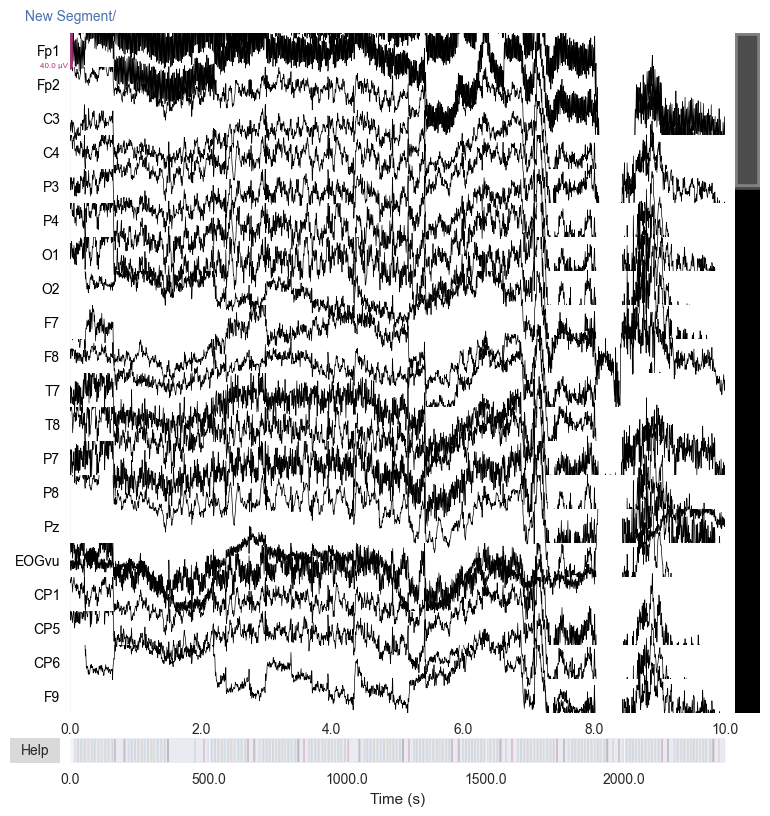

Channels marked as bad:
none


In [389]:
s6_2_raw.plot()

In [246]:
scores_overview(scores_6_2, 's6_2')

In [240]:
scores_6_2 = scores_6_2['final_label'].to_numpy()
scores_6_2 = {"emg1": scores_6_2.copy(), "emg2": scores_6_2.copy(), "emg3": scores_6_2.copy(), "accel": scores_6_2.copy(), "pulse": scores_6_2.copy()}

In [241]:
s6_2_emg1_raw = s6_2_raw.copy().pick_channels(['x_EMG_1'])
s6_2_emg2_raw = s6_2_raw.copy().pick_channels(['x_EMG_2'])
s6_2_emg3_raw = s6_2_raw.copy().pick_channels(['x_EMG_3'])
s6_2_accel_raw = s6_2_raw.copy().pick_channels(['x_accel'])
s6_2_pulse_raw = s6_2_raw.copy().pick_channels(['x_Pulse'])

In [242]:
#Preprocessing the data
scaling_emg = dict(eeg=20e-5)
scaling_pulse = dict(eeg=20e-2)

s6_2_emg1 = filtering(s6_2_emg1_raw, scaling_emg, 'emg', 's6_2', lfreq = 10)
s6_2_emg2 = filtering(s6_2_emg2_raw, scaling_emg, 'emg', 's6_2', lfreq = 10)
s6_2_emg3 = filtering(s6_2_emg3_raw, scaling_emg, 'emg', 's6_2', lfreq = 10)

s6_2_accel = filtering(s6_2_accel_raw, scaling_emg, 'accel', 's6_2', lfreq = 2, hfreq = 15)

s6_2_pulse = filtering(s6_2_pulse_raw, scaling_pulse, 'pulse', 's6_2', lfreq = 0.5, hfreq = 12)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 12 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (f

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Filtering raw data in 12 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 Hz: -6.02 dB

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 12 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and re

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Filtering raw data in 12 contiguous segments
Setting up band-pass filter from 0.5 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 12.00 Hz: -6.02, -6.02 dB



In [243]:
#Epoching the signal
s6_2_emg1_e = epoching(s6_2_emg1, ['x_EMG_1'], scaling_emg, 's6_2', 'emg1')
s6_2_emg2_e = epoching(s6_2_emg2, ['x_EMG_2'], scaling_emg, 's6_2', 'emg2')
s6_2_emg3_e = epoching(s6_2_emg3, ['x_EMG_3'], scaling_emg, 's6_2', 'emg3')

s6_2_accel_e = epoching(s6_2_accel, ['x_accel'], scaling_emg, 's6_2', 'accel')

s6_2_pulse_e = epoching(s6_2_pulse, ['x_Pulse'], scaling_pulse, 's6_2', 'pulse')

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S100', 'Stimulus/S105', 'Stimulus/S110', 'Stimulus/S115', 'Stimulus/S120', 'Stimulus/S125', 'Stimulus/S130', 'Stimulus/S135', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 'Stimulus/S204', 'Stimulus/S205', 'Stimulus/S206', 'Stimulus/S251', 'Stimulus/S255']
Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 144 events and 1201 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S100', 'Stimulus/S105', 'Stimulus/S110', 'Stimulus/S115', 'Stimulus/S120', 'Stimulus/S125', 'Stimulus/S130', 'Stimulus/S135', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 

In [244]:
s6_2_data_points = len(s6_2_emg1_e)
s6_2_num_blocks= s6_2_data_points/12
s6_2_block_sizes = [12 for _ in range(int(s6_2_num_blocks))]
s6_2_block_sizes = {"emg1": s6_2_block_sizes.copy(), "emg2": s6_2_block_sizes.copy(), "emg3": s6_2_block_sizes.copy(), "accel": s6_2_block_sizes.copy(), "pulse": s6_2_block_sizes.copy()}

In [ ]:
#Pulse signal is either dead, or would indicate a heart rate of 240 BPM, which is unrealistically high, so will not be used.
#EMG2 will also not be used, due to being completely saturated

In [245]:
#Deleting the outlier scores
s6_2_block_sizes["emg1"], stim_s6_2["emg1"], scores_6_2['emg1'] = delete_point([96], scores_6_2["emg1"], s6_2_block_sizes["emg1"], 12, stim_s6_2["emg1"])
s6_2_emg1_e.drop(96)

s6_2_block_sizes["emg3"], stim_s6_2["emg3"], scores_6_2['emg3'] = delete_point([96], scores_6_2["emg3"], s6_2_block_sizes["emg3"], 12, stim_s6_2["emg3"])
s6_2_emg3_e.drop(96)

s6_2_block_sizes["accel"], stim_s6_2["accel"], scores_6_2['accel'] = delete_point([96], scores_6_2["accel"], s6_2_block_sizes["accel"], 12, stim_s6_2["accel"])
s6_2_accel_e.drop(96)


Dropped 1 epoch: 96
Dropped 1 epoch: 96
Dropped 1 epoch: 96


<Epochs |  143 events (all good), 0 - 6 sec, baseline off, ~1.3 MB, data loaded,
 '2': 24
 '3': 24
 '4': 24
 '5': 24
 '6': 24
 '7': 23>

In [246]:
#Extracting features of the signals
s6_2_emg1_time, s6_2_emg1_freq, s6_2_emg1_timenames, s6_2_emg1_freqnames = features_emg(s6_2_emg1_e)
s6_2_emg3_time, s6_2_emg3_freq, s6_2_emg3_timenames, s6_2_emg3_freqnames = features_emg(s6_2_emg3_e)

s6_2_accel_time, s6_2_accel_freq, s6_2_accel_timenames, s6_2_accel_freqnames = features_accel(s6_2_accel_e)

s6_2_timenames= {"emg1": np.array(s6_2_emg1_timenames), "emg3": np.array(s6_2_emg3_timenames), "accel": s6_2_accel_timenames}
s6_2_freqnames= {"emg1": np.array(s6_2_emg1_freqnames), "emg3": np.array(s6_2_emg3_freqnames), "accel": s6_2_accel_freqnames}

In [254]:
#Visualizing all the features
plot_features(s6_2_emg1_time, s6_2_emg1_freq, s6_2_timenames["emg1"], s6_2_freqnames["emg1"], scores_6_2["emg1"], stim_s6_2["emg1"])

In [247]:
s6_2_emg1_normal = ["ZC", "MNF", "PR", "SEF"]
s6_2_emg1_remove = outlier_rejection(s6_2_emg1_time, s6_2_emg1_freq, s6_2_timenames["emg1"], s6_2_freqnames["emg1"], s6_2_emg1_normal)
s6_2_emg1_time, s6_2_emg1_freq, s6_2_block_sizes["emg1"], stim_s6_2["emg1"], scores_6_2["emg1"]  = delete_point(s6_2_emg1_remove, scores_6_2["emg1"], s6_2_block_sizes["emg1"], 12, stim_s6_2["emg1"], s6_2_emg1_time, s6_2_emg1_freq)

In [256]:
#Visualizing all the features
plot_features(s6_2_emg3_time, s6_2_emg3_freq, s6_2_timenames["emg3"], s6_2_freqnames["emg3"], scores_6_2["emg3"], stim_s6_2["emg3"])

In [248]:
s6_2_emg3_normal = ["MAV", "STD", "WL", "MPV", "DAMV", "MFL", "IAV", "DASDV", "ZC", "SSC", "MNF", "PR", "SEF"]
s6_2_emg3_remove = outlier_rejection(s6_2_emg3_time, s6_2_emg3_freq, s6_2_timenames["emg3"], s6_2_freqnames["emg3"], s6_2_emg3_normal)
s6_2_emg3_time, s6_2_emg3_freq, s6_2_block_sizes["emg3"], stim_s6_2["emg3"], scores_6_2["emg3"]  = delete_point(s6_2_emg3_remove, scores_6_2["emg3"], s6_2_block_sizes["emg3"], 12, stim_s6_2["emg3"], s6_2_emg3_time, s6_2_emg3_freq)

In [258]:
#Visualizing all the features
plot_features(s6_2_accel_time, s6_2_accel_freq, s6_2_timenames["accel"], s6_2_freqnames["accel"], scores_6_2["accel"], stim_s6_2["accel"])

In [249]:
s6_2_accel_normal = ["MA"]
s6_2_accel_remove = outlier_rejection(s6_2_accel_time, s6_2_accel_freq, s6_2_timenames["accel"], s6_2_freqnames["accel"], s6_2_accel_normal)
s6_2_accel_time, s6_2_accel_freq, s6_2_block_sizes["accel"], stim_s6_2["accel"], scores_6_2["accel"]  = delete_point(s6_2_accel_remove, scores_6_2["accel"], s6_2_block_sizes["accel"], 12, stim_s6_2["accel"], s6_2_accel_time, s6_2_accel_freq)

In [250]:
s6_2_feat_time = {"emg1": s6_2_emg1_time.copy(), "emg3": s6_2_emg3_time.copy(), "accel": s6_2_accel_time.copy()}
s6_2_feat_freq = {"emg1": s6_2_emg1_freq.copy(), "emg3": s6_2_emg3_freq.copy(), "accel": s6_2_accel_freq.copy()}
s6_2_feat = {"emg1": np.concatenate((s6_2_feat_time['emg1'], s6_2_feat_freq['emg1'])),
             "emg3": np.concatenate((s6_2_feat_time['emg3'], s6_2_feat_freq['emg3'])),
             "accel": np.concatenate((s6_2_feat_time['accel'], s6_2_feat_freq['accel'])),
            }
s6_2_names = {"emg1": np.concatenate((s6_2_timenames['emg1'], s6_2_freqnames['emg1'])),  
             "emg3": np.concatenate((s6_2_timenames['emg3'], s6_2_freqnames['emg3'])),
             "accel": np.concatenate((s6_2_timenames['accel'], s6_2_freqnames['accel'])),
            }

In [251]:
s6_2_featFS_time = {"emg1": s6_2_emg1_time.copy(), "emg3": s6_2_emg3_time.copy(), "accel": s6_2_accel_time.copy()}
s6_2_featFS_freq = {"emg1": s6_2_emg1_freq.copy(), "emg3": s6_2_emg3_freq.copy(), "accel": s6_2_accel_freq.copy()}
s6_2_featFS = {"emg1": np.concatenate((s6_2_featFS_time['emg1'], s6_2_featFS_freq['emg1'])),
             "emg3": np.concatenate((s6_2_featFS_time['emg3'], s6_2_featFS_freq['emg3'])),
             "accel": np.concatenate((s6_2_featFS_time['accel'], s6_2_featFS_freq['accel'])),
            }
s6_2_FSnames = {"emg1": np.concatenate((s6_2_timenames['emg1'], s6_2_freqnames['emg1'])),  
             "emg3": np.concatenate((s6_2_timenames['emg3'], s6_2_freqnames['emg3'])),
             "accel": np.concatenate((s6_2_timenames['accel'], s6_2_freqnames['accel'])),
            }

In [264]:
#Plotting the relations between the time-domain features
feature_relations(s6_2_feat["emg3"], s6_2_names["emg3"], scores_6_2["emg3"], stim_s6_2["emg3"])

In [252]:
#For EMG1:
s6_2_feat["emg1"] = np.delete(s6_2_feat["emg1"], (1,2,3,4,5,6,7,10,14), 0)
s6_2_names["emg1"] = np.delete(s6_2_names["emg1"], (1,2,3,4,5,6,7,10,14))

#For EMG3:
s6_2_feat["emg3"] = np.delete(s6_2_feat["emg3"], (1,2,3,4,5,6,7,14), 0)
s6_2_names["emg3"] = np.delete(s6_2_names["emg3"], (1,2,3,4,5,6,7,14))

#For Accel:
s6_2_feat["accel"] = np.delete(s6_2_feat["accel"], (1,3,4,5,7), 0)
s6_2_names["accel"] = np.delete(s6_2_names["accel"], (1,3,4,5,7))

In [253]:
s6_2_block_sizes["emg1"] = np.array(s6_2_block_sizes["emg1"])
s6_2_block_sizes["emg1"] = s6_2_block_sizes["emg1"][s6_2_block_sizes["emg1"]  > 0]

s6_2_block_sizes["emg3"] = np.array(s6_2_block_sizes["emg3"])
s6_2_block_sizes["emg3"] = s6_2_block_sizes["emg3"][s6_2_block_sizes["emg3"]  > 0]

s6_2_block_sizes["accel"] = np.array(s6_2_block_sizes["accel"])
s6_2_block_sizes["accel"] = s6_2_block_sizes["accel"][s6_2_block_sizes["accel"]  > 0]

In [254]:
s6_2_nr_fold = {"emg1": len(s6_2_block_sizes["emg1"])//2, "emg3": len(s6_2_block_sizes["emg3"])//2, "accel": len(s6_2_block_sizes["accel"])//2}

In [305]:
#Classification
s6_2_pvals_class = {"emg1": np.zeros(2), "emg3": np.zeros(2), "accel": np.zeros(2)}
s6_2_bootstraps_class = {"emg1": [], "emg3": [], "accel": []}
s6_2_accuracies = {"emg1": np.zeros(2), "emg3": np.zeros(2), "accel": np.zeros(2)}
s6_2_weights_class = {"emg1": [], "emg3": [], "accel": []}
s6_2_features_class = {}

for X in s6_2_feat:
    print("Patient 6 - Session 2, " + X + ":")
    logreg_acc1, weights1 = DBS_classification(s6_2_feat[X].T, stim_s6_2[X], s6_2_nr_fold[X], s6_2_block_sizes[X])
    print("Average accuracy of the MFS + Logistic Regression: " + str(round(logreg_acc1,4)))
    s6_2_weights_class[X].append(np.abs(np.mean(weights1, axis=0)))
    s6_2_accuracies[X][0] = logreg_acc1
    
    chance_level_class1, bootstraps_class1 = chance_level_classification(s6_2_feat[X].T, stim_s6_2[X], s6_2_nr_fold[X], s6_2_block_sizes[X])
    print("The chance level of the accuracy of the MFS + Logistic Regression: " + str(round(chance_level_class1,4)))
    s6_2_bootstraps_class[X].append(bootstraps_class1)
    
    s6_2_pvals_class[X][0] = p_value(logreg_acc1, bootstraps_class1, 'classification')
    
    
    X_fea = s6_2_featFS[X].copy().T
    selected_features = mrmr(X_fea, stim_s6_2[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s6_2_features_class[X] = selected_features
    
    logreg_acc2, weights2 = DBS_classification(X_fea, stim_s6_2[X], s6_2_nr_fold[X], s6_2_block_sizes[X])
    print("Average accuracy of the Logistic Regression with MRMR: " + str(round(logreg_acc2,4)))
    s6_2_weights_class[X].append(np.abs(np.mean(weights2, axis=0)))
    s6_2_accuracies[X][1] = logreg_acc2

    #Estimating the chance level of the classification
    chance_level_class2, bootstraps_class2 = chance_level_classification(s6_2_featFS[X].T, stim_s6_2[X], s6_2_nr_fold[X], s6_2_block_sizes[X], MRMR=True)
    print("The chance level of the accuracy of the Logistic Regression with MRMR: " + str(round(chance_level_class2,4)))
    s6_2_bootstraps_class[X].append(bootstraps_class2)
    
    s6_2_pvals_class[X][1] = p_value(logreg_acc2, bootstraps_class2, 'classification')
    
    print("--------------------------")

Patient 6 - Session 2, emg1:
Average accuracy of the MFS + Logistic Regression: 0.5445
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression: 0.4871
Indices of the selected features: [14, 11]
Average accuracy of the Logistic Regression with MRMR: 0.6635
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the Logistic Regression with MRMR: 0.4809
--------------------------
Patient 6 - Session 2, emg3:
Average accuracy of the MFS + Logistic Regression: 0.7199
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression

In [ ]:
for sig in s6_2_bootstraps_class:
    plotCI_class(s6_2_bootstraps_class[sig][0], s6_2_bootstraps_class[sig][1],
                 s6_2_accuracies[sig][0], s6_2_accuracies[sig][1], "s6_2", sig)

In [344]:
s6_2_sign_class = {'emg1': np.zeros(2), 'emg3': np.zeros(2), 'accel': np.zeros(2)}
for sig in s6_2_pvals_class:
    print("P-value, MFS + Logistic Regression " + sig + ": " + str(s6_2_pvals_class[sig][0]))
    print("P-value, MRMR + Logistic Regression " + sig + ": " + str(s6_2_pvals_class[sig][1]))
    print()
    corrected_pvals = bonferroni_holm(s6_2_pvals_class[sig])
    print("Corrected P-value, MFS + Logistic Regression  " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + Logistic Regression  " + sig + ": " + str(corrected_pvals[1]))
    print()
    if (corrected_pvals[0] < 0.05):
        s6_2_sign_class[sig][0] = True
        print("For " + sig + ", MFS + Logistic Regression  is significant")
    else:
        s6_2_sign_class[sig][0] = False
        print("For " + sig + ", MFS + Logistic Regression  is not significant")

    if (corrected_pvals[1] < 0.05):
        s6_2_sign_class[sig][1] = True
        print("For " + sig + ", MRMR + Logistic Regression  is significant")
    else:
        s6_2_sign_class[sig][1] = False
        print("For " + sig + ", MRMR + Logistic Regression  is not significant")
    print("-----------------------------------------")

P-value, MFS + Logistic Regression emg1: 0.14485514485514486
P-value, MRMR + Logistic Regression emg1: 0.000999000999000999

Corrected P-value, MFS + Logistic Regression  emg1: 0.14485514485514486
Corrected P-value, MRMR + Logistic Regression  emg1: 0.001998001998001998

For emg1, MFS + Logistic Regression  is not significant
For emg1, MRMR + Logistic Regression  is significant
-----------------------------------------
P-value, MFS + Logistic Regression emg3: 0.000999000999000999
P-value, MRMR + Logistic Regression emg3: 0.000999000999000999

Corrected P-value, MFS + Logistic Regression  emg3: 0.001998001998001998
Corrected P-value, MRMR + Logistic Regression  emg3: 0.001998001998001998

For emg3, MFS + Logistic Regression  is significant
For emg3, MRMR + Logistic Regression  is significant
-----------------------------------------
P-value, MFS + Logistic Regression accel: 0.08091908091908091
P-value, MRMR + Logistic Regression accel: 0.09090909090909091

Corrected P-value, MFS + Logis

In [445]:
#Show weights and show cross-correlations
for sig in s6_2_feat:  
    plot_weights_class(s6_2_feat[sig], s6_2_weights_class[sig][0], s6_2_weights_class[sig][1],
                       s6_2_names[sig], s6_2_FSnames[sig],
                         s6_2_features_class[sig], "s6_2", sig)

In [270]:
nested_CV(s6_2_feat["emg3"].T, scores_6_2["emg3"], s6_2_nr_fold["emg3"], s6_2_block_sizes["emg3"])

In [306]:
#Regression
s6_2_alpha = {"emg1": 21, "emg3": 20, "accel": 20}
s6_2_pvals_reg = {"emg1": np.zeros(3), "emg3": np.zeros(3), "accel": np.zeros(3)}
s6_2_weights = {"emg1": [], "emg3": [], "accel": []}
s6_2_bootstraps_reg = {"emg1": [], "emg3": [], "accel": []}
s6_2_corrs = {"emg1": np.zeros(3), "emg3": np.zeros(3), "accel": np.zeros(3)}
s6_2_features = {}

for X in s6_2_feat:
    print("Patient 6 - Session 2, " + X + ":")
    corr_CV1, weights1 = motor_regression(s6_2_feat[X].T, scores_6_2[X], s6_2_nr_fold[X], s6_2_block_sizes[X])
    print("The average correlation of MFS + LR is: " + str(round(corr_CV1, 4)))
    s6_2_weights[X].append(np.abs(np.mean(weights1, axis=0)[1:]))
    s6_2_corrs[X][0] = corr_CV1
    
    chance_level_reg1, bootstraps_reg1 = chance_level_regression(s6_2_feat[X].T, scores_6_2[X], s6_2_nr_fold[X], s6_2_block_sizes[X])
    print("The chance level of the correlation of MFS + LR: " + str(round(chance_level_reg1,4)))
    s6_2_pvals_reg[X][0] = p_value(corr_CV1, bootstraps_reg1, 'regression')
    s6_2_bootstraps_reg[X].append(bootstraps_reg1)
    
    
    X_fea = s6_2_featFS[X].copy().T
    selected_features = mrmr(X_fea, scores_6_2[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s6_2_features[X] = selected_features
    
    corr_CV2, weights2 = motor_regression(X_fea, scores_6_2[X], s6_2_nr_fold[X], s6_2_block_sizes[X])
    print("The average correlation of MRMR + LR is: " + str(round(corr_CV2, 4)))
    s6_2_weights[X].append(np.abs(np.mean(weights2, axis=0)[1:]))
    s6_2_corrs[X][1] = corr_CV2

    chance_level_reg2, bootstraps_reg2 = chance_level_regression(s6_2_featFS[X].T, scores_6_2[X], s6_2_nr_fold[X], s6_2_block_sizes[X], MRMR=True)
    print("The chance level of the correlation of MRMR + LR: " + str(round(chance_level_reg2,4)))
    s6_2_pvals_reg[X][1] = p_value(corr_CV2, bootstraps_reg2, 'regression')
    s6_2_bootstraps_reg[X].append(bootstraps_reg2)
    
    
    corr_CV3, weights3 = motor_regression(s6_2_feat[X].T, scores_6_2[X], s6_2_nr_fold[X], s6_2_block_sizes[X], Lasso=True, l1_penalty=s6_2_alpha[X])
    print("The average correlation of MFS + Lasso Regression is: " + str(round(corr_CV3, 4)))
    s6_2_weights[X].append(np.abs(np.mean(weights3, axis=0)[1:]))
    s6_2_corrs[X][2] = corr_CV3

    chance_level_reg3, bootstraps_reg3 = chance_level_regression(s6_2_feat[X].T, scores_6_2[X], s6_2_nr_fold[X], s6_2_block_sizes[X], Lasso=True, l1_penalty=s6_2_alpha[X])
    print("The chance level of the correlation of MFS + Lasso Regression: " + str(round(chance_level_reg3,4)))
    s6_2_pvals_reg[X][2] = p_value(corr_CV3, bootstraps_reg3, 'regression')
    s6_2_bootstraps_reg[X].append(bootstraps_reg3)
    
    print("--------------------------")

Patient 6 - Session 2, emg1:
The average correlation of MFS + LR is: 0.4075
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + LR: -0.0036
Indices of the selected features: [0, 11]
The average correlation of MRMR + LR is: 0.4702
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MRMR + LR: 0.001
The average correlation of MFS + Lasso Regression is: 0.4956
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + Lasso Regression: -0.0028
--------------------------
Patient 6 - Session 2, emg3:
The average correlation of MFS + LR is: 0.2188
Progress:

In [ ]:
for sig in s6_2_bootstraps_reg:
    plotCI_reg(s6_2_bootstraps_reg[sig][0], s6_2_bootstraps_reg[sig][1], s6_2_bootstraps_reg[sig][2],
               s6_2_corrs[sig][0], s6_2_corrs[sig][1], s6_2_corrs[sig][2], "s6_2", sig)

In [341]:
s6_2_sign_reg = {'emg1': np.zeros(3), 'emg3': np.zeros(3), 'accel': np.zeros(3)}
for sig in s6_2_pvals_reg:
    print("P-value, MFS + LR " + sig + ": " + str(s6_2_pvals_reg[sig][0]))
    print("P-value, MRMR + LR " + sig + ": " + str(s6_2_pvals_reg[sig][1]))
    print("P-value, MFS + Lasso Regression " + sig + ": " + str(s6_2_pvals_reg[sig][2]))
    print()
    corrected_pvals = bonferroni_holm(s6_2_pvals_reg[sig])
    print("Corrected P-value, MFS + LR " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + LR " + sig + ": " + str(corrected_pvals[1]))
    print("Corrected P-value, MFS + Lasso Regression " + sig + ": " + str(corrected_pvals[2]))
    print()
    
    if (corrected_pvals[0] < 0.05):
        s6_2_sign_reg[sig][0] = True
        print("For " + sig + ", MFS + LR is significant")
    else:
        s6_2_sign_reg[sig][0] = False
        print("For " + sig + ", MFS + LR is not significant")

    if (corrected_pvals[1] < 0.05):
        s6_2_sign_reg[sig][1] = True
        print("For " + sig + ", MRMR + LR is significant")
    else:
        s6_2_sign_reg[sig][1] = False
        print("For " + sig + ", MRMR + LR is not significant")
        
    if (corrected_pvals[2] < 0.05):
        s6_2_sign_reg[sig][2] = True
        print("For " + sig + ", MFS + Lasso Regression is significant")
    else:
        s6_2_sign_reg[sig][2] = False
        print("For " + sig + ", MFS + Lasso Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + LR emg1: 0.001998001998001998
P-value, MRMR + LR emg1: 0.001998001998001998
P-value, MFS + Lasso Regression emg1: 0.001998001998001998

Corrected P-value, MFS + LR emg1: 0.005994005994005994
Corrected P-value, MRMR + LR emg1: 0.005994005994005994
Corrected P-value, MFS + Lasso Regression emg1: 0.005994005994005994

For emg1, MFS + LR is significant
For emg1, MRMR + LR is significant
For emg1, MFS + Lasso Regression is significant
-----------------------------------------
P-value, MFS + LR emg3: 0.059940059940059943
P-value, MRMR + LR emg3: 0.03196803196803197
P-value, MFS + Lasso Regression emg3: 0.007992007992007992

Corrected P-value, MFS + LR emg3: 0.06393606393606394
Corrected P-value, MRMR + LR emg3: 0.06393606393606394
Corrected P-value, MFS + Lasso Regression emg3: 0.023976023976023976

For emg3, MFS + LR is not significant
For emg3, MRMR + LR is not significant
For emg3, MFS + Lasso Regression is significant
-----------------------------------------
P-value, MFS 

In [805]:
#Show weights and show cross-correlations
for sig in s6_2_feat:  
    plot_weights_reg(s6_2_feat[sig], s6_2_weights[sig][0], s6_2_weights[sig][1],
                 s6_2_weights[sig][2], s6_2_names[sig], s6_2_FSnames[sig],
                 s6_2_features[sig], "s6_2", sig)

## Session 6.C

In [726]:
#Loading the data
s6_c_raw, scores_6_c, stim_s6_c = load_data("s6_c")
stim_s6_c = {"emg1": stim_s6_c.copy(), "emg2": stim_s6_c.copy(), "emg3": stim_s6_c.copy(), "emg4": stim_s6_c.copy(), "pulse": stim_s6_c.copy(), "accel": stim_s6_c.copy()}

Opening raw data file C:\Users\jesse\Documents\AI_ThirdYear\Thesis\s6_c\full_raw.fif...
Isotrak not found
    Range : 0 ... 634895 =      0.000 ...  3174.475 secs
Ready.
Reading 0 ... 634895  =      0.000 ...  3174.475 secs...


In [280]:
scores_overview(scores_6_c, 's6_c')

In [727]:
scores_6_c = scores_6_c['final_label'].to_numpy()
scores_6_c = {"emg1": scores_6_c.copy(), "emg2": scores_6_c.copy(), "emg3": scores_6_c.copy(), "emg4": scores_6_c.copy(), "pulse": scores_6_c.copy(), "accel": scores_6_c.copy()}

In [728]:
s6_c_emg1_raw = s6_c_raw.copy().pick_channels(['x_EMG1'])
s6_c_emg2_raw = s6_c_raw.copy().pick_channels(['x_EMG2'])
s6_c_emg3_raw = s6_c_raw.copy().pick_channels(['x_EMG3'])
s6_c_emg4_raw = s6_c_raw.copy().pick_channels(['x_EMG4'])
s6_c_pulse_raw = s6_c_raw.copy().pick_channels(['x_pulse'])
s6_c_accel_raw = s6_c_raw.copy().pick_channels(['x_accel'])

In [729]:
#Preprocessing the data
scaling_emg = dict(eeg=20e-5)
scaling_pulse = dict(eeg=20e-2)
scaling_accel = dict(eeg=20e-2)

s6_c_emg1 = filtering(s6_c_emg1_raw, scaling_emg, 'emg1', 's6_c', lfreq = 10)
s6_c_emg2 = filtering(s6_c_emg2_raw, scaling_emg, 'emg2', 's6_c', lfreq = 10)
s6_c_emg3 = filtering(s6_c_emg3_raw, scaling_emg, 'emg3', 's6_c', lfreq = 10)
s6_c_emg4 = filtering(s6_c_emg4_raw, scaling_emg, 'emg4', 's6_c', lfreq = 10)

s6_c_pulse = filtering(s6_c_pulse_raw, scaling_pulse, 'pulse', 's6_c', lfreq = 0.5, hfreq = 12)

s6_c_accel = filtering(s6_c_accel_raw, scaling_accel, 'accel', 's6_c', lfreq = 2, hfreq = 15)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 16 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 16 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 16 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 16 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Filtering raw data in 16 contiguous segments
Setting up band-pass filter from 0.5 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 12.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

C:\Users\jesse\anaconda3\lib\site-packages\mne\viz\_mpl_figure.py:2145: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Filtering raw data in 16 contiguous segments
Setting up band-pass filter from 2 - 15 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 2.00, 15.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [730]:
#Epoching the signal
s6_c_emg1_e = epoching(s6_c_emg1, ['x_EMG1'], scaling_emg, 's6_c', 'emg1')
s6_c_emg2_e = epoching(s6_c_emg2, ['x_EMG2'], scaling_emg, 's6_c', 'emg2')
s6_c_emg3_e = epoching(s6_c_emg3, ['x_EMG3'], scaling_emg, 's6_c', 'emg3')
s6_c_emg4_e = epoching(s6_c_emg4, ['x_EMG4'], scaling_emg, 's6_c', 'emg4')

s6_c_accel_e = epoching(s6_c_accel, ['x_accel'], scaling_accel, 's6_c', 'accel')

s6_c_pulse_e = epoching(s6_c_pulse, ['x_pulse'], scaling_pulse, 's6_c', 'pulse')

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 'Stimulus/S204', 'Stimulus/S205', 'Stimulus/S206', 'Stimulus/S210', 'Stimulus/S251', 'Stimulus/S255']
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 192 events and 1201 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 'Stimulus/S204', 'Stimulus/S205', 'Stimulus/S206', 'Stimulus/S210', 'Stimulus/S251', 'Stimulus/S255']
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 192 events a

In [731]:
s6_c_data_points = len(s6_c_emg1_e)
s6_c_num_blocks= s6_c_data_points/12
s6_c_block_sizes = [12 for _ in range(int(s6_c_num_blocks))]
s6_c_block_sizes = {"emg1": s6_c_block_sizes.copy(), "emg2": s6_c_block_sizes.copy(), "emg3": s6_c_block_sizes.copy(), "emg4": s6_c_block_sizes.copy(), "accel": s6_c_block_sizes.copy()}

In [ ]:
#Pulse: don't use because big parts of the signal are saturated
#Accel: also looks quite saturated, but still try to use it

In [732]:
s6_c_emg4_del1 = np.arange(77,84,1)
s6_c_emg4_del2 = np.arange(162,168,1)
s6_c_emg4_del3 = np.arange(183,len(s6_c_emg4_e),1)
s6_c_emg4_del = np.concatenate((s6_c_emg4_del1, s6_c_emg4_del1, s6_c_emg4_del1))

s6_c_block_sizes["emg4"], stim_s6_c["emg4"], scores_6_c['emg4'] = delete_point(s6_c_emg4_del, scores_6_c["emg4"], s6_c_block_sizes["emg4"], 12, stim_s6_c["emg4"])
    
s6_c_emg4_e.drop(s6_c_emg4_del)

Dropped 21 epochs: 77, 77, 77, 78, 78, 78, 79, 79, 79, 80, 80, 80, 81, 81, 81, 82, 82, 82, 83, 83, 83


<Epochs |  185 events (all good), 0 - 6 sec, baseline off, ~1.7 MB, data loaded,
 '2': 31
 '3': 31
 '4': 31
 '5': 30
 '6': 31
 '7': 31>

In [734]:
#Deleting the outlier scores
s6_c_block_sizes["emg1"], stim_s6_c["emg1"], scores_6_c['emg1'] = delete_point([156], scores_6_c["emg1"], s6_c_block_sizes["emg1"], 12, stim_s6_c["emg1"])
s6_c_emg1_e.drop(156)

s6_c_block_sizes["emg2"], stim_s6_c["emg2"], scores_6_c['emg2'] = delete_point([156], scores_6_c["emg2"], s6_c_block_sizes["emg2"], 12, stim_s6_c["emg2"])
s6_c_emg2_e.drop(156)

s6_c_block_sizes["emg3"], stim_s6_c["emg3"], scores_6_c['emg3'] = delete_point([156], scores_6_c["emg3"], s6_c_block_sizes["emg3"], 12, stim_s6_c["emg3"])
s6_c_emg3_e.drop(156)

s6_c_block_sizes["emg4"], stim_s6_c["emg4"], scores_6_c['emg4'] = delete_point([156], scores_6_c["emg4"], s6_c_block_sizes["emg4"], 12, stim_s6_c["emg4"])
s6_c_emg4_e.drop(156)

s6_c_block_sizes["accel"], stim_s6_c["accel"], scores_6_c['accel'] = delete_point([156], scores_6_c["accel"], s6_c_block_sizes["accel"], 12, stim_s6_c["accel"])
s6_c_accel_e.drop(156)


Dropped 1 epoch: 156
Dropped 1 epoch: 156
Dropped 1 epoch: 156
Dropped 1 epoch: 156


<Epochs |  191 events (all good), 0 - 6 sec, baseline off, ~1.8 MB, data loaded,
 '2': 32
 '3': 32
 '4': 32
 '5': 32
 '6': 32
 '7': 31>

In [735]:
#Extracting features of the signals
s6_c_emg1_time, s6_c_emg1_freq, s6_c_emg1_timenames, s6_c_emg1_freqnames = features_emg(s6_c_emg1_e)
s6_c_emg2_time, s6_c_emg2_freq, s6_c_emg2_timenames, s6_c_emg2_freqnames = features_emg(s6_c_emg2_e)
s6_c_emg3_time, s6_c_emg3_freq, s6_c_emg3_timenames, s6_c_emg3_freqnames = features_emg(s6_c_emg3_e)
s6_c_emg4_time, s6_c_emg4_freq, s6_c_emg4_timenames, s6_c_emg4_freqnames = features_emg(s6_c_emg4_e)

s6_c_accel_time, s6_c_accel_freq, s6_c_accel_timenames, s6_c_accel_freqnames = features_accel(s6_c_accel_e)

s6_c_timenames= {"emg1": np.array(s6_c_emg1_timenames), "emg2": np.array(s6_c_emg2_timenames), "emg3": np.array(s6_c_emg3_timenames), "emg4": s6_c_emg4_timenames, "accel": np.array(s6_c_accel_timenames)}
s6_c_freqnames= {"emg1": np.array(s6_c_emg1_freqnames), "emg2": np.array(s6_c_emg2_freqnames), "emg3": np.array(s6_c_emg3_freqnames), "emg4": s6_c_emg4_freqnames, "accel": np.array(s6_c_accel_freqnames)}

In [289]:
#Visualizing all the features
plot_features(s6_c_emg1_time, s6_c_emg1_freq, s6_c_timenames["emg1"], s6_c_freqnames["emg1"], scores_6_c["emg1"], stim_s6_c["emg1"])

In [736]:
s6_c_emg1_normal = ["MAV", "STD", "WL", "MPV", "DAMV", "IAV" "MFL", "DASDV", "SSC"]
s6_c_emg1_remove = outlier_rejection(s6_c_emg1_time, s6_c_emg1_freq, s6_c_timenames["emg1"], s6_c_freqnames["emg1"], s6_c_emg1_normal)
s6_c_emg1_time, s6_c_emg1_freq, s6_c_block_sizes["emg1"], stim_s6_c["emg1"], scores_6_c["emg1"]  = delete_point(s6_c_emg1_remove, scores_6_c["emg1"], s6_c_block_sizes["emg1"], 12, stim_s6_c["emg1"], s6_c_emg1_time, s6_c_emg1_freq)

In [737]:
#Visualizing all the features
plot_features(s6_c_emg2_time, s6_c_emg2_freq, s6_c_timenames["emg2"], s6_c_freqnames["emg2"], scores_6_c["emg2"], stim_s6_c["emg2"])

In [738]:
s6_c_emg2_normal = ["MAV", "STD", "WL", "MPV", "DAMV", "MFL", "IAV", "DASDV", "ZC", "SSC", "MNF", "SEF"]
s6_c_emg2_remove = outlier_rejection(s6_c_emg2_time, s6_c_emg2_freq, s6_c_timenames["emg2"], s6_c_freqnames["emg2"], s6_c_emg2_normal)
s6_c_emg2_time, s6_c_emg2_freq, s6_c_block_sizes["emg2"], stim_s6_c["emg2"], scores_6_c["emg2"]  = delete_point(s6_c_emg2_remove, scores_6_c["emg2"], s6_c_block_sizes["emg2"], 12, stim_s6_c["emg2"], s6_c_emg2_time, s6_c_emg2_freq)

In [293]:
#Visualizing all the features
plot_features(s6_c_emg3_time, s6_c_emg3_freq, s6_c_timenames["emg3"], s6_c_freqnames["emg3"], scores_6_c["emg3"], stim_s6_c["emg3"])

In [739]:
s6_c_emg3_normal = ["WL", "DAMV", "MFL", "SSC"]
s6_c_emg3_remove = outlier_rejection(s6_c_emg3_time, s6_c_emg3_freq, s6_c_timenames["emg3"], s6_c_freqnames["emg3"], s6_c_emg3_normal)
s6_c_emg3_time, s6_c_emg3_freq, s6_c_block_sizes["emg3"], stim_s6_c["emg3"], scores_6_c["emg3"]  = delete_point(s6_c_emg3_remove, scores_6_c["emg3"], s6_c_block_sizes["emg3"], 12, stim_s6_c["emg3"], s6_c_emg3_time, s6_c_emg3_freq)

In [295]:
#Visualizing all the features
plot_features(s6_c_emg4_time, s6_c_emg4_freq, s6_c_timenames["emg4"], s6_c_freqnames["emg4"], scores_6_c["emg4"], stim_s6_c["emg4"])

In [740]:
s6_c_emg4_normal = ["PKF"]
s6_c_emg4_remove = outlier_rejection(s6_c_emg4_time, s6_c_emg4_freq, s6_c_timenames["emg4"], s6_c_freqnames["emg4"], s6_c_emg4_normal)
s6_c_emg4_time, s6_c_emg4_freq, s6_c_block_sizes["emg4"], stim_s6_c["emg4"], scores_6_c["emg4"]  = delete_point(s6_c_emg4_remove, scores_6_c["emg4"], s6_c_block_sizes["emg4"], 12, stim_s6_c["emg4"], s6_c_emg4_time, s6_c_emg4_freq)

In [317]:
#Visualizing all the features
plot_features(s6_c_accel_time, s6_c_accel_freq, s6_c_timenames["accel"], s6_c_freqnames["accel"], scores_6_c["accel"], stim_s6_c["accel"])

In [741]:
s6_c_accel_normal = ["MA"]
s6_c_accel_remove = outlier_rejection(s6_c_accel_time, s6_c_accel_freq, s6_c_timenames["accel"], s6_c_freqnames["accel"], s6_c_accel_normal)
s6_c_accel_time, s6_c_accel_freq, s6_c_block_sizes["accel"], stim_s6_c["accel"], scores_6_c["accel"]  = delete_point(s6_c_accel_remove, scores_6_c["accel"], s6_c_block_sizes["accel"], 12, stim_s6_c["accel"], s6_c_accel_time, s6_c_accel_freq)

In [742]:
s6_c_feat_time = {"emg1": s6_c_emg1_time.copy(), "emg2": s6_c_emg2_time.copy(), "emg3": s6_c_emg3_time.copy(), "emg4": s6_c_emg4_time.copy(), "accel": s6_c_accel_time.copy()}
s6_c_feat_freq = {"emg1": s6_c_emg1_freq.copy(), "emg2": s6_c_emg2_freq.copy(), "emg3": s6_c_emg3_freq.copy(), "emg4": s6_c_emg4_freq.copy(), "accel": s6_c_accel_freq.copy()}
s6_c_feat = {"emg1": np.concatenate((s6_c_feat_time['emg1'], s6_c_feat_freq['emg1'])),
             "emg2": np.concatenate((s6_c_feat_time['emg2'], s6_c_feat_freq['emg2'])),
             "emg3": np.concatenate((s6_c_feat_time['emg3'], s6_c_feat_freq['emg3'])),
             "emg4": np.concatenate((s6_c_feat_time['emg4'], s6_c_feat_freq['emg4'])),
             "accel": np.concatenate((s6_c_feat_time["accel"], s6_c_feat_freq["accel"]))
            }

s6_c_names = {"emg1": np.concatenate((s6_c_timenames['emg1'], s6_c_freqnames['emg1'])),
              "emg2": np.concatenate((s6_c_timenames['emg2'], s6_c_freqnames['emg2'])),
             "emg3": np.concatenate((s6_c_timenames['emg3'], s6_c_freqnames['emg3'])),
             "emg4": np.concatenate((s6_c_timenames['emg4'], s6_c_freqnames['emg4'])),
             "accel": np.concatenate((s6_c_timenames["accel"], s6_c_freqnames["accel"]))
            }

In [743]:
s6_c_featFS_time = {"emg1": s6_c_emg1_time.copy(), "emg2": s6_c_emg2_time.copy(), "emg3": s6_c_emg3_time.copy(), "emg4": s6_c_emg4_time.copy(), "accel": s6_c_accel_time.copy()}
s6_c_featFS_freq = {"emg1": s6_c_emg1_freq.copy(), "emg2": s6_c_emg2_freq.copy(), "emg3": s6_c_emg3_freq.copy(), "emg4": s6_c_emg4_freq.copy(), "accel": s6_c_accel_freq.copy()}
s6_c_featFS = {"emg1": np.concatenate((s6_c_featFS_time['emg1'], s6_c_featFS_freq['emg1'])),
             "emg2": np.concatenate((s6_c_featFS_time['emg2'], s6_c_featFS_freq['emg2'])),
             "emg3": np.concatenate((s6_c_featFS_time['emg3'], s6_c_featFS_freq['emg3'])),
             "emg4": np.concatenate((s6_c_featFS_time['emg4'], s6_c_featFS_freq['emg4'])),
             "accel": np.concatenate((s6_c_featFS_time["accel"], s6_c_featFS_freq["accel"]))
            }

s6_c_FSnames = {"emg1": np.concatenate((s6_c_timenames['emg1'], s6_c_freqnames['emg1'])),
              "emg2": np.concatenate((s6_c_timenames['emg2'], s6_c_freqnames['emg2'])),
             "emg3": np.concatenate((s6_c_timenames['emg3'], s6_c_freqnames['emg3'])),
             "emg4": np.concatenate((s6_c_timenames['emg4'], s6_c_freqnames['emg4'])),
             "accel": np.concatenate((s6_c_timenames["accel"], s6_c_freqnames["accel"]))
            }

In [798]:
#Plotting the relations between the time-domain features
feature_relations(s6_c_featFS["emg1"][[0,1,3,14]], s6_c_FSnames["emg1"][[0,1,3,14]], scores_6_c["emg1"], stim_s6_c["emg1"])

In [462]:
#Plotting the relations between the time-domain features
feature_relations(s6_c_featFS["emg1"], s6_c_FSnames["emg1"], scores_6_c["emg1"], stim_s6_c["emg1"])

In [273]:
#For EMG1:
s6_c_feat["emg1"] = np.delete(s6_c_feat["emg1"], (0,1,3,4,5,6,7,10), 0)
s6_c_names["emg1"] = np.delete(s6_c_names["emg1"], (0,1,3,4,5,6,7,10))

#For EMG2:
s6_c_feat["emg2"] = np.delete(s6_c_feat["emg2"], (1,2,3,4,5,6,7,10,14), 0)
s6_c_names["emg2"] = np.delete(s6_c_names["emg2"], (1,2,3,4,5,6,7,10,14))

#For EMG3:
s6_c_feat["emg3"] = np.delete(s6_c_feat["emg3"], (0,1,3,4,5,6,7,10), 0)
s6_c_names["emg3"] = np.delete(s6_c_names["emg3"], (0,1,3,4,5,6,7,10))

#For EMG4:
s6_c_feat["emg4"] = np.delete(s6_c_feat["emg4"], (0,1,3,4,5,6,7,10), 0)
s6_c_names["emg4"] = np.delete(s6_c_names["emg4"], (0,1,3,4,5,6,7,10))

#For Accel
s6_c_feat["accel"] = np.delete(s6_c_feat["accel"], (1,3,4,5,7), 0)
s6_c_names["accel"] = np.delete(s6_c_names["accel"], (1,3,4,5,7))

In [274]:
s6_c_block_sizes["emg1"] = np.array(s6_c_block_sizes["emg1"])
s6_c_block_sizes["emg1"] = s6_c_block_sizes["emg1"][s6_c_block_sizes["emg1"]  > 0]

s6_c_block_sizes["emg2"] = np.array(s6_c_block_sizes["emg2"])
s6_c_block_sizes["emg2"] = s6_c_block_sizes["emg2"][s6_c_block_sizes["emg2"]  > 0]

s6_c_block_sizes["emg3"] = np.array(s6_c_block_sizes["emg3"])
s6_c_block_sizes["emg3"] = s6_c_block_sizes["emg3"][s6_c_block_sizes["emg3"]  > 0]

s6_c_block_sizes["emg4"] = np.array(s6_c_block_sizes["emg4"])
s6_c_block_sizes["emg4"] = s6_c_block_sizes["emg4"][s6_c_block_sizes["emg4"]  > 0]

s6_c_block_sizes["accel"] = np.array(s6_c_block_sizes["accel"])
s6_c_block_sizes["accel"] = s6_c_block_sizes["accel"][s6_c_block_sizes["accel"]  > 0]

In [275]:
s6_c_nr_fold = {"emg1": len(s6_c_block_sizes["emg1"])//2, "emg2": len(s6_c_block_sizes["emg2"])//2, "emg3": len(s6_c_block_sizes["emg3"])//2, "emg4": len(s6_c_block_sizes["emg4"])//2, "accel": len(s6_c_block_sizes["accel"])//2}

In [307]:
#Classification
s6_c_pvals_class = {"emg1": np.zeros(2), "emg2": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "accel": np.zeros(2)}
s6_c_bootstraps_class = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "accel": []}
s6_c_accuracies = {"emg1": np.zeros(2), "emg2": np.zeros(2), "emg3": np.zeros(2), "emg4": np.zeros(2), "accel": np.zeros(2)}
s6_c_weights_class = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "accel": []}
s6_c_features_class = {}

for X in s6_c_feat:
    print("Patient 6 - Session c, " + X + ":")
    logreg_acc1, weights1 = DBS_classification(s6_c_feat[X].T, stim_s6_c[X], s6_c_nr_fold[X], s6_c_block_sizes[X])
    print("Average accuracy of the MFS + Logistic Regression: " + str(round(logreg_acc1,4)))
    s6_c_weights_class[X].append(np.abs(np.mean(weights1, axis=0)))
    s6_c_accuracies[X][0] = logreg_acc1
    
    chance_level_class1, bootstraps_class1 = chance_level_classification(s6_c_feat[X].T, stim_s6_c[X], s6_c_nr_fold[X], s6_c_block_sizes[X])
    print("The chance level of the accuracy of the MFS + Logistic Regression: " + str(round(chance_level_class1,4)))
    s6_c_bootstraps_class[X].append(bootstraps_class1)
    
    s6_c_pvals_class[X][0] = p_value(logreg_acc1, bootstraps_class1, 'classification')
    
    
    X_fea = s6_c_featFS[X].copy().T
    selected_features = mrmr(X_fea, stim_s6_c[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s6_c_features_class[X] = selected_features
    
    logreg_acc2, weights2 = DBS_classification(X_fea, stim_s6_c[X], s6_c_nr_fold[X], s6_c_block_sizes[X])
    print("Average accuracy of the Logistic Regression with MRMR: " + str(round(logreg_acc2,4)))
    s6_c_weights_class[X].append(np.abs(np.mean(weights2, axis=0)))
    s6_c_accuracies[X][1] = logreg_acc2

    #Estimating the chance level of the classification
    chance_level_class2, bootstraps_class2 = chance_level_classification(s6_c_featFS[X].T, stim_s6_c[X], s6_c_nr_fold[X], s6_c_block_sizes[X], MRMR=True)
    print("The chance level of the accuracy of the Logistic Regression with MRMR: " + str(round(chance_level_class2,4)))
    s6_c_bootstraps_class[X].append(bootstraps_class2)
    
    s6_c_pvals_class[X][1] = p_value(logreg_acc2, bootstraps_class2, 'classification')
    
    print("--------------------------")

Patient 6 - Session c, emg1:
Average accuracy of the MFS + Logistic Regression: 0.7145
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression: 0.4863
Indices of the selected features: [12, 7]
Average accuracy of the Logistic Regression with MRMR: 0.6598
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the Logistic Regression with MRMR: 0.4845
--------------------------
Patient 6 - Session c, emg2:
Average accuracy of the MFS + Logistic Regression: 0.5282
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression:

In [448]:
for sig in s6_c_bootstraps_class:
    plotCI_class(s6_c_bootstraps_class[sig][0], s6_c_bootstraps_class[sig][1],
                 s6_c_accuracies[sig][0], s6_c_accuracies[sig][1], "s6_c", sig)

In [345]:
s6_c_sign_class = {'emg1': np.zeros(2), 'emg2': np.zeros(2), 'emg3': np.zeros(2),'emg4': np.zeros(2), 'accel': np.zeros(2)}
for sig in s6_c_pvals_class:
    print("P-value, MFS + Logistic Regression " + sig + ": " + str(s6_c_pvals_class[sig][0]))
    print("P-value, MRMR + Logistic Regression " + sig + ": " + str(s6_c_pvals_class[sig][1]))
    print()
    corrected_pvals = bonferroni_holm(s6_c_pvals_class[sig])
    print("Corrected P-value, MFS + Logistic Regression " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + Logistic Regression " + sig + ": " + str(corrected_pvals[1]))
    print()
    if (corrected_pvals[0] < 0.05):
        s6_c_sign_class[sig][0] = True
        print("For " + sig + ", MFS + Logistic Regression is significant")
    else:
        s6_c_sign_class[sig][0] = False
        print("For " + sig + ", MFS + Logistic Regression is not significant")

    if (corrected_pvals[1] < 0.05):
        s6_c_sign_class[sig][1] = True
        print("For " + sig + ", MRMR + Logistic Regression is significant")
    else:
        s6_c_sign_class[sig][1] = False
        print("For " + sig + ", MRMR + Logistic Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + Logistic Regression emg1: 0.000999000999000999
P-value, MRMR + Logistic Regression emg1: 0.000999000999000999

Corrected P-value, MFS + Logistic Regression emg1: 0.001998001998001998
Corrected P-value, MRMR + Logistic Regression emg1: 0.001998001998001998

For emg1, MFS + Logistic Regression is significant
For emg1, MRMR + Logistic Regression is significant
-----------------------------------------
P-value, MFS + Logistic Regression emg2: 0.2627372627372627
P-value, MRMR + Logistic Regression emg2: 0.004995004995004995

Corrected P-value, MFS + Logistic Regression emg2: 0.2627372627372627
Corrected P-value, MRMR + Logistic Regression emg2: 0.00999000999000999

For emg2, MFS + Logistic Regression is not significant
For emg2, MRMR + Logistic Regression is significant
-----------------------------------------
P-value, MFS + Logistic Regression emg3: 0.44955044955044954
P-value, MRMR + Logistic Regression emg3: 0.4645354645354645

Corrected P-value, MFS + Logistic Regression

In [483]:
#Show weights and show cross-correlations
for sig in s6_c_feat:  
    plot_weights_class(s6_c_feat[sig], s6_c_weights_class[sig][0], s6_c_weights_class[sig][1],
                       s6_c_names[sig], s6_c_FSnames[sig],
                         s6_c_features_class[sig], "s6_c", sig)

In [333]:
nested_CV(s6_c_feat["emg4"].T, scores_6_c["emg4"], s6_c_nr_fold["emg4"], s6_c_block_sizes["emg4"])

In [308]:
#Regression
s6_c_alpha = {"emg1": 35, "emg2": 5, "emg3": 26, "emg4": 12, "accel": 30}
s6_c_pvals_reg = {"emg1": np.zeros(3), "emg2": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "accel": np.zeros(3)}
s6_c_weights = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "accel": []}
s6_c_bootstraps_reg = {"emg1": [], "emg2": [], "emg3": [], "emg4": [], "accel": []}
s6_c_corrs = {"emg1": np.zeros(3), "emg2": np.zeros(3), "emg3": np.zeros(3), "emg4": np.zeros(3), "accel": np.zeros(3)}
s6_c_features = {}

for X in s6_c_feat:
    print("Patient 6 - Session c, " + X + ":")
    corr_CV1, weights1 = motor_regression(s6_c_feat[X].T, scores_6_c[X], s6_c_nr_fold[X], s6_c_block_sizes[X])
    print("The average correlation of MFS + LR is: " + str(round(corr_CV1, 4)))
    s6_c_weights[X].append(np.abs(np.mean(weights1, axis=0)[1:]))
    s6_c_corrs[X][0] = corr_CV1
    
    chance_level_reg1, bootstraps_reg1 = chance_level_regression(s6_c_feat[X].T, scores_6_c[X], s6_c_nr_fold[X], s6_c_block_sizes[X])
    print("The chance level of the correlation of MFS + LR: " + str(round(chance_level_reg1,4)))
    s6_c_pvals_reg[X][0] = p_value(corr_CV1, bootstraps_reg1, 'regression')
    s6_c_bootstraps_reg[X].append(bootstraps_reg1)
    
    
    X_fea = s6_c_featFS[X].copy().T
    selected_features = mrmr(X_fea, scores_6_c[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s6_c_features[X] = selected_features
    
    corr_CV2, weights2 = motor_regression(X_fea, scores_6_c[X], s6_c_nr_fold[X], s6_c_block_sizes[X])
    print("The average correlation of MRMR + LR is: " + str(round(corr_CV2, 4)))
    s6_c_weights[X].append(np.abs(np.mean(weights2, axis=0)[1:]))
    s6_c_corrs[X][1] = corr_CV2

    chance_level_reg2, bootstraps_reg2 = chance_level_regression(s6_c_featFS[X].T, scores_6_c[X], s6_c_nr_fold[X], s6_c_block_sizes[X], MRMR=True)
    print("The chance level of the correlation of MRMR + LR: " + str(round(chance_level_reg2,4)))
    s6_c_pvals_reg[X][1] = p_value(corr_CV2, bootstraps_reg2, 'regression')
    s6_c_bootstraps_reg[X].append(bootstraps_reg2)
    
    
    corr_CV3, weights3 = motor_regression(s6_c_feat[X].T, scores_6_c[X], s6_c_nr_fold[X], s6_c_block_sizes[X], Lasso=True, l1_penalty=s6_c_alpha[X])
    print("The average correlation of MFS + Lasso Regression is: " + str(round(corr_CV3, 4)))
    s6_c_weights[X].append(np.abs(np.mean(weights3, axis=0)[1:]))
    s6_c_corrs[X][2] = corr_CV3

    chance_level_reg3, bootstraps_reg3 = chance_level_regression(s6_c_feat[X].T, scores_6_c[X], s6_c_nr_fold[X], s6_c_block_sizes[X], Lasso=True, l1_penalty=s6_c_alpha[X])
    print("The chance level of the correlation of MFS + Lasso Regression: " + str(round(chance_level_reg3,4)))
    s6_c_pvals_reg[X][2] = p_value(corr_CV3, bootstraps_reg3, 'regression')
    s6_c_bootstraps_reg[X].append(bootstraps_reg3)
    
    print("--------------------------")

Patient 6 - Session c, emg1:
The average correlation of MFS + LR is: 0.4286
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + LR: -0.0024
Indices of the selected features: [1, 10]
The average correlation of MRMR + LR is: 0.4464
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MRMR + LR: 0.0072
The average correlation of MFS + Lasso Regression is: 0.4534
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + Lasso Regression: -0.002
--------------------------
Patient 6 - Session c, emg2:
The average correlation of MFS + LR is: 0.115
Progress: 

In [ ]:
for sig in s6_c_bootstraps_reg:
    plotCI_reg(s6_c_bootstraps_reg[sig][0], s6_c_bootstraps_reg[sig][1], s6_c_bootstraps_reg[sig][2],
               s6_c_corrs[sig][0], s6_c_corrs[sig][1], s6_c_corrs[sig][2], "s6_c", sig)

In [994]:
s6_c_sign_reg = {'emg1': np.zeros(3), 'emg2': np.zeros(3), 'emg3': np.zeros(3),'emg4': np.zeros(3), 'accel': np.zeros(3)}
for sig in s6_c_pvals_reg:
    print("P-value, MFS + LR " + sig + ": " + str(s6_c_pvals_reg[sig][0]))
    print("P-value, MRMR + LR " + sig + ": " + str(s6_c_pvals_reg[sig][1]))
    print("P-value, MFS + Lasso Regression " + sig + ": " + str(s6_c_pvals_reg[sig][2]))
    print()
    corrected_pvals = bonferroni_holm(s6_c_pvals_reg[sig])
    print("Corrected P-value, MFS + LR " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + LR " + sig + ": " + str(corrected_pvals[1]))
    print("Corrected P-value, MFS + Lasso Regression " + sig + ": " + str(corrected_pvals[2]))
    print()
    
    if (corrected_pvals[0] < 0.05):
        s6_c_sign_reg[sig][0] = True
        print("For " + sig + ", MFS + LR is significant")
    else:
        s6_c_sign_reg[sig][0] = False
        print("For " + sig + ", MFS + LR is not significant")

    if (corrected_pvals[1] < 0.05):
        s6_c_sign_reg[sig][1] = True
        print("For " + sig + ", MRMR + LR is significant")
    else:
        s6_c_sign_reg[sig][1] = False
        print("For " + sig + ", MRMR + LR is not significant")
        
    if (corrected_pvals[2] < 0.05):
        s6_c_sign_reg[sig][2] = True
        print("For " + sig + ", MFS + Lasso Regression is significant")
    else:
        s6_c_sign_reg[sig][2] = False
        print("For " + sig + ", MFS + Lasso Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + LR emg1: 0.001998001998001998
P-value, MRMR + LR emg1: 0.001998001998001998
P-value, MFS + Lasso Regression emg1: 0.001998001998001998

Corrected P-value, MFS + LR emg1: 0.005994005994005994
Corrected P-value, MRMR + LR emg1: 0.005994005994005994
Corrected P-value, MFS + Lasso Regression emg1: 0.005994005994005994

For emg1, MFS + LR is significant
For emg1, MRMR + LR is significant
For emg1, MFS + Lasso Regression is significant
-----------------------------------------
P-value, MFS + LR emg2: 0.25774225774225773
P-value, MRMR + LR emg2: 0.8511488511488512
P-value, MFS + Lasso Regression emg2: 0.2597402597402597

Corrected P-value, MFS + LR emg2: 0.7732267732267732
Corrected P-value, MRMR + LR emg2: 0.8511488511488512
Corrected P-value, MFS + Lasso Regression emg2: 0.7732267732267732

For emg2, MFS + LR is not significant
For emg2, MRMR + LR is not significant
For emg2, MFS + Lasso Regression is not significant
-----------------------------------------
P-value, MFS + LR

In [447]:
#Show weights and show cross-correlations
for sig in s6_c_feat:  
    plot_weights_reg(s6_c_feat[sig], s6_c_weights[sig][0], s6_c_weights[sig][1],
                 s6_c_weights[sig][2], s6_c_names[sig], s6_c_FSnames[sig],
                 s6_c_features[sig], "s6_c", sig)

In [998]:
plt.style.use('seaborn')

In [346]:
P4_session_feats = [s4_2_feat, s4_3_feat, s4_c_feat]

fig, axs = plt.subplots(3,5)
for i in range(len(P4_session_feats)):
    j = 0
    for X in P4_session_feats[i]:
        if i == 0:
            line_figure(s4_2_accuracies[X], np.array(s4_2_bootstraps_class[X]).mean(axis=1),
                          ["MFS + LogReg", "MRMR + LogReg"], s4_2_sign_class[X], "Accuracy", axs[i,j])
        if i == 1:
            line_figure(s4_3_accuracies[X], np.array(s4_3_bootstraps_class[X]).mean(axis=1),
                          ["MFS + LogReg", "MRMR + LogReg"], s4_3_sign_class[X], "Accuracy", axs[i,j])
        if i == 2:
            line_figure(s4_c_accuracies[X], np.array(s4_c_bootstraps_class[X]).mean(axis=1),
                          ["MFS + LogReg", "MRMR + LogReg"], s4_c_sign_class[X], "Accuracy", axs[i,j])
            
        j += 1

NameError: name 's4_3_sign_class' is not defined

In [457]:
P6_session_feats = [s6_2_feat, s6_c_feat]

fig, axs = plt.subplots(2,5)
for i in range(len(P6_session_feats)):    
    j = 0
    for X in P6_session_feats[i]:
        if i == 0:
            if X == 'emg1':
                line_figure(s6_2_corrs[X], np.array(s6_2_bootstraps_reg[X]).mean(axis=1),
                      ["MFS + LR", "MRMR + LR", "MFS + Lasso"], s6_2_sign_reg[X], "Correlation", axs[i,0])
            if X == 'emg3':
                line_figure(s6_2_corrs[X], np.array(s6_2_bootstraps_reg[X]).mean(axis=1),
                  ["MFS + LR", "MRMR + LR", "MFS + Lasso"], s6_2_sign_reg[X], "Correlation", axs[i,2])
            if X == 'accel':
                line_figure(s6_2_corrs[X], np.array(s6_2_bootstraps_reg[X]).mean(axis=1),
                  ["MFS + LR", "MRMR + LR", "MFS + Lasso"], s6_2_sign_reg[X], "Correlation", axs[i,4])
        if i == 1:
            line_figure(s6_c_corrs[X], np.array(s6_c_bootstraps_reg[X]).mean(axis=1),
                      ["MFS + LR", "MRMR + LR", "MFS + Lasso"], s6_c_sign_reg[X], "Correlation", axs[i,j])
            
        j += 1

handle = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=10)
handles, labels = axs[0,0].get_legend_handles_labels()
handles.append(handle)
labels.append('Significant')
fig.legend(handles, labels)
plt.show()

NameError: name 's6_c_sign_reg' is not defined

In [458]:
P6_session_feats = [s6_2_feat, s6_c_feat]

fig, axs = plt.subplots(2,5)
for i in range(len(P6_session_feats)):    
    j = 0
    for X in P6_session_feats[i]:
        if i == 0:
            if X == 'emg1':
                line_figure(s6_2_accuracies[X], np.array(s6_2_bootstraps_class[X]).mean(axis=1),
                      ["MFS + LogReg", "MRMR + LogReg"], s6_2_sign_class[X], "Accuracy", axs[i,0])
            if X == 'emg3':
                line_figure(s6_2_accuracies[X], np.array(s6_2_bootstraps_class[X]).mean(axis=1),
                  ["MFS + LogReg", "MRMR + LogReg"], s6_2_sign_class[X], "Accuracy", axs[i,2])
            if X == 'accel':
                line_figure(s6_2_accuracies[X], np.array(s6_2_bootstraps_class[X]).mean(axis=1),
                  ["MFS + LogReg", "MRMR + LogReg"], s6_2_sign_class[X], "Accuracy", axs[i,4])
        if i == 1:
            line_figure(s6_c_accuracies[X], np.array(s6_c_bootstraps_class[X]).mean(axis=1),
                      ["MFS + LogReg", "MRMR + LogReg"], s6_c_sign_class[X], "Accuracy", axs[i,j])
            
        j += 1

handle = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=10)
handles, labels = axs[0,0].get_legend_handles_labels()
handles.append(handle)
labels.append('Significant')
fig.legend(handles, labels)
plt.show()

## Session 10.C

In [704]:
#Loading the data
s10_c_raw, scores_10_c, stim_s10_c = load_data("s10_c")
stim_s10_c = {"emg1": stim_s10_c.copy(), "emg2": stim_s10_c.copy(), "pulse": stim_s10_c.copy()}

Opening raw data file C:\Users\jesse\Documents\AI_ThirdYear\Thesis\s10_c\full_raw.fif...
Isotrak not found
    Range : 0 ... 545983 =      0.000 ...  2729.915 secs
Ready.
Reading 0 ... 545983  =      0.000 ...  2729.915 secs...


In [705]:
scores_overview(scores_10_c, 's10_c')

In [706]:
scores_10_c = scores_10_c['final_label'].to_numpy()
scores_10_c = {"emg1": scores_10_c.copy(), "emg2": scores_10_c.copy(), "emg3": scores_10_c.copy(), "emg4": scores_10_c.copy(), "pulse": scores_10_c.copy()}

In [707]:
s10_c_emg1_raw = s10_c_raw.copy().pick_channels(['x_EMG1'])
s10_c_emg2_raw = s10_c_raw.copy().pick_channels(['x_EMG2'])
s10_c_pulse_raw = s10_c_raw.copy().pick_channels(['x_pulse'])

In [708]:
#Preprocessing the data
scaling_emg = dict(eeg=20e-5)
scaling_pulse = dict(eeg=20e-2)

s10_c_emg1 = filtering(s10_c_emg1_raw, scaling_emg, 'emg', 's10_c', lfreq = 10, tb=4)
s10_c_emg2 = filtering(s10_c_emg2_raw, scaling_emg, 'emg', 's10_c', lfreq = 10)

s10_c_pulse = filtering(s10_c_pulse_raw, scaling_pulse, 'pulse', 's10_c', lfreq = 0.5, hfreq = 12)

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 48 - 52 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 47.88
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 46.88 Hz)
- Upper passband edge: 52.12 Hz
- Upper transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 53.12 Hz)
- Filter length: 331 samples (1.655 sec)

Filtering raw data in 11 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 H

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 sec)

Filtering raw data in 11 contiguous segments
Setting up high-pass filter at 10 Hz

IIR filter parameters
---------------------
Butterworth highpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 8 (effective, after forward-backward)
- Cutoff at 10.00 

<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)
Need more than one channel to make topography for eeg. Disabling interactivity.
Filtering raw data in 11 contiguous segments
Setting up band-pass filter from 0.5 - 12 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.50, 12.00 Hz: -6.02, -6.02 dB

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 10.240 (s)


<ipython-input-487-66399d11cd36>:6: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



Need more than one channel to make topography for eeg. Disabling interactivity.


<ipython-input-487-66399d11cd36>:17: RuntimeWarning:

Channel locations not available. Disabling spatial colors.



Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none
Channels marked as bad:
none


In [709]:
plt.style.use('default')

In [710]:
#Epoching the signal
s10_c_emg1_e = epoching(s10_c_emg1, ['x_EMG1'], scaling_emg, 's10_c', 'emg1')
s10_c_emg2_e = epoching(s10_c_emg2, ['x_EMG2'], scaling_emg, 's10_c', 'emg2')

s10_c_pulse_e = epoching(s10_c_pulse, ['x_pulse'], scaling_pulse, 's10_c', 'pulse')

Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 'Stimulus/S204', 'Stimulus/S205', 'Stimulus/S206', 'Stimulus/S210', 'Stimulus/S251', 'Stimulus/S255']
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events and 1201 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['New Segment/', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 13', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 50', 'Stimulus/S201', 'Stimulus/S202', 'Stimulus/S203', 'Stimulus/S204', 'Stimulus/S205', 'Stimulus/S206', 'Stimulus/S210', 'Stimulus/S251', 'Stimulus/S255']
Not setting metadata
132 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 132 events a

In [711]:
s10_c_data_points = len(s10_c_emg1_e)
s10_c_num_blocks= s10_c_data_points/12
s10_c_block_sizes = [12 for _ in range(int(s10_c_num_blocks))]
s10_c_block_sizes = {"emg1": s10_c_block_sizes.copy(), "emg2": s10_c_block_sizes.copy(), "pulse": s10_c_block_sizes.copy()}

In [712]:
s10_c_pulse_del = np.array([1, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 72, 73, 74, 75, 80, 90, 97, 98])

s10_c_block_sizes["pulse"], stim_s10_c["pulse"], scores_10_c['pulse'] = delete_point(s10_c_pulse_del, scores_10_c["pulse"], s10_c_block_sizes["pulse"], 12, stim_s10_c["pulse"])
    
s10_c_pulse_e.drop(s10_c_pulse_del)

Dropped 19 epochs: 1, 25, 26, 27, 29, 30, 31, 32, 33, 34, 35, 72, 73, 74, 75, 80, 90, 97, 98


<Epochs |  113 events (all good), 0 - 6 sec, baseline off, ~1.0 MB, data loaded,
 '2': 18
 '3': 21
 '4': 17
 '5': 19
 '6': 18
 '7': 20>

In [713]:
#Deleting the outlier scores
s10_c_block_sizes["emg1"], stim_s10_c["emg1"], scores_10_c['emg1'] = delete_point([73], scores_10_c["emg1"], s10_c_block_sizes["emg1"], 12, stim_s10_c["emg1"])
s10_c_emg1_e.drop(73)

s10_c_block_sizes["emg2"], stim_s10_c["emg2"], scores_10_c['emg2'] = delete_point([73], scores_10_c["emg2"], s10_c_block_sizes["emg2"], 12, stim_s10_c["emg2"])
s10_c_emg2_e.drop(73)

s10_c_block_sizes["pulse"], stim_s10_c["pulse"], scores_10_c['pulse'] = delete_point([73], scores_10_c["pulse"], s10_c_block_sizes["pulse"], 12, stim_s10_c["pulse"])
s10_c_pulse_e.drop(73)


Dropped 1 epoch: 73
Dropped 1 epoch: 73
Dropped 1 epoch: 73


<Epochs |  112 events (all good), 0 - 6 sec, baseline off, ~1.0 MB, data loaded,
 '2': 18
 '3': 21
 '4': 17
 '5': 19
 '6': 17
 '7': 20>

In [714]:
#Extracting features of the signals
s10_c_emg1_time, s10_c_emg1_freq, s10_c_emg1_timenames, s10_c_emg1_freqnames = features_emg(s10_c_emg1_e)
s10_c_emg2_time, s10_c_emg2_freq, s10_c_emg2_timenames, s10_c_emg2_freqnames = features_emg(s10_c_emg2_e)

s10_c_pulse_time, s10_c_pulse_freq, s10_c_pulse_timenames, s10_c_pulse_freqnames = features_pulse(s10_c_pulse_e)

s10_c_timenames= {"emg1": np.array(s10_c_emg1_timenames), "emg2": np.array(s10_c_emg2_timenames), "pulse": np.array(s10_c_pulse_timenames)}
s10_c_freqnames= {"emg1": np.array(s10_c_emg1_freqnames), "emg2": np.array(s10_c_emg2_freqnames), "pulse": np.array(s10_c_pulse_freqnames)}

In [344]:
#Visualizing all the features
plot_features(s10_c_emg1_time, s10_c_emg1_freq, s10_c_timenames["emg1"], s10_c_freqnames["emg1"], scores_10_c["emg1"], stim_s10_c["emg1"])

In [715]:
s10_c_emg1_normal = ["MAV", "STD", "WL", "MPV", "DAMV", "MFL", "IAV", "DASDV", "SSC"]
s10_c_emg1_remove = outlier_rejection(s10_c_emg1_time, s10_c_emg1_freq, s10_c_timenames["emg1"], s10_c_freqnames["emg1"], s10_c_emg1_normal)
s10_c_emg1_time, s10_c_emg1_freq, s10_c_block_sizes["emg1"], stim_s10_c["emg1"], scores_10_c["emg1"]  = delete_point(s10_c_emg1_remove, scores_10_c["emg1"], s10_c_block_sizes["emg1"], 12, stim_s10_c["emg1"], s10_c_emg1_time, s10_c_emg1_freq)

In [347]:
#Visualizing all the features
plot_features(s10_c_emg2_time, s10_c_emg2_freq, s10_c_timenames["emg2"], s10_c_freqnames["emg2"], scores_10_c["emg2"], stim_s10_c["emg2"])

In [716]:
s10_c_emg2_normal = ["MAV", "STD", "WL", "MPV", "DAMV", "MFL", "IAV", "DASDV", "ZC", "SSC", "MNF", "PR", "TP", "SEF"]
s10_c_emg2_remove = outlier_rejection(s10_c_emg2_time, s10_c_emg2_freq, s10_c_timenames["emg2"], s10_c_freqnames["emg2"], s10_c_emg2_normal)
s10_c_emg2_time, s10_c_emg2_freq, s10_c_block_sizes["emg2"], stim_s10_c["emg2"], scores_10_c["emg2"]  = delete_point(s10_c_emg2_remove, scores_10_c["emg2"], s10_c_block_sizes["emg2"], 12, stim_s10_c["emg2"], s10_c_emg2_time, s10_c_emg2_freq)

In [349]:
#Visualizing all the features
plot_features(s10_c_pulse_time, s10_c_pulse_freq, s10_c_timenames["pulse"], s10_c_freqnames["pulse"], scores_10_c["pulse"], stim_s10_c["pulse"])

In [717]:
s10_c_pulse_normal = ["MIBI", "TP", "HF"]
s10_c_pulse_remove = outlier_rejection(s10_c_pulse_time, s10_c_pulse_freq, s10_c_timenames["pulse"], s10_c_freqnames["pulse"], s10_c_pulse_normal)
s10_c_pulse_time, s10_c_pulse_freq, s10_c_block_sizes["pulse"], stim_s10_c["pulse"], scores_10_c["pulse"]  = delete_point(s10_c_pulse_remove, scores_10_c["pulse"], s10_c_block_sizes["pulse"], 12, stim_s10_c["pulse"], s10_c_pulse_time, s10_c_pulse_freq)

In [718]:
s10_c_feat_time = {"emg1": s10_c_emg1_time.copy(), "emg2": s10_c_emg2_time.copy(), "pulse": s10_c_pulse_time.copy()}
s10_c_feat_freq = {"emg1": s10_c_emg1_freq.copy(), "emg2": s10_c_emg2_freq.copy(), "pulse": s10_c_pulse_freq.copy()}
s10_c_feat = {"emg1": np.concatenate((s10_c_feat_time['emg1'], s10_c_feat_freq['emg1'])),
             "emg2": np.concatenate((s10_c_feat_time['emg2'], s10_c_feat_freq['emg2'])),
             "pulse": np.concatenate((s10_c_feat_time["pulse"], s10_c_feat_freq["pulse"]))
            }

s10_c_names = {"emg1": np.concatenate((s10_c_timenames['emg1'], s10_c_freqnames['emg1'])),
              "emg2": np.concatenate((s10_c_timenames['emg2'], s10_c_freqnames['emg2'])),
             "pulse": np.concatenate((s10_c_timenames["pulse"], s10_c_freqnames["pulse"]))
            }

In [719]:
s10_c_featFS_time = {"emg1": s10_c_emg1_time.copy(), "emg2": s10_c_emg2_time.copy(), "pulse": s10_c_pulse_time.copy()}
s10_c_featFS_freq = {"emg1": s10_c_emg1_freq.copy(), "emg2": s10_c_emg2_freq.copy(), "pulse": s10_c_pulse_freq.copy()}
s10_c_featFS = {"emg1": np.concatenate((s10_c_featFS_time['emg1'], s10_c_featFS_freq['emg1'])),
             "emg2": np.concatenate((s10_c_featFS_time['emg2'], s10_c_featFS_freq['emg2'])),
             "pulse": np.concatenate((s10_c_featFS_time["pulse"], s10_c_featFS_freq["pulse"]))
            }

s10_c_FSnames = {"emg1": np.concatenate((s10_c_timenames['emg1'], s10_c_freqnames['emg1'])),
              "emg2": np.concatenate((s10_c_timenames['emg2'], s10_c_freqnames['emg2'])),
             "pulse": np.concatenate((s10_c_timenames["pulse"], s10_c_freqnames["pulse"]))
            }

In [750]:
#Plotting the relations between the time-domain features
feature_relations(s10_c_feat["pulse"], s10_c_names["pulse"], scores_10_c["pulse"], stim_s10_c["pulse"])

In [801]:
#Plotting the relations between the time-domain features
feature_relations(s10_c_featFS["emg1"][[0,1,8,13]], s10_c_FSnames["emg1"][[0,1,8,13]], scores_10_c["emg1"], stim_s10_c["emg1"])

In [290]:
#For EMG1:
s10_c_feat["emg1"] = np.delete(s10_c_feat["emg1"], (1,3,4,5,6,7,10,13,14,15), 0)
s10_c_names["emg1"] = np.delete(s10_c_names["emg1"], (0,3,4,5,6,7,10,13,14,15))

#For EMG2:
s10_c_feat["emg2"] = np.delete(s10_c_feat["emg2"], (1,2,3,4,5,6,7,10,14), 0)
s10_c_names["emg2"] = np.delete(s10_c_names["emg2"], (1,2,3,4,5,6,7,10,14))

#For Pulse:
s10_c_feat["pulse"] = np.delete(s10_c_feat["pulse"], (2,6), 0)
s10_c_names["pulse"] = np.delete(s10_c_names["pulse"], (2,6))

In [291]:
s10_c_block_sizes["emg1"] = np.array(s10_c_block_sizes["emg1"])
s10_c_block_sizes["emg1"] = s10_c_block_sizes["emg1"][s10_c_block_sizes["emg1"]  > 0]

s10_c_block_sizes["emg2"] = np.array(s10_c_block_sizes["emg2"])
s10_c_block_sizes["emg2"] = s10_c_block_sizes["emg2"][s10_c_block_sizes["emg2"]  > 0]

s10_c_block_sizes["pulse"] = np.array(s10_c_block_sizes["pulse"])
s10_c_block_sizes["pulse"] = s10_c_block_sizes["pulse"][s10_c_block_sizes["pulse"]  > 0]

In [292]:
s10_c_nr_fold = {"emg1": len(s10_c_block_sizes["emg1"])//2, "emg2": len(s10_c_block_sizes["emg2"])//2, "pulse": len(s10_c_block_sizes["pulse"])//2}

In [309]:
#Classification
s10_c_pvals_class = {"emg1": np.zeros(2), "emg2": np.zeros(2), "pulse": np.zeros(2)}
s10_c_bootstraps_class = {"emg1": [], "emg2": [], "pulse": []}
s10_c_accuracies = {"emg1": np.zeros(2), "emg2": np.zeros(2), "pulse": np.zeros(2)}
s10_c_weights_class = {"emg1": [], "emg2": [], "pulse": []}
s10_c_features_class = {}

for X in s10_c_feat:
    print("Patient 10 - Session c, " + X + ":")
    logreg_acc1, weights1 = DBS_classification(s10_c_feat[X].T, stim_s10_c[X], s10_c_nr_fold[X], s10_c_block_sizes[X])
    print("Average accuracy of the MFS + Logistic Regression: " + str(round(logreg_acc1,4)))
    s10_c_weights_class[X].append(np.abs(np.mean(weights1, axis=0)))
    s10_c_accuracies[X][0] = logreg_acc1
    
    chance_level_class1, bootstraps_class1 = chance_level_classification(s10_c_feat[X].T, stim_s10_c[X], s10_c_nr_fold[X], s10_c_block_sizes[X])
    print("The chance level of the accuracy of the MFS + Logistic Regression: " + str(round(chance_level_class1,4)))
    s10_c_bootstraps_class[X].append(bootstraps_class1)
    
    s10_c_pvals_class[X][0] = p_value(logreg_acc1, bootstraps_class1, 'classification')
    
    
    X_fea = s10_c_featFS[X].copy().T
    selected_features = mrmr(X_fea, stim_s10_c[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s10_c_features_class[X] = selected_features
    
    logreg_acc2, weights2 = DBS_classification(X_fea, stim_s10_c[X], s10_c_nr_fold[X], s10_c_block_sizes[X])
    print("Average accuracy of the Logistic Regression with MRMR: " + str(round(logreg_acc2,4)))
    s10_c_weights_class[X].append(np.abs(np.mean(weights2, axis=0)))
    s10_c_accuracies[X][1] = logreg_acc2

    #Estimating the chance level of the classification
    chance_level_class2, bootstraps_class2 = chance_level_classification(s10_c_featFS[X].T, stim_s10_c[X], s10_c_nr_fold[X], s10_c_block_sizes[X], MRMR=True)
    print("The chance level of the accuracy of the Logistic Regression with MRMR: " + str(round(chance_level_class2,4)))
    s10_c_bootstraps_class[X].append(bootstraps_class2)
    
    s10_c_pvals_class[X][1] = p_value(logreg_acc2, bootstraps_class2, 'classification')
    
    print("--------------------------")

Patient 10 - Session c, emg1:
Average accuracy of the MFS + Logistic Regression: 0.85
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression: 0.4957
Indices of the selected features: [10, 2]
Average accuracy of the Logistic Regression with MRMR: 0.8652
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the Logistic Regression with MRMR: 0.4964
--------------------------
Patient 10 - Session c, emg2:
Average accuracy of the MFS + Logistic Regression: 0.5795
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the accuracy of the MFS + Logistic Regression:

In [ ]:
for sig in s10_c_bootstraps_class:
    plotCI_class(s10_c_bootstraps_class[sig][0], s10_c_bootstraps_class[sig][1],
                 s10_c_accuracies[sig][0], s10_c_accuracies[sig][1], "s10_c", sig)

In [361]:
s10_c_sign_class = {"emg1": np.zeros(2), "emg2": np.zeros(2), "pulse": np.zeros(2)}
for sig in s10_c_pvals_class:
    print("P-value, MFS + Logistic Regression " + sig + ": " + str(s10_c_pvals_class[sig][0]))
    print("P-value, MRMR + Logistic Regression " + sig + ": " + str(s10_c_pvals_class[sig][1]))
    print()
    corrected_pvals = bonferroni_holm(s10_c_pvals_class[sig])
    print("Corrected P-value, MFS + Logistic Regression " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + Logistic Regression " + sig + ": " + str(corrected_pvals[1]))
    print()
    if (corrected_pvals[0] < 0.05):
        s10_c_sign_class[sig][0] = True
        print("For " + sig + ", MFS + Logistic Regression is significant")
    else:
        s10_c_sign_class[sig][0] = False
        print("For " + sig + ", MFS + Logistic Regression is not significant")

    if (corrected_pvals[1] < 0.05):
        s10_c_sign_class[sig][1] = True
        print("For " + sig + ", MRMR + Logistic Regression is significant")
    else:
        s10_c_sign_class[sig][1] = False
        print("For " + sig + ", MRMR + Logistic Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + Logistic Regression emg1: 0.000999000999000999
P-value, MRMR + Logistic Regression emg1: 0.000999000999000999

Corrected P-value, MFS + Logistic Regression emg1: 0.001998001998001998
Corrected P-value, MRMR + Logistic Regression emg1: 0.001998001998001998

For emg1, MFS + Logistic Regression is significant
For emg1, MRMR + Logistic Regression is significant
-----------------------------------------
P-value, MFS + Logistic Regression emg2: 0.055944055944055944
P-value, MRMR + Logistic Regression emg2: 0.003996003996003996

Corrected P-value, MFS + Logistic Regression emg2: 0.055944055944055944
Corrected P-value, MRMR + Logistic Regression emg2: 0.007992007992007992

For emg2, MFS + Logistic Regression is not significant
For emg2, MRMR + Logistic Regression is significant
-----------------------------------------
P-value, MFS + Logistic Regression pulse: 0.000999000999000999
P-value, MRMR + Logistic Regression pulse: 0.000999000999000999

Corrected P-value, MFS + Logistic 

In [1039]:
print(s10_c_weights_class)

{'emg1': [], 'emg2': [], 'pulse': []}


In [1112]:
#Show weights and show cross-correlations
for sig in s10_c_feat:  
    plot_weights_class(s10_c_feat[sig], s10_c_weights_class[sig][0], s10_c_weights_class[sig][1],
                       s10_c_names[sig], s10_c_FSnames[sig],
                         s10_c_features_class[sig], "s10_c", sig)

In [361]:
nested_CV(s10_c_feat["pulse"].T, scores_10_c["pulse"], s10_c_nr_fold["pulse"], s10_c_block_sizes["pulse"])

In [1035]:
result, weights = motor_regression(s10_c_feat['emg1'].T, scores_10_c['emg1'], s10_c_nr_fold['emg1'], s10_c_block_sizes['emg1'])
print(result)

0.7990685272304002


In [481]:
#Regression
s10_c_alpha = {"emg1": 12, "emg2": 16, "pulse": 5}
s10_c_pvals_reg = {"emg1": np.zeros(3), "emg2": np.zeros(3), "pulse": np.zeros(3)}
s10_c_weights = {"emg1": [], "emg2": [], "pulse": []}
s10_c_bootstraps_reg = {"emg1": [], "emg2": [], "pulse": []}
s10_c_corrs = {"emg1": np.zeros(3), "emg2": np.zeros(3), "pulse": np.zeros(3)}
s10_c_features = {}

for X in s10_c_feat:
    print("Patient 10 - Session c, " + X + ":")
    corr_CV1, weights1 = motor_regression(s10_c_feat[X].T, scores_10_c[X], s10_c_nr_fold[X], s10_c_block_sizes[X])
    print("The average correlation of MFS + LR is: " + str(round(corr_CV1, 4)))
    s10_c_weights[X].append(np.abs(np.mean(weights1, axis=0)[1:]))
    print(np.mean(weights1, axis=0)[1:])
    s10_c_corrs[X][0] = corr_CV1
    
    chance_level_reg1, bootstraps_reg1 = chance_level_regression(s10_c_feat[X].T, scores_10_c[X], s10_c_nr_fold[X], s10_c_block_sizes[X])
    print("The chance level of the correlation of MFS + LR: " + str(round(chance_level_reg1,4)))
    s10_c_pvals_reg[X][0] = p_value(corr_CV1, bootstraps_reg1, 'regression')
    s10_c_bootstraps_reg[X].append(bootstraps_reg1)
    
    
    X_fea = s10_c_featFS[X].copy().T
    selected_features = mrmr(X_fea, scores_10_c[X])
    print("Indices of the selected features: " + str(selected_features))
    X_fea = X_fea[:, selected_features]
    s10_c_features[X] = selected_features
    
    corr_CV2, weights2 = motor_regression(X_fea, scores_10_c[X], s10_c_nr_fold[X], s10_c_block_sizes[X])
    print("The average correlation of MRMR + LR is: " + str(round(corr_CV2, 4)))
    s10_c_weights[X].append(np.abs(np.mean(weights2, axis=0)[1:]))
    s10_c_corrs[X][1] = corr_CV2
    print(np.mean(weights2, axis=0)[1:])

    chance_level_reg2, bootstraps_reg2 = chance_level_regression(s10_c_featFS[X].T, scores_10_c[X], s10_c_nr_fold[X], s10_c_block_sizes[X], MRMR=True)
    print("The chance level of the correlation of MRMR + LR: " + str(round(chance_level_reg2,4)))
    s10_c_pvals_reg[X][1] = p_value(corr_CV2, bootstraps_reg2, 'regression')
    s10_c_bootstraps_reg[X].append(bootstraps_reg2)
    
    
    corr_CV3, weights3 = motor_regression(s10_c_feat[X].T, scores_10_c[X], s10_c_nr_fold[X], s10_c_block_sizes[X], Lasso=True, l1_penalty=s10_c_alpha[X])
    print("The average correlation of MFS + Lasso Regression is: " + str(round(corr_CV3, 4)))
    s10_c_weights[X].append(np.abs(np.mean(weights3, axis=0)[1:]))
    s10_c_corrs[X][2] = corr_CV3
    print(np.mean(weights3, axis=0)[1:])

    chance_level_reg3, bootstraps_reg3 = chance_level_regression(s10_c_feat[X].T, scores_10_c[X], s10_c_nr_fold[X], s10_c_block_sizes[X], Lasso=True, l1_penalty=s10_c_alpha[X])
    print("The chance level of the correlation of MFS + Lasso Regression: " + str(round(chance_level_reg3,4)))
    s10_c_pvals_reg[X][2] = p_value(corr_CV3, bootstraps_reg3, 'regression')
    s10_c_bootstraps_reg[X].append(bootstraps_reg3)
    
    print("--------------------------")

Patient 10 - Session c, emg1:
The average correlation of MFS + LR is: 0.7829
[-1.64009086  1.55540531  1.96252958  0.1246173   0.20887789 -0.86234789]
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MFS + LR: -0.009
Indices of the selected features: [10, 0]
The average correlation of MRMR + LR is: 0.8169
[-1.4586239  -0.00419314]
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chance level of the correlation of MRMR + LR: 0.0044
The average correlation of MFS + Lasso Regression is: 0.7911
[ 0.01411335  0.01164705  0.7745122  -0.00698814  0.1572237  -0.89895945]
Progress: 0.0%
Progress: 10.0%
Progress: 20.0%
Progress: 30.0%
Progress: 40.0%
Progress: 50.0%
Progress: 60.0%
Progress: 70.0%
Progress: 80.0%
Progress: 90.0%
The chan

In [338]:
for sig in s10_c_bootstraps_reg:
    plotCI_reg(s10_c_bootstraps_reg[sig][0], s10_c_bootstraps_reg[sig][1], s10_c_bootstraps_reg[sig][2],
               s10_c_corrs[sig][0], s10_c_corrs[sig][1], s10_c_corrs[sig][2], "s10_c", sig)

In [859]:
s10_c_sign_reg = {"emg1": np.zeros(3), "emg2": np.zeros(3), "pulse": np.zeros(3)}
for sig in s10_c_pvals_reg:
    print("P-value, MFS + LR " + sig + ": " + str(s10_c_pvals_reg[sig][0]))
    print("P-value, MRMR + LR " + sig + ": " + str(s10_c_pvals_reg[sig][1]))
    print("P-value, MFS + Lasso Regression " + sig + ": " + str(s10_c_pvals_reg[sig][2]))
    print()
    corrected_pvals = bonferroni_holm(s10_c_pvals_reg[sig])
    print("Corrected P-value, MFS + LR " + sig + ": " + str(corrected_pvals[0]))
    print("Corrected P-value, MRMR + LR " + sig + ": " + str(corrected_pvals[1]))
    print("Corrected P-value, MFS + Lasso Regression " + sig + ": " + str(corrected_pvals[2]))
    print()
    
    if (corrected_pvals[0] < 0.05):
        s10_c_sign_reg[sig][0] = True
        print("For " + sig + ", MFS + LR is significant")
    else:
        s10_c_sign_reg[sig][0] = False
        print("For " + sig + ", MFS + LR is not significant")

    if (corrected_pvals[1] < 0.05):
        s10_c_sign_reg[sig][1] = True
        print("For " + sig + ", MRMR + LR is significant")
    else:
        s10_c_sign_reg[sig][1] = False
        print("For " + sig + ", MRMR + LR is not significant")
        
    if (corrected_pvals[2] < 0.05):
        s10_c_sign_reg[sig][2] = True
        print("For " + sig + ", MFS + Lasso Regression is significant")
    else:
        s10_c_sign_reg[sig][2] = False
        print("For " + sig + ", MFS + Lasso Regression is not significant")
    print("-----------------------------------------")

P-value, MFS + LR emg1: 0.001998001998001998
P-value, MRMR + LR emg1: 0.001998001998001998
P-value, MFS + Lasso Regression emg1: 0.001998001998001998

Corrected P-value, MFS + LR emg1: 0.005994005994005994
Corrected P-value, MRMR + LR emg1: 0.005994005994005994
Corrected P-value, MFS + Lasso Regression emg1: 0.005994005994005994

For emg1, MFS + LR is significant
For emg1, MRMR + LR is significant
For emg1, MFS + Lasso Regression is significant
-----------------------------------------
P-value, MFS + LR emg2: 0.04995004995004995
P-value, MRMR + LR emg2: 0.005994005994005994
P-value, MFS + Lasso Regression emg2: 0.029970029970029972

Corrected P-value, MFS + LR emg2: 0.059940059940059943
Corrected P-value, MRMR + LR emg2: 0.017982017982017984
Corrected P-value, MFS + Lasso Regression emg2: 0.059940059940059943

For emg2, MFS + LR is not significant
For emg2, MRMR + LR is significant
For emg2, MFS + Lasso Regression is not significant
-----------------------------------------
P-value, MF

In [317]:
plt.style.use('seaborn')

In [339]:
#Show weights and show cross-correlations
for sig in s10_c_feat:  
    plot_weights_reg(s10_c_feat[sig], s10_c_weights[sig][0], s10_c_weights[sig][1],
                 s10_c_weights[sig][2], s10_c_names[sig], s10_c_FSnames[sig],
                 s10_c_features[sig], "s10_c", sig)

In [862]:
fig, axs = plt.subplots(1,3)
for i, sig in enumerate(s10_c_feat):
    line_figure(s10_c_corrs[sig], np.array(s10_c_bootstraps_reg[sig]).mean(axis=1),
                      ["MFS + LR", "MRMR + LR", "MFS + Lasso"], s10_c_sign_reg[sig], "Correlation", axs[i])

handle = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=10)
handles, labels = axs[0].get_legend_handles_labels()
handles.append(handle)
labels.append('Significant')
fig.legend(handles, labels)
plt.show()

In [362]:
fig, axs = plt.subplots(1,3)
for i, sig in enumerate(s10_c_feat):
    line_figure(s10_c_accuracies[sig], np.array(s10_c_bootstraps_class[sig]).mean(axis=1),
                      ["MFS + LogReg", "MRMR + LogReg"], s10_c_sign_class[sig], "Accuracy", axs[i])

handle = mlines.Line2D([], [], color='black', marker='*', linestyle='None', markersize=10)
handles, labels = axs[0].get_legend_handles_labels()
handles.append(handle)
labels.append('Significant')
fig.legend(handles, labels)
plt.show()